In [1]:
from keras.layers import Input,Dense,Reshape,Flatten,Dropout
from keras.layers import BatchNormalization,Activation,ZeroPadding2D,ZeroPadding3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D,Conv2D,UpSampling3D,Conv3D
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib

Using TensorFlow backend.


In [0]:
class DCGAN():

  def __init__(self):
    # Input shape
    self.img_rows = 100
    self.img_cols = 100
    self.img_layers = 100
    self.channels = 1
    self.img_shape=(self.img_rows, self.img_cols, self.img_layers ,self.channels)
    self.latent_dim = 100
    
    optimizer = Adam(0.0002,0.5)
    
    # Build and complie the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
    
    self.generator = self.build_generator()
    
    z = Input(shape=(100,))
    img = self.generator(z)
    
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    
    self.combined = Model(z,valid)
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)
    
    
  
  def build_generator(self):
    
    model = Sequential()
    
    model.add(Dense(16*25*25*25, activation="relu", input_dim=100))
    model.add(Reshape((25,25,25,16)))
    model.add(UpSampling3D())
    model.add(Conv3D(16,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling3D())
    model.add(Conv3D(8,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv3D(1,kernel_size=3,padding="same"))
    model.add(Activation("sigmoid"))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise,img)
    
  def build_discriminator(self):
    
    model = Sequential()
    
    model.add(Conv3D(32, kernel_size=3 ,strides=2,input_shape=(100,100,100,1),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv3D(64, kernel_size=3 ,strides=2,padding="same"))
    model.add(ZeroPadding3D(padding=((0,1),(0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, kernel_size=3 ,strides=2,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))  
    model.add(Dropout(0.25))
    model.add(Conv3D(16, kernel_size=3 ,strides=1,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    
    model.summary()
    
    img = Input(shape=self.img_shape)
    validity = model(img)
    
    return Model(img,validity)
  
  def train(self, epochs, batch_size=128, sample_interval=50):

    X_train=[]
    for i in range(1000):
      data=np.loadtxt("F:/CL/Bentheimer_1000c_3p0035um/data"+str(i)+".csv")
      data=data.reshape(100,100,100)
      X_train.append(data)
      print("data is loading:  "+str(i))
      
    X_train=np.array(X_train)
    X_train = np.expand_dims(X_train, axis=4)
    
    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for epoch in range(epochs):
      
      idx = np.random.randint(0,X_train.shape[0],batch_size)
      imgs = X_train[idx]
      
      noise = np.random.normal(0, 1, (batch_size,self.latent_dim))
      gen_imgs = self.generator.predict(noise)
            

      
      d_loss_real = self.discriminator.train_on_batch(imgs,valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs,fake)
      d_loss = 0.5 * np.add(d_loss_real,d_loss_fake)
      
      g_loss = self.combined.train_on_batch(noise,valid)
      
      # print d_loss and g_loss
      print("epoch:"+str(epoch)+"  d_loss:"+str(d_loss)+"  g_loss:"+str(g_loss))
      
      if epoch % sample_interval == 0:
        self.sample_images(epoch)
        self.save_model(epoch)
      
      
  def sample_images(self, epoch):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (1, 100))
    gen_imgs = self.generator.predict(noise)
    gen_imgs = np.int64(gen_imgs>0.5)
    gen_imgs = np.array(gen_imgs)
    img=gen_imgs[0]
    img=img.reshape(100,100,100)
    plt.figure(figsize=(20,20))
    for i in range(0,100):
      plt.subplot(10,10,i+1) 
      plt.title("GP_"+str(i)+"_layers")
      plt.imshow(img[:][:][i],cmap=plt.cm.gray)
      plt.axis('off') 
    plt.savefig("F:/CL/saved_model/images/img_%d.png" % epoch)
    plt.show()
    
  def save_model(self,epoch):
    
    def save(model,model_name,epoch):
      model_path = "F:/CL/saved_model/"+str(model_name)+"_"+str(epoch)+".json" 
      weights_path = "F:/CL/saved_model/"+str(model_name)+"_"+str(epoch)+"_weights.hdf5" 
      options = {"file_arch": model_path,"file_weight": weights_path}
      json_string = model.to_json()
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

    save(self.generator, "generator",epoch)
    save(self.discriminator, "discriminator",epoch)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 50, 50, 50, 32)    896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 50, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 50, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 25, 25, 25, 64)    55360     
_________________________________________________________________
zero_padding3d_1 (ZeroPaddin (None, 26, 26, 26, 64)    0         
_________________________________________________________________
batch_normalization_1

F:\CL\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0  d_loss:[1.2171955 0.2      ]  g_loss:0.53427947


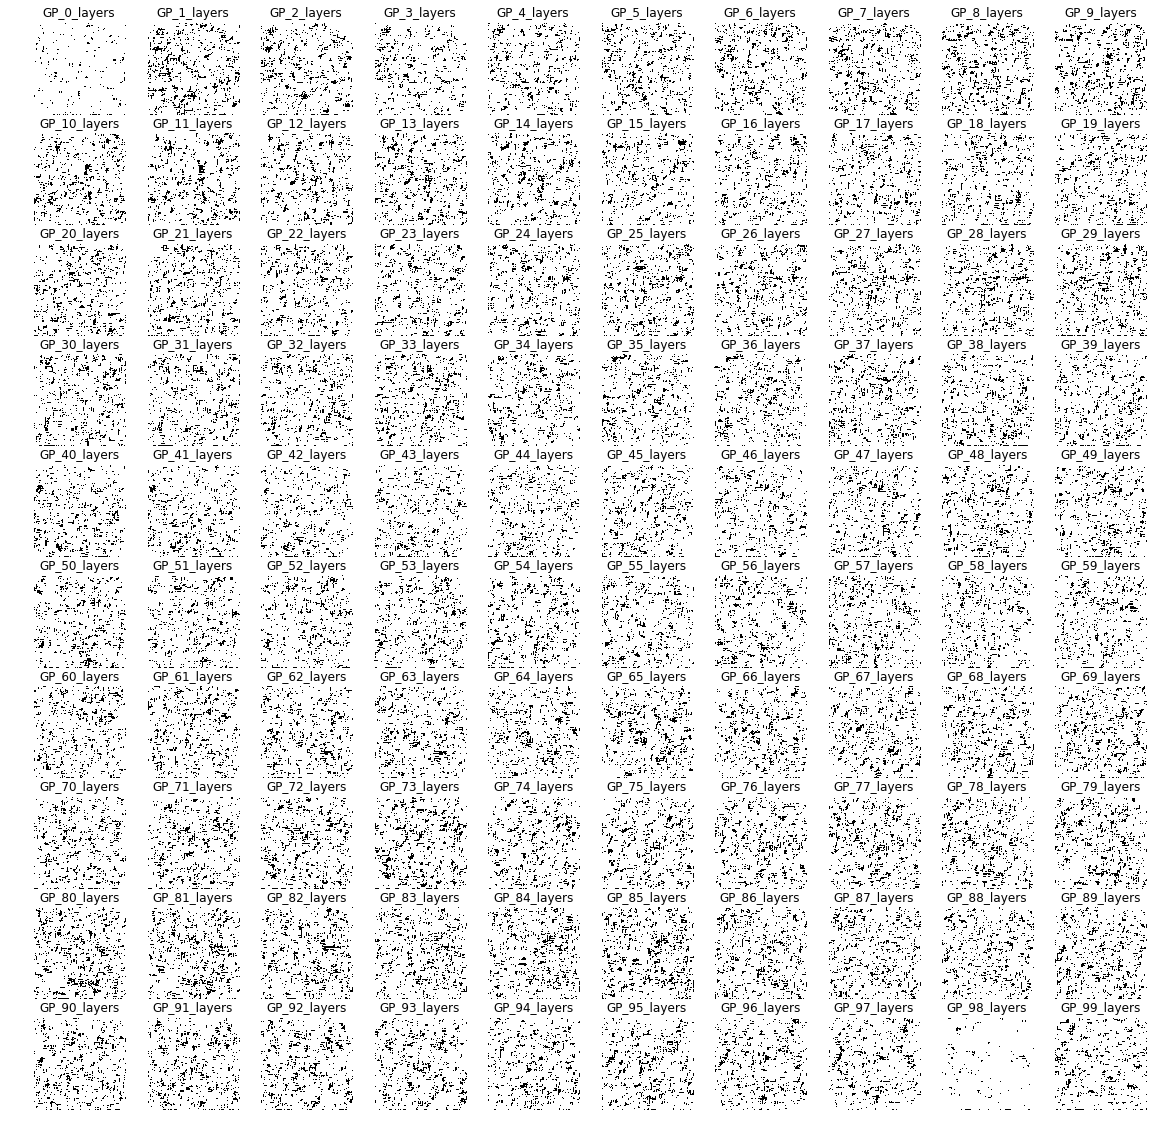

epoch:1  d_loss:[0.9649877 0.35     ]  g_loss:0.91363776
epoch:2  d_loss:[1.0613534 0.4      ]  g_loss:1.3583968
epoch:3  d_loss:[0.8399662 0.55     ]  g_loss:0.978582
epoch:4  d_loss:[1.708312 0.05    ]  g_loss:0.9109782
epoch:5  d_loss:[1.75234 0.2    ]  g_loss:0.50783956
epoch:6  d_loss:[1.4784613 0.2      ]  g_loss:0.80745584
epoch:7  d_loss:[1.5692887 0.1      ]  g_loss:1.0845258
epoch:8  d_loss:[1.5448251 0.15     ]  g_loss:0.79294074
epoch:9  d_loss:[1.7295862 0.1      ]  g_loss:0.8462782
epoch:10  d_loss:[1.4069598 0.15     ]  g_loss:1.184849


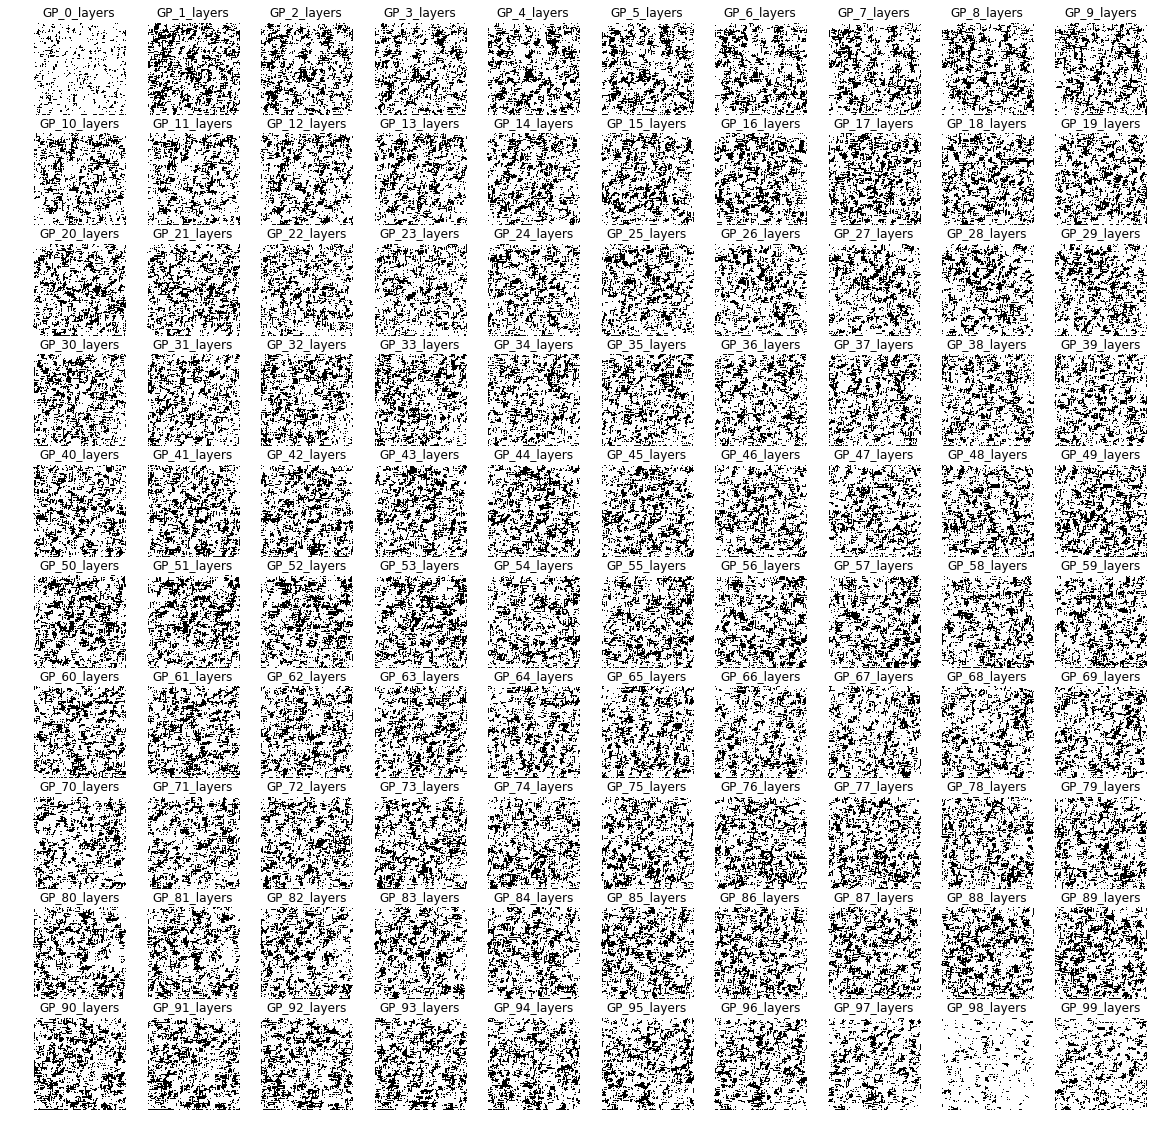

epoch:11  d_loss:[1.6257397 0.15     ]  g_loss:1.4795904
epoch:12  d_loss:[1.5798178 0.2      ]  g_loss:1.7954915
epoch:13  d_loss:[1.7611163 0.25     ]  g_loss:1.4256675
epoch:14  d_loss:[1.4658521  0.35000002]  g_loss:1.6965199
epoch:15  d_loss:[1.3265452 0.4      ]  g_loss:2.5418515
epoch:16  d_loss:[1.40376 0.15   ]  g_loss:2.4574356
epoch:17  d_loss:[1.0558486 0.35     ]  g_loss:2.4448938
epoch:18  d_loss:[1.4630821 0.4      ]  g_loss:2.8377106
epoch:19  d_loss:[1.4767506 0.5      ]  g_loss:4.700945
epoch:20  d_loss:[1.6563644 0.35     ]  g_loss:4.7190514


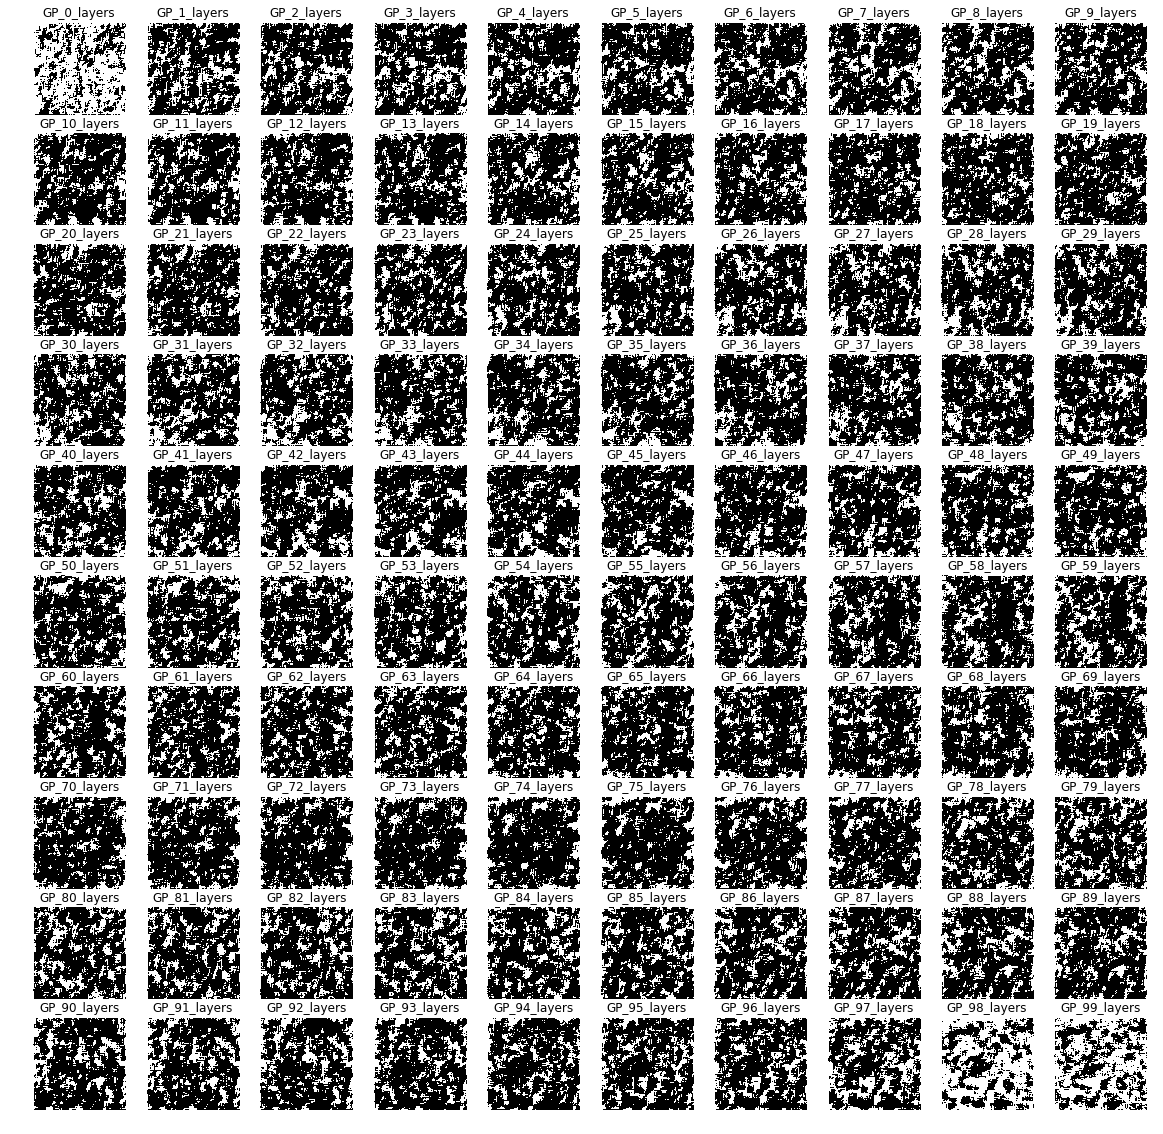

epoch:21  d_loss:[1.9737287 0.25     ]  g_loss:6.121104
epoch:22  d_loss:[2.2637587 0.15     ]  g_loss:6.7099977
epoch:23  d_loss:[2.6607475 0.4      ]  g_loss:6.67002
epoch:24  d_loss:[3.2837622 0.1      ]  g_loss:6.2420354
epoch:25  d_loss:[2.4211702 0.3      ]  g_loss:5.564568
epoch:26  d_loss:[1.6717819 0.2      ]  g_loss:6.403216
epoch:27  d_loss:[2.3044763 0.1      ]  g_loss:4.5151906
epoch:28  d_loss:[1.5250902 0.3      ]  g_loss:4.3108087
epoch:29  d_loss:[0.3973639 0.9      ]  g_loss:4.8945737
epoch:30  d_loss:[1.1914062 0.55     ]  g_loss:3.512446


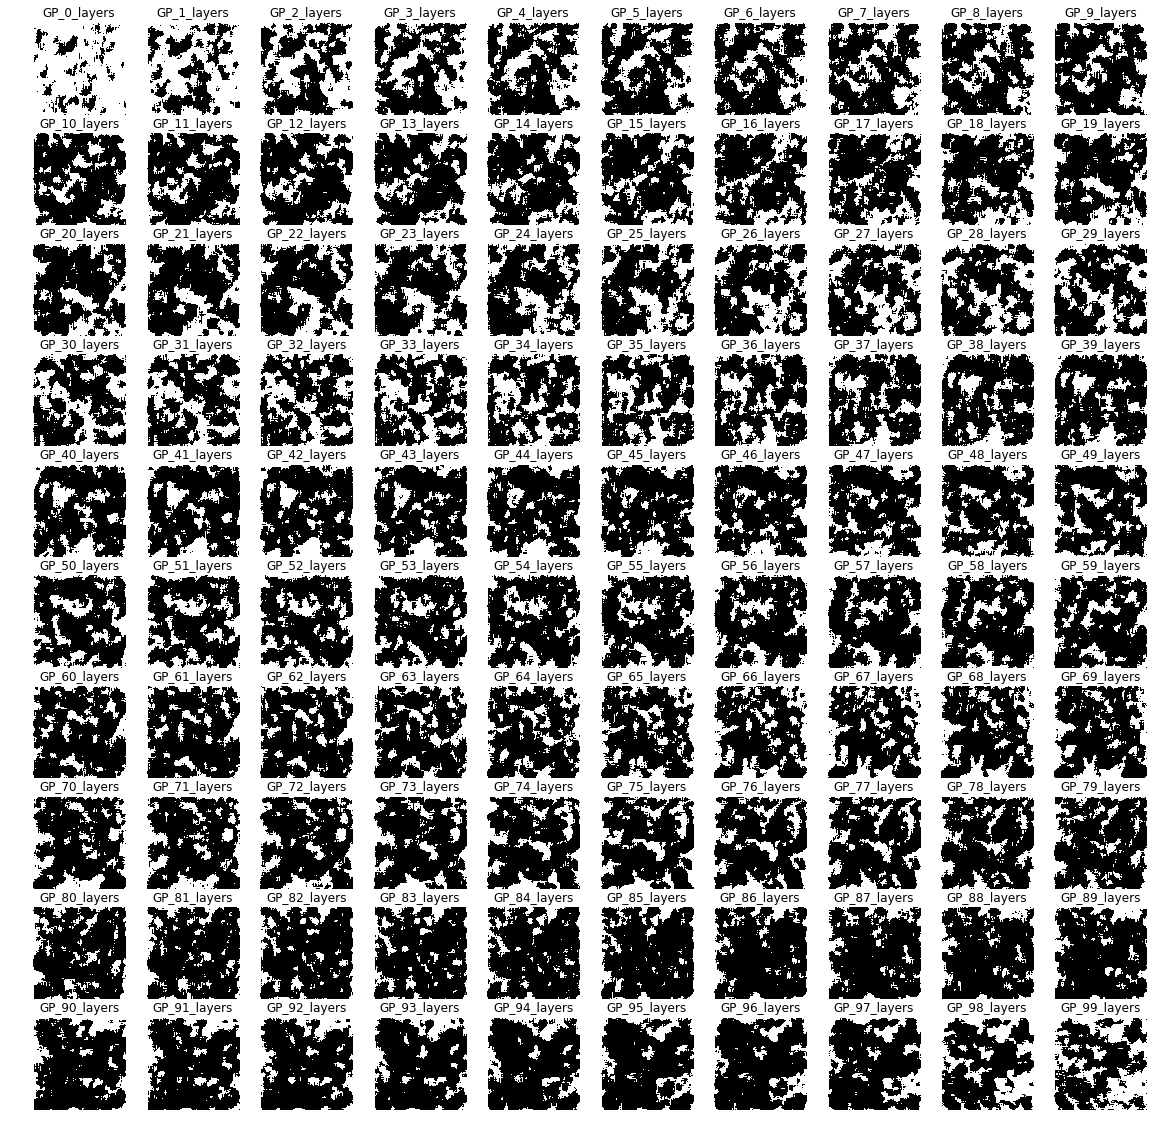

epoch:31  d_loss:[2.0639682 0.3      ]  g_loss:2.3759055
epoch:32  d_loss:[1.50219 0.4    ]  g_loss:3.0869012
epoch:33  d_loss:[1.1974459 0.4      ]  g_loss:3.1767938
epoch:34  d_loss:[1.6140165 0.3      ]  g_loss:2.8480468
epoch:35  d_loss:[0.73728454 0.55      ]  g_loss:3.9150643
epoch:36  d_loss:[0.5187198 0.8      ]  g_loss:2.963457
epoch:37  d_loss:[1.390199 0.4     ]  g_loss:2.9425359
epoch:38  d_loss:[0.5647915 0.65     ]  g_loss:3.2457185
epoch:39  d_loss:[1.1691675 0.35     ]  g_loss:1.9117527
epoch:40  d_loss:[1.7004666 0.55     ]  g_loss:3.0214436


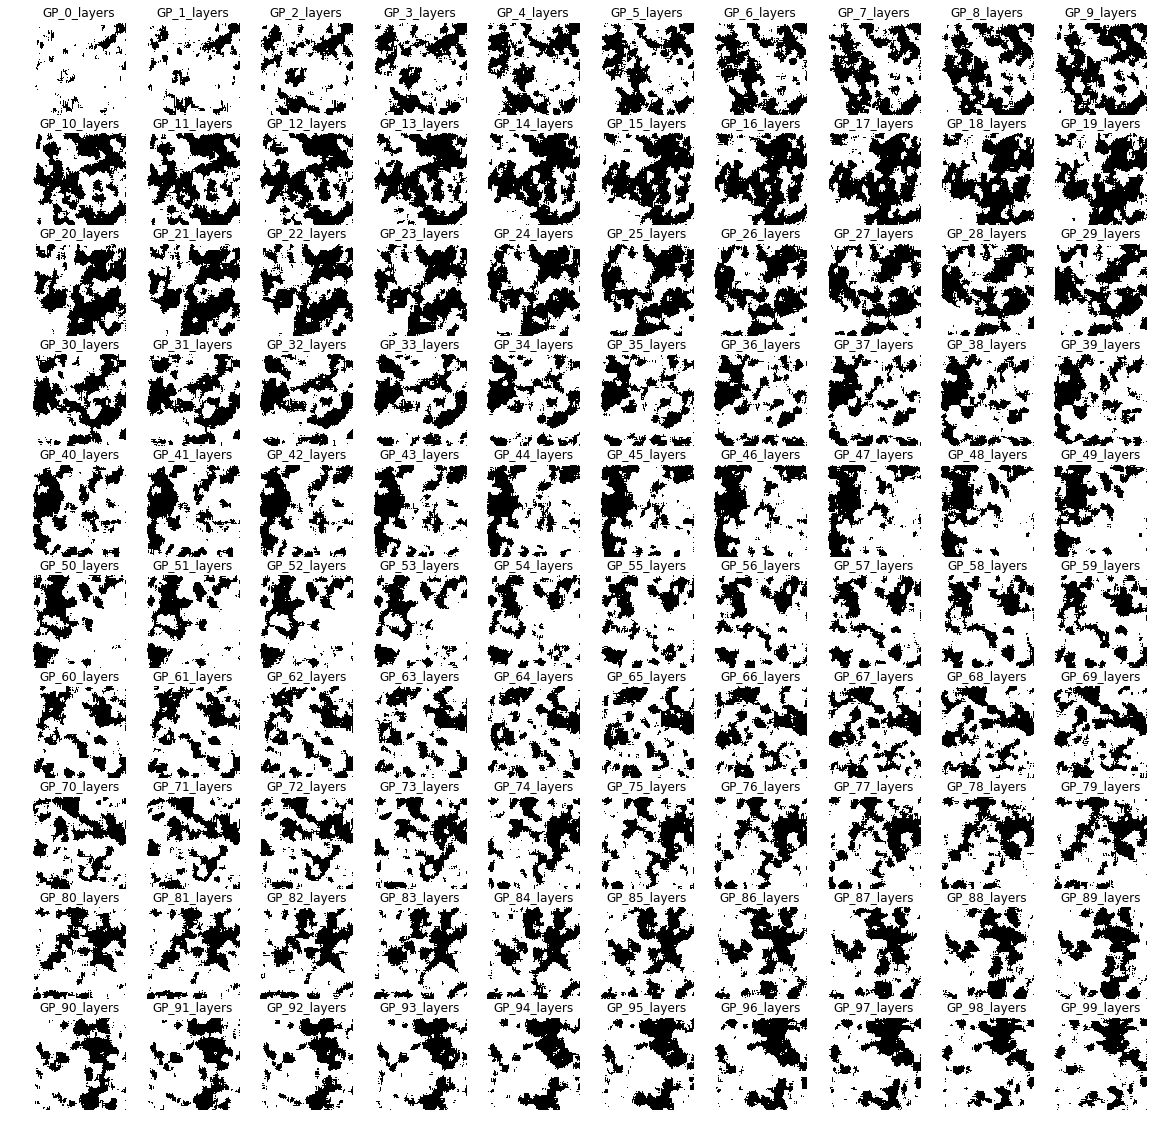

epoch:41  d_loss:[0.55513984 0.6       ]  g_loss:4.7368937
epoch:42  d_loss:[0.48885375 0.70000005]  g_loss:3.4589553
epoch:43  d_loss:[0.7611592 0.5      ]  g_loss:3.1158926
epoch:44  d_loss:[0.514858 0.7     ]  g_loss:3.094071
epoch:45  d_loss:[1.5644615 0.45     ]  g_loss:2.6293979
epoch:46  d_loss:[0.6723217 0.7      ]  g_loss:3.5031705
epoch:47  d_loss:[0.95215106 0.55      ]  g_loss:2.65247
epoch:48  d_loss:[0.9906692 0.6      ]  g_loss:3.2270207
epoch:49  d_loss:[0.8000813 0.4      ]  g_loss:3.2203186
epoch:50  d_loss:[0.86393595 0.6       ]  g_loss:3.1298938


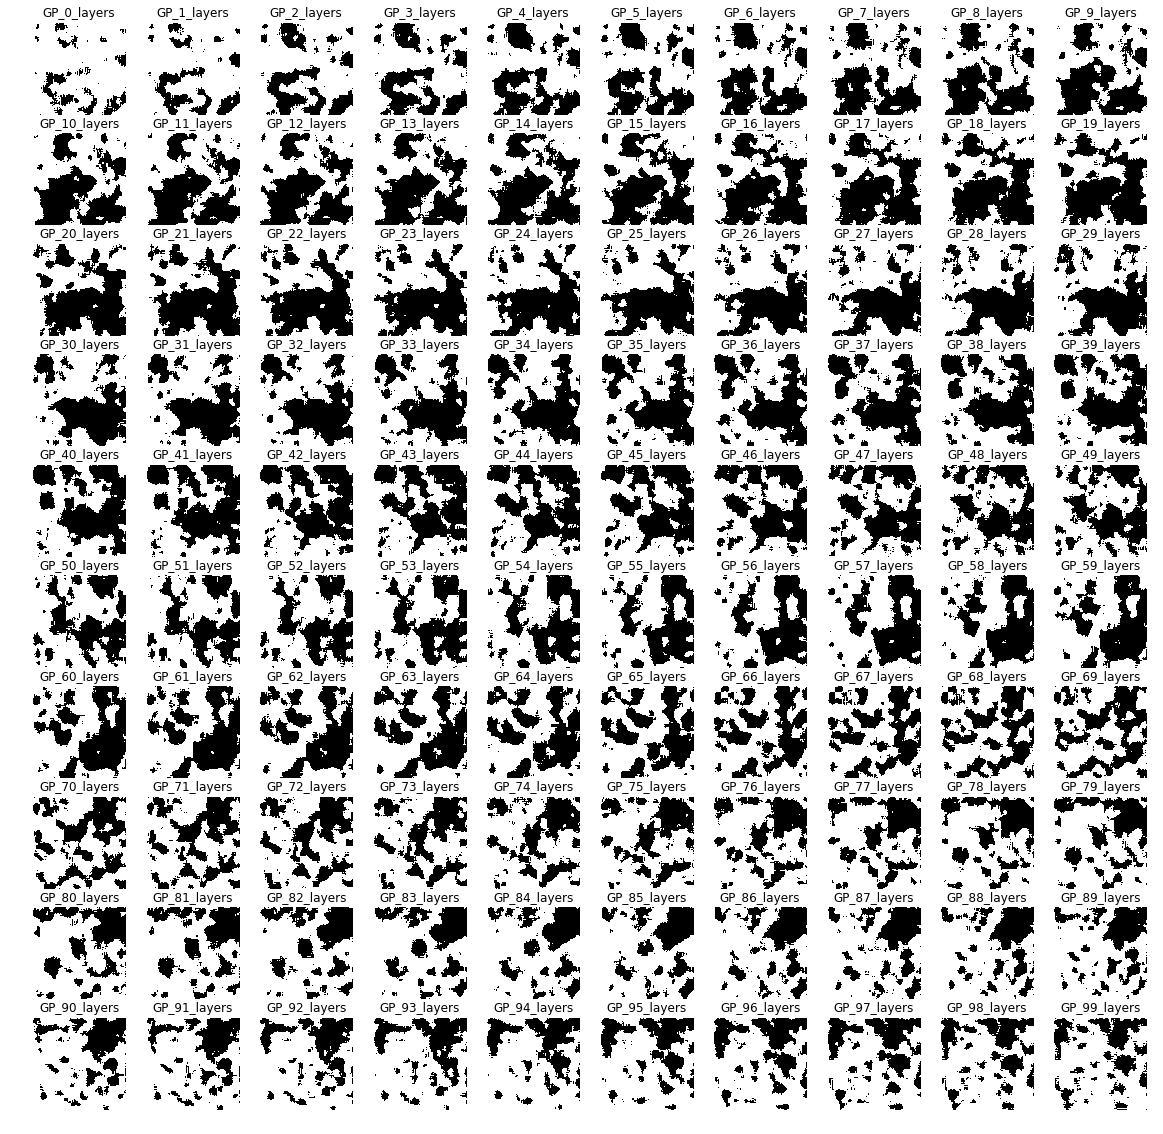

epoch:51  d_loss:[0.5601635 0.7      ]  g_loss:3.8718853
epoch:52  d_loss:[1.5391759 0.2      ]  g_loss:2.694128
epoch:53  d_loss:[0.36197177 0.85      ]  g_loss:2.2985053
epoch:54  d_loss:[0.70061564 0.55      ]  g_loss:2.2501645
epoch:55  d_loss:[0.5530453 0.65     ]  g_loss:3.0455914
epoch:56  d_loss:[0.6164334 0.75     ]  g_loss:4.4224296
epoch:57  d_loss:[1.6568425 0.35     ]  g_loss:1.7913773
epoch:58  d_loss:[0.5814509 0.65     ]  g_loss:2.8564892
epoch:59  d_loss:[0.87803066 0.6       ]  g_loss:2.8920465
epoch:60  d_loss:[0.5422993 0.75     ]  g_loss:3.3454583


epoch:61  d_loss:[0.9322289 0.65     ]  g_loss:1.8278217
epoch:62  d_loss:[0.50243455 0.75      ]  g_loss:2.5551353
epoch:63  d_loss:[0.16402309 0.95      ]  g_loss:4.620094
epoch:64  d_loss:[0.45181668 0.79999995]  g_loss:3.1237292
epoch:65  d_loss:[0.6428318 0.55     ]  g_loss:3.0767694
epoch:66  d_loss:[0.599003   0.70000005]  g_loss:2.527739
epoch:67  d_loss:[1.1219673 0.55     ]  g_loss:2.6405602
epoch:68  d_loss:[0.36250663 0.75      ]  g_loss:3.2884517
epoch:69  d_loss:[0.594092 0.65    ]  g_loss:4.007093
epoch:70  d_loss:[1.4601264 0.2      ]  g_loss:1.7342107


epoch:71  d_loss:[0.40358365 0.75      ]  g_loss:3.7949104
epoch:72  d_loss:[0.9365501 0.5      ]  g_loss:3.2359135
epoch:73  d_loss:[0.51189876 0.65      ]  g_loss:3.3462296
epoch:74  d_loss:[0.3687887 0.85     ]  g_loss:3.0056796
epoch:75  d_loss:[0.4505325 0.85     ]  g_loss:3.911943
epoch:76  d_loss:[1.0202152  0.35000002]  g_loss:1.904644
epoch:77  d_loss:[0.3458901 0.85     ]  g_loss:3.53614
epoch:78  d_loss:[0.61800456 0.6       ]  g_loss:2.8863437
epoch:79  d_loss:[0.65343237 0.7       ]  g_loss:3.7839618
epoch:80  d_loss:[0.81212014 0.5       ]  g_loss:1.9631354


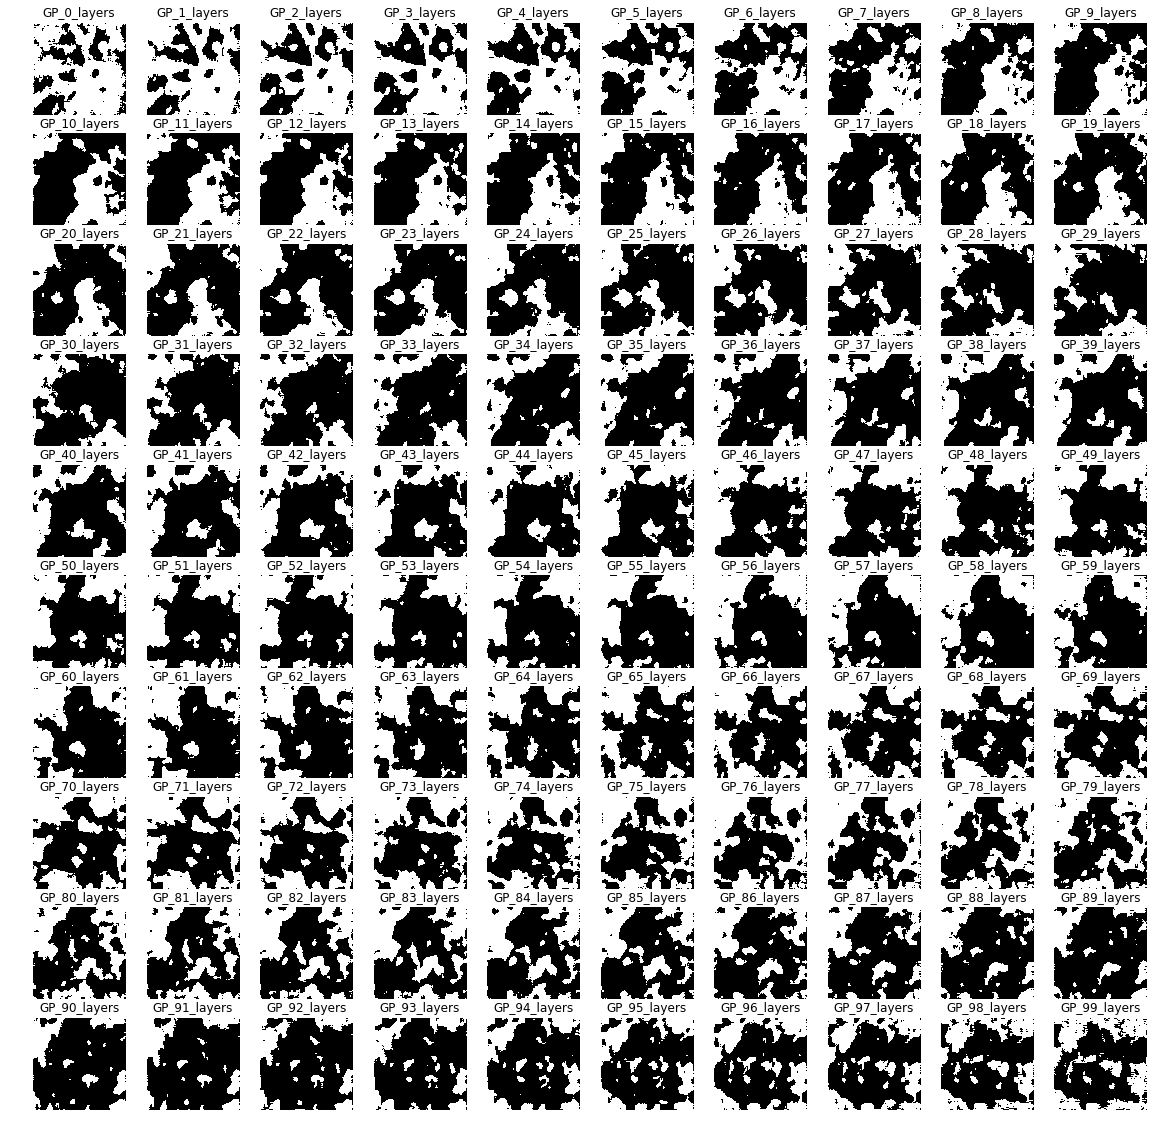

epoch:81  d_loss:[0.24331795 0.9       ]  g_loss:3.1453378
epoch:82  d_loss:[0.44299486 0.79999995]  g_loss:2.4335678
epoch:83  d_loss:[0.7888535 0.55     ]  g_loss:3.3641453
epoch:84  d_loss:[0.96043015 0.5       ]  g_loss:2.7181396
epoch:85  d_loss:[0.4371628 0.85     ]  g_loss:2.2901955
epoch:86  d_loss:[0.49805856 0.75      ]  g_loss:2.359547
epoch:87  d_loss:[0.54970074 0.70000005]  g_loss:3.800181
epoch:88  d_loss:[0.8422769  0.45000002]  g_loss:1.5647644
epoch:89  d_loss:[0.23751737 0.9       ]  g_loss:3.629521
epoch:90  d_loss:[0.17265959 0.95      ]  g_loss:3.5599284


epoch:91  d_loss:[0.54681164 0.65      ]  g_loss:2.1743522
epoch:92  d_loss:[0.27853352 0.9       ]  g_loss:1.4511915
epoch:93  d_loss:[0.34805626 0.8       ]  g_loss:3.230545
epoch:94  d_loss:[1.3431318 0.3      ]  g_loss:2.748711
epoch:95  d_loss:[0.20937088 0.95      ]  g_loss:3.0440335
epoch:96  d_loss:[0.46019766 0.70000005]  g_loss:3.9529862
epoch:97  d_loss:[1.076329 0.4     ]  g_loss:3.5639114
epoch:98  d_loss:[0.3728611 0.85     ]  g_loss:1.9146559
epoch:99  d_loss:[0.9493996 0.5      ]  g_loss:4.2432594
epoch:100  d_loss:[1.2763038 0.3      ]  g_loss:2.5880275


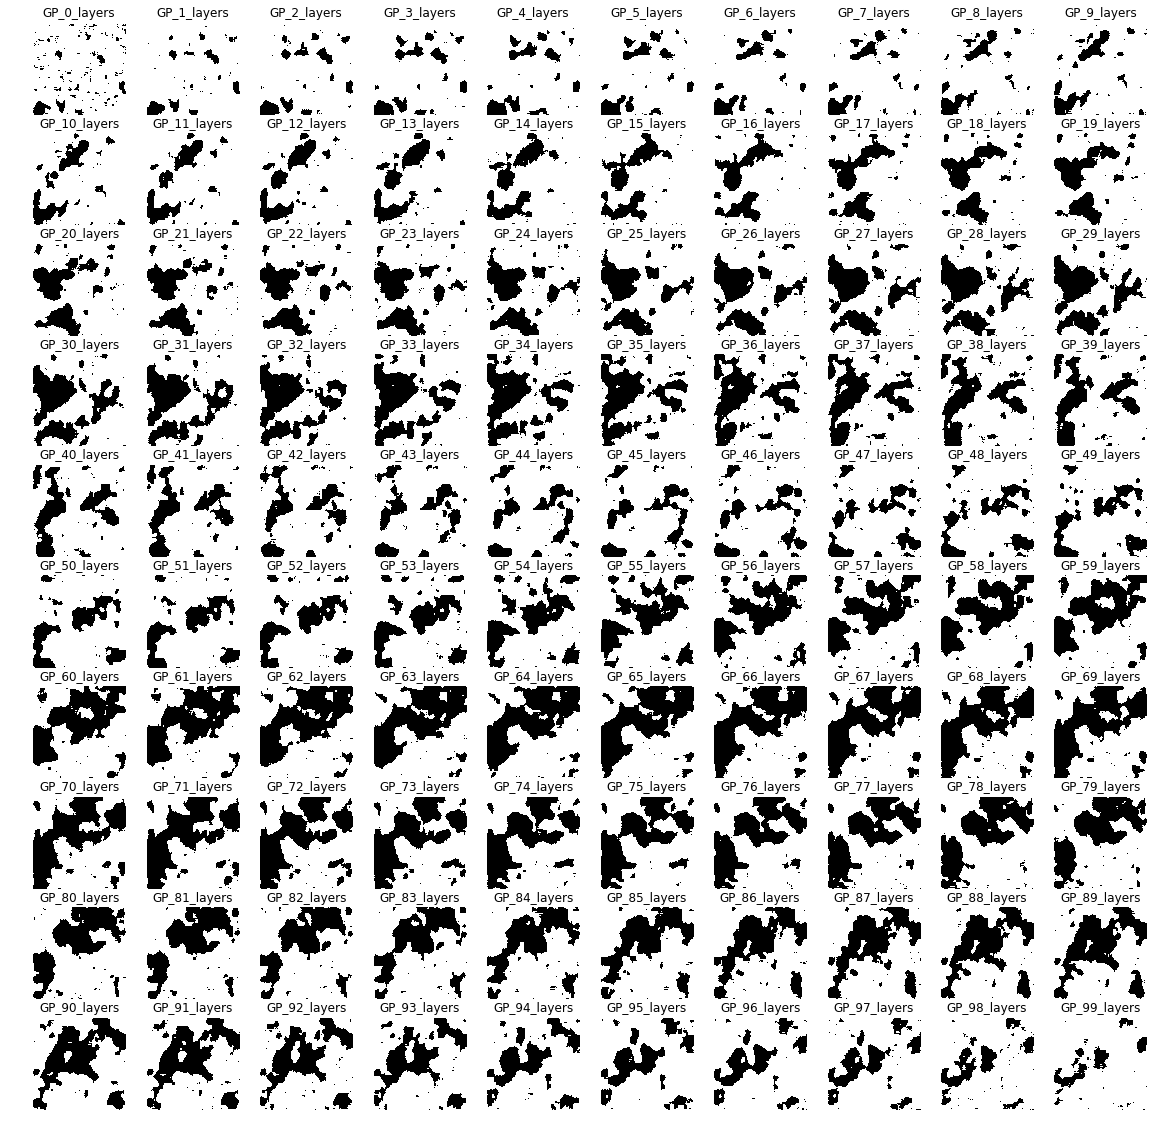

epoch:101  d_loss:[0.4813928 0.85     ]  g_loss:2.609084
epoch:102  d_loss:[0.30391794 0.85      ]  g_loss:4.4215074
epoch:103  d_loss:[0.7587904 0.6      ]  g_loss:1.9164699
epoch:104  d_loss:[0.5071388 0.7      ]  g_loss:5.8003664
epoch:105  d_loss:[1.6010976 0.25     ]  g_loss:1.8184035
epoch:106  d_loss:[0.38725877 0.79999995]  g_loss:4.5946074
epoch:107  d_loss:[0.91423845 0.65      ]  g_loss:3.1635768
epoch:108  d_loss:[0.84270775 0.6       ]  g_loss:3.550544
epoch:109  d_loss:[0.8079058 0.65     ]  g_loss:3.1118054
epoch:110  d_loss:[0.5670558 0.75     ]  g_loss:1.7241758


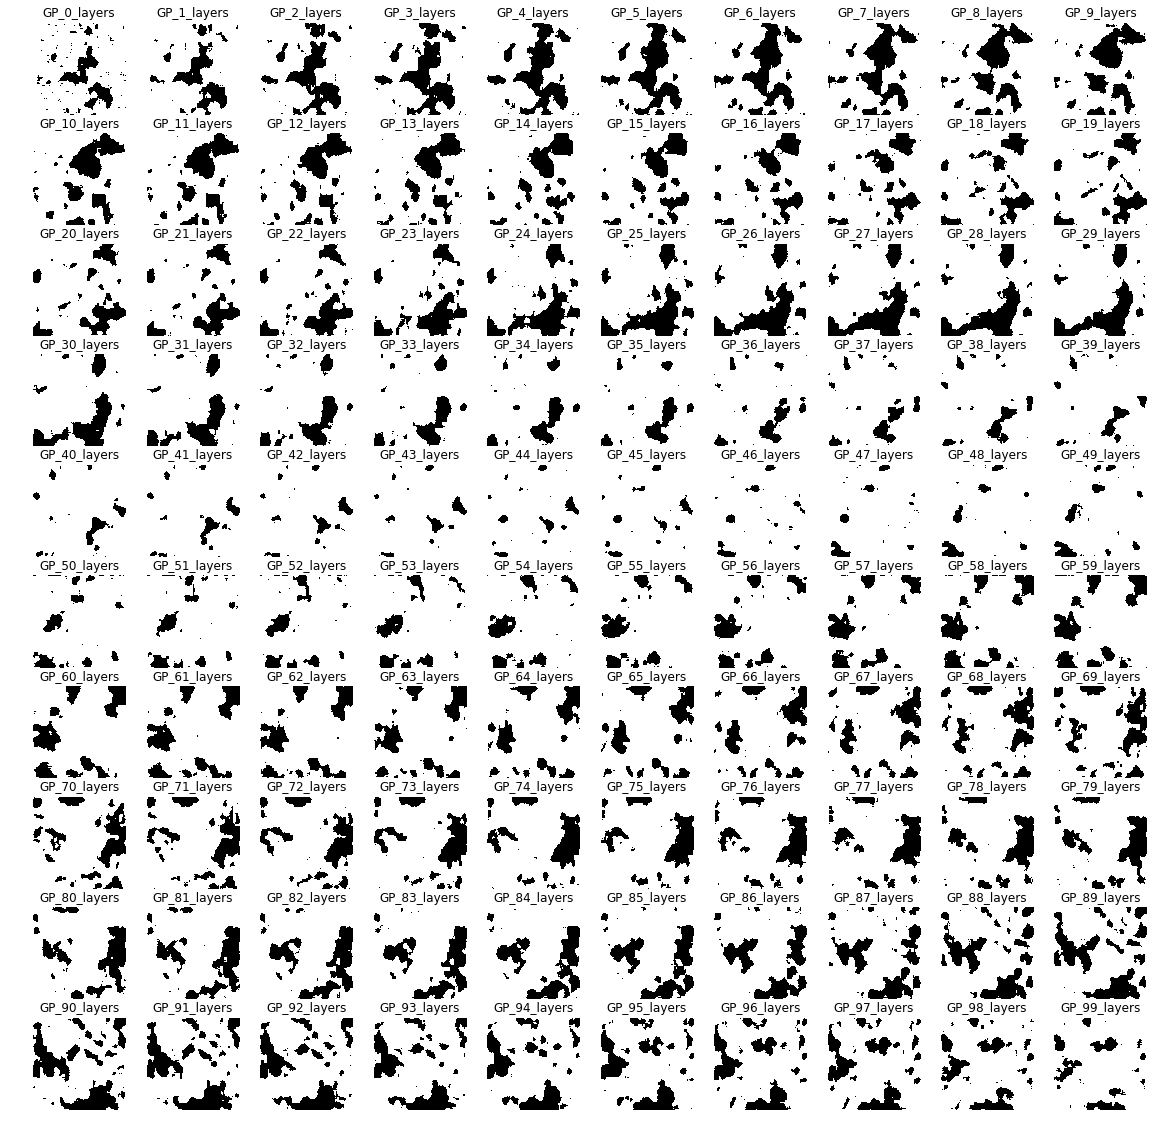

epoch:111  d_loss:[0.3956064 0.85     ]  g_loss:3.3458753
epoch:112  d_loss:[0.35035586 0.85      ]  g_loss:2.769219
epoch:113  d_loss:[0.4138128 0.8      ]  g_loss:4.436817
epoch:114  d_loss:[2.7944705 0.25     ]  g_loss:3.056362
epoch:115  d_loss:[0.34020287 0.85      ]  g_loss:2.3593717
epoch:116  d_loss:[1.2111486  0.35000002]  g_loss:2.20575
epoch:117  d_loss:[0.9665669 0.4      ]  g_loss:3.7482445
epoch:118  d_loss:[1.4509827 0.35     ]  g_loss:1.8401635
epoch:119  d_loss:[0.19347426 0.9       ]  g_loss:2.7877407
epoch:120  d_loss:[1.0588746  0.45000002]  g_loss:1.847078


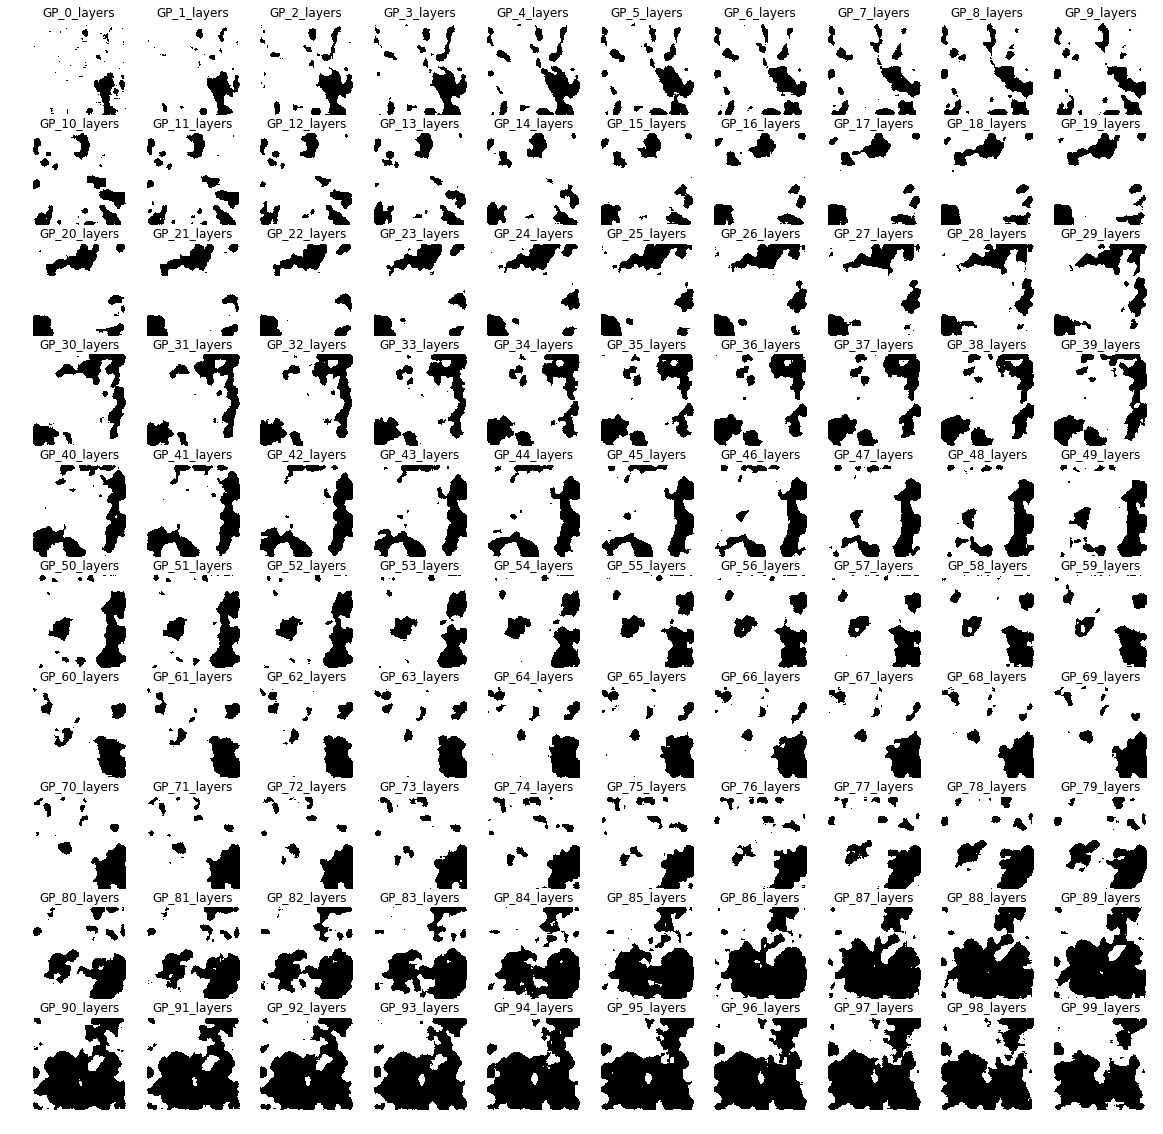

epoch:121  d_loss:[0.40502793 0.75      ]  g_loss:3.030252
epoch:122  d_loss:[1.021374 0.3     ]  g_loss:1.2538683
epoch:123  d_loss:[0.58607674 0.65      ]  g_loss:1.9293407
epoch:124  d_loss:[0.9621568 0.4      ]  g_loss:3.12305
epoch:125  d_loss:[1.8220878 0.25     ]  g_loss:2.2103772
epoch:126  d_loss:[0.988451 0.25    ]  g_loss:2.5144897
epoch:127  d_loss:[1.6714778 0.25     ]  g_loss:1.7316784
epoch:128  d_loss:[1.2082405 0.45     ]  g_loss:1.5659556
epoch:129  d_loss:[0.85507643 0.65      ]  g_loss:2.7489064
epoch:130  d_loss:[0.97578406 0.3       ]  g_loss:2.0588734


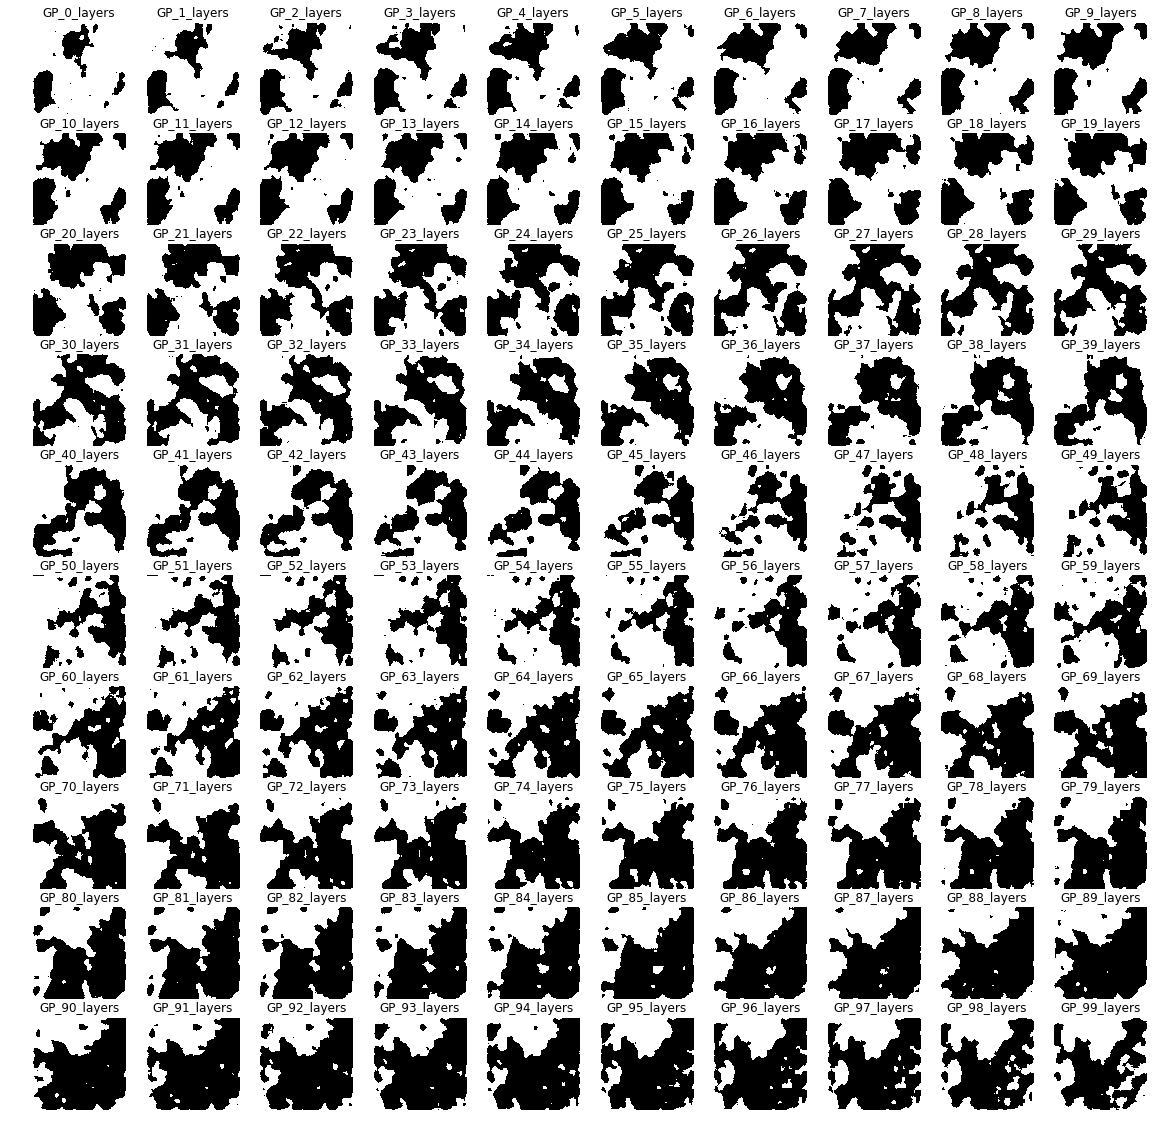

epoch:131  d_loss:[0.5353125 0.75     ]  g_loss:2.547187
epoch:132  d_loss:[0.3890129 0.95     ]  g_loss:2.8288426
epoch:133  d_loss:[0.8935071 0.5      ]  g_loss:2.4974296
epoch:134  d_loss:[1.1911525  0.35000002]  g_loss:2.2731385
epoch:135  d_loss:[0.85344195 0.45      ]  g_loss:2.5569406
epoch:136  d_loss:[1.1380564 0.3      ]  g_loss:2.4577641
epoch:137  d_loss:[0.8801328 0.55     ]  g_loss:2.967103
epoch:138  d_loss:[0.7329837 0.6      ]  g_loss:2.3959336
epoch:139  d_loss:[1.3395429 0.3      ]  g_loss:1.9177563
epoch:140  d_loss:[0.2483229 0.9      ]  g_loss:2.8123183


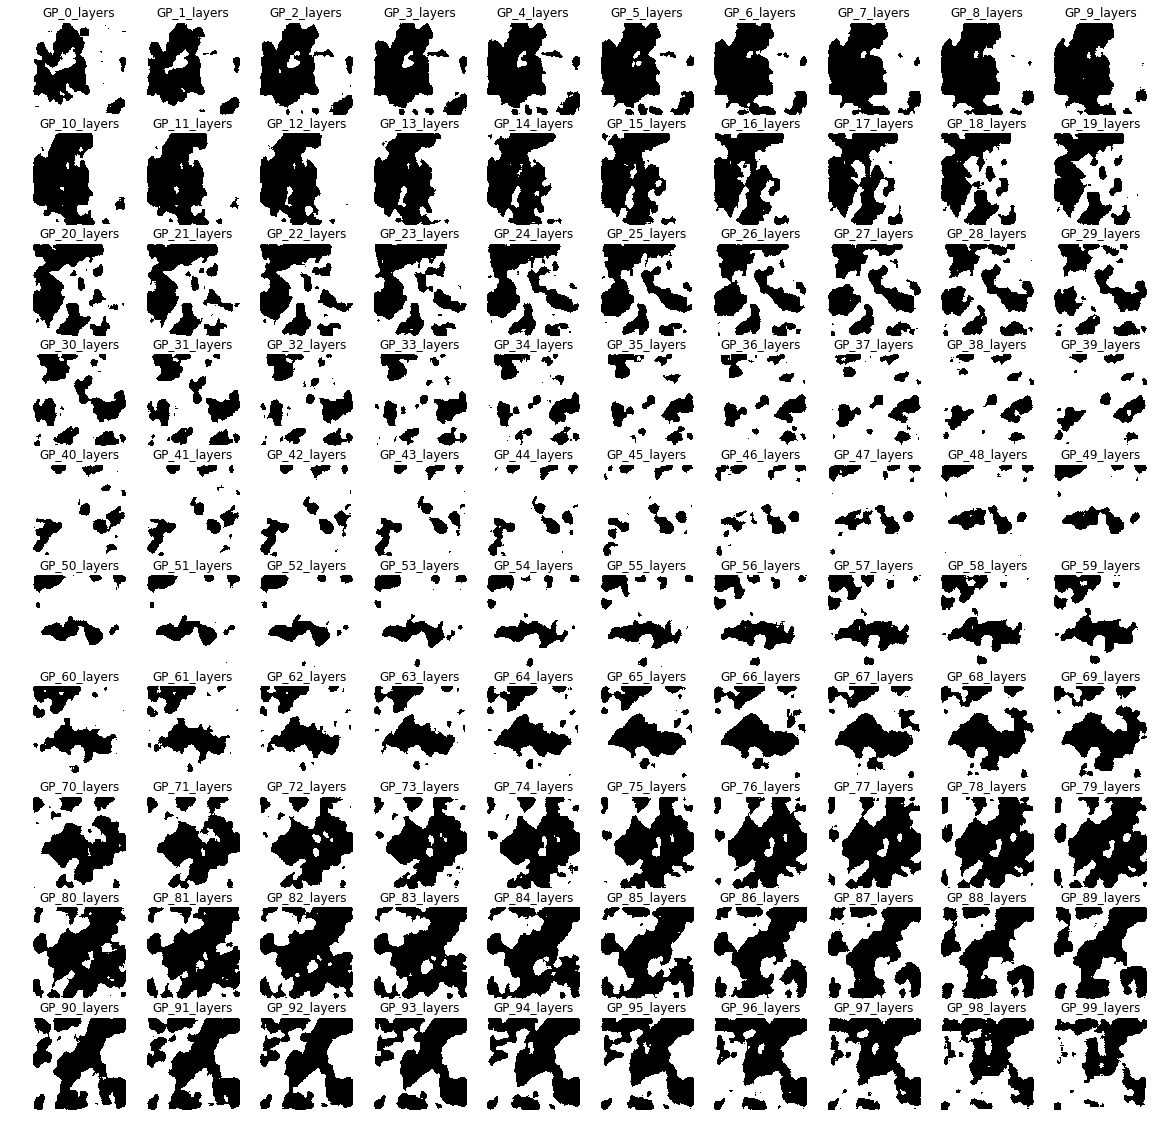

epoch:141  d_loss:[0.36317652 0.85      ]  g_loss:2.2875729
epoch:142  d_loss:[0.9142773 0.55     ]  g_loss:3.044375
epoch:143  d_loss:[0.7032288 0.55     ]  g_loss:3.1264672
epoch:144  d_loss:[1.1930223 0.3      ]  g_loss:3.147687
epoch:145  d_loss:[1.0967398  0.45000002]  g_loss:1.674798
epoch:146  d_loss:[0.3950149 0.85     ]  g_loss:2.7674441
epoch:147  d_loss:[1.2209171 0.45     ]  g_loss:2.7606847
epoch:148  d_loss:[0.66846514 0.65      ]  g_loss:3.209214
epoch:149  d_loss:[0.8392582 0.6      ]  g_loss:2.616401
epoch:150  d_loss:[0.3975644 0.75     ]  g_loss:2.61516


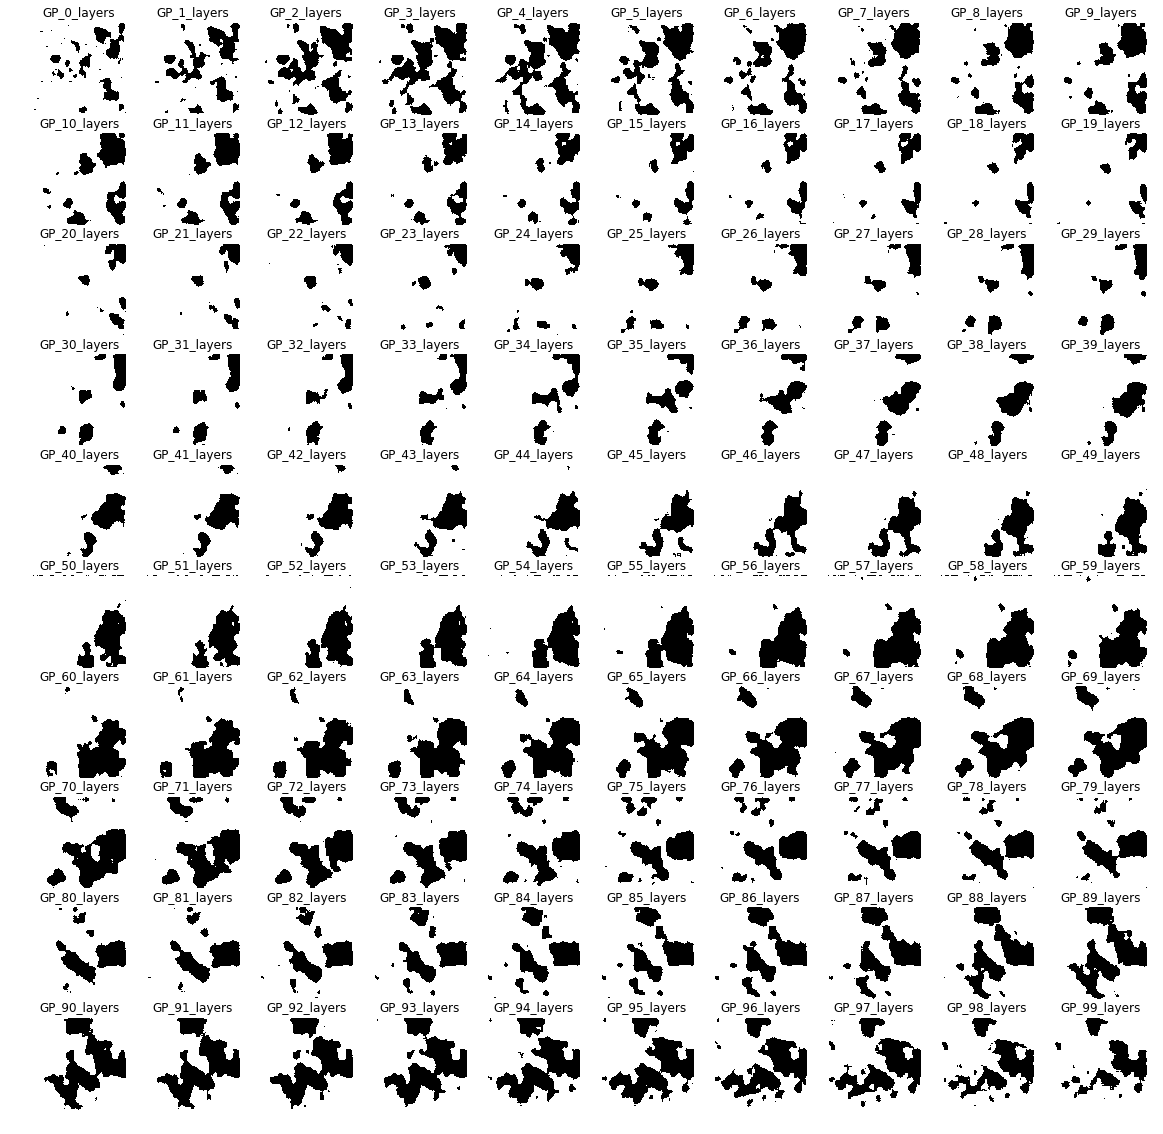

epoch:151  d_loss:[0.7011814 0.6      ]  g_loss:3.2202232
epoch:152  d_loss:[1.2793331 0.25     ]  g_loss:3.655124
epoch:153  d_loss:[1.5259635 0.15     ]  g_loss:3.358857
epoch:154  d_loss:[0.88005084 0.45      ]  g_loss:2.5271153
epoch:155  d_loss:[0.99122393 0.45      ]  g_loss:3.5717292
epoch:156  d_loss:[0.7259525 0.65     ]  g_loss:3.6232433
epoch:157  d_loss:[0.78574413 0.6       ]  g_loss:2.6926441
epoch:158  d_loss:[1.3513881 0.35     ]  g_loss:4.432156
epoch:159  d_loss:[1.2971584 0.3      ]  g_loss:6.5820146
epoch:160  d_loss:[2.2675838 0.25     ]  g_loss:1.427347


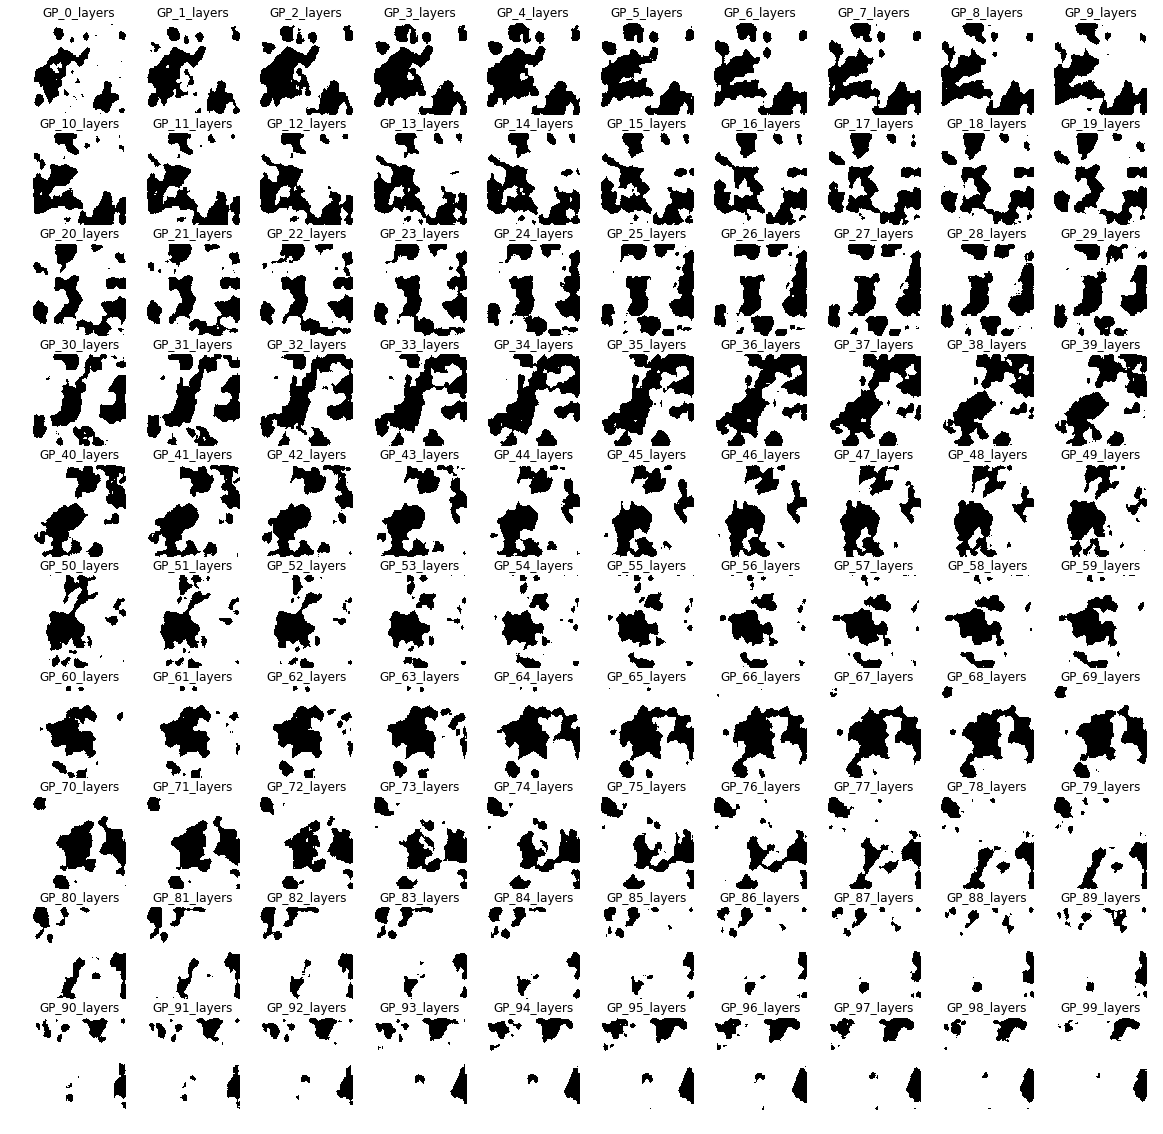

epoch:161  d_loss:[0.48167554 0.75      ]  g_loss:4.107604
epoch:162  d_loss:[0.91886866 0.6       ]  g_loss:1.6991787
epoch:163  d_loss:[1.4963062 0.4      ]  g_loss:3.6032462
epoch:164  d_loss:[0.5004379 0.8      ]  g_loss:2.6242127
epoch:165  d_loss:[0.38012242 0.79999995]  g_loss:2.5735295
epoch:166  d_loss:[1.6105855 0.35     ]  g_loss:3.447723
epoch:167  d_loss:[0.94764256 0.55      ]  g_loss:3.2688472
epoch:168  d_loss:[0.64796984 0.8       ]  g_loss:3.9209511
epoch:169  d_loss:[1.0069335 0.6      ]  g_loss:2.7543633
epoch:170  d_loss:[0.583525 0.65    ]  g_loss:2.7689843


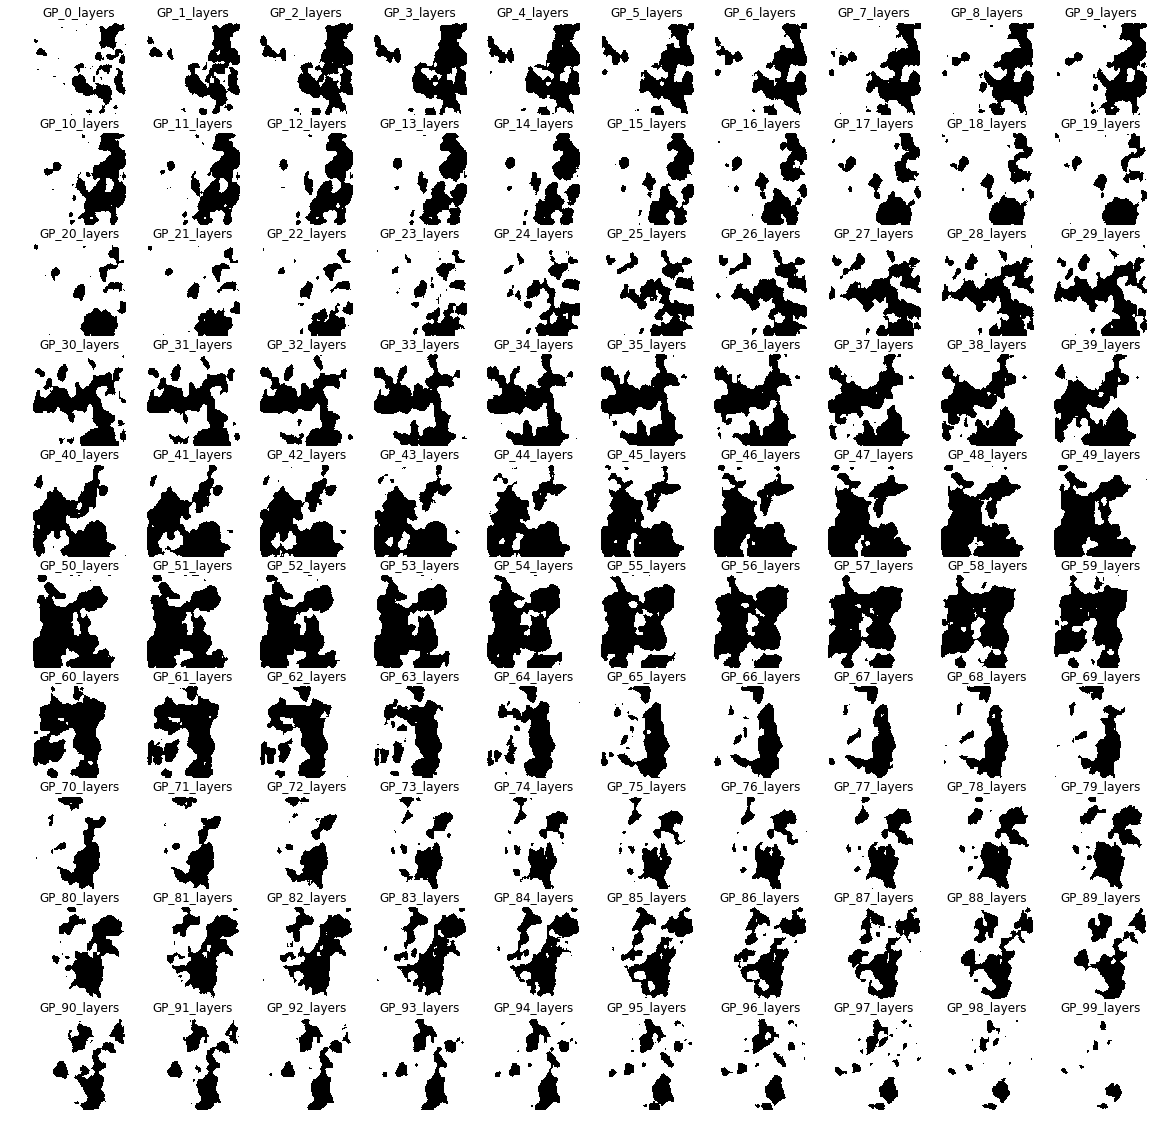

epoch:171  d_loss:[0.17912787 0.95      ]  g_loss:3.1607757
epoch:172  d_loss:[0.5342114 0.7      ]  g_loss:3.0853424
epoch:173  d_loss:[0.31897008 0.85      ]  g_loss:3.7761035
epoch:174  d_loss:[1.252612 0.45    ]  g_loss:2.7623873
epoch:175  d_loss:[0.86063784 0.5       ]  g_loss:5.844098
epoch:176  d_loss:[1.2540853  0.35000002]  g_loss:3.8546436
epoch:177  d_loss:[0.6464542 0.75     ]  g_loss:3.0183496
epoch:178  d_loss:[1.2853001 0.35     ]  g_loss:4.3016486
epoch:179  d_loss:[0.70878154 0.65      ]  g_loss:1.2284887
epoch:180  d_loss:[0.8759488 0.65     ]  g_loss:4.5927463


epoch:181  d_loss:[1.720905 0.25    ]  g_loss:2.2607436
epoch:182  d_loss:[1.5319002 0.2      ]  g_loss:3.900557
epoch:183  d_loss:[0.7773713 0.55     ]  g_loss:2.3419487
epoch:184  d_loss:[0.16579333 0.9       ]  g_loss:2.0429177
epoch:185  d_loss:[0.54948986 0.65      ]  g_loss:2.5597222
epoch:186  d_loss:[0.2186989 0.9      ]  g_loss:5.0052934
epoch:187  d_loss:[0.49503636 0.75      ]  g_loss:0.94516313
epoch:188  d_loss:[0.47632447 0.75      ]  g_loss:4.454045
epoch:189  d_loss:[0.26991242 0.9       ]  g_loss:3.5791733
epoch:190  d_loss:[1.8880883 0.15     ]  g_loss:3.0695105


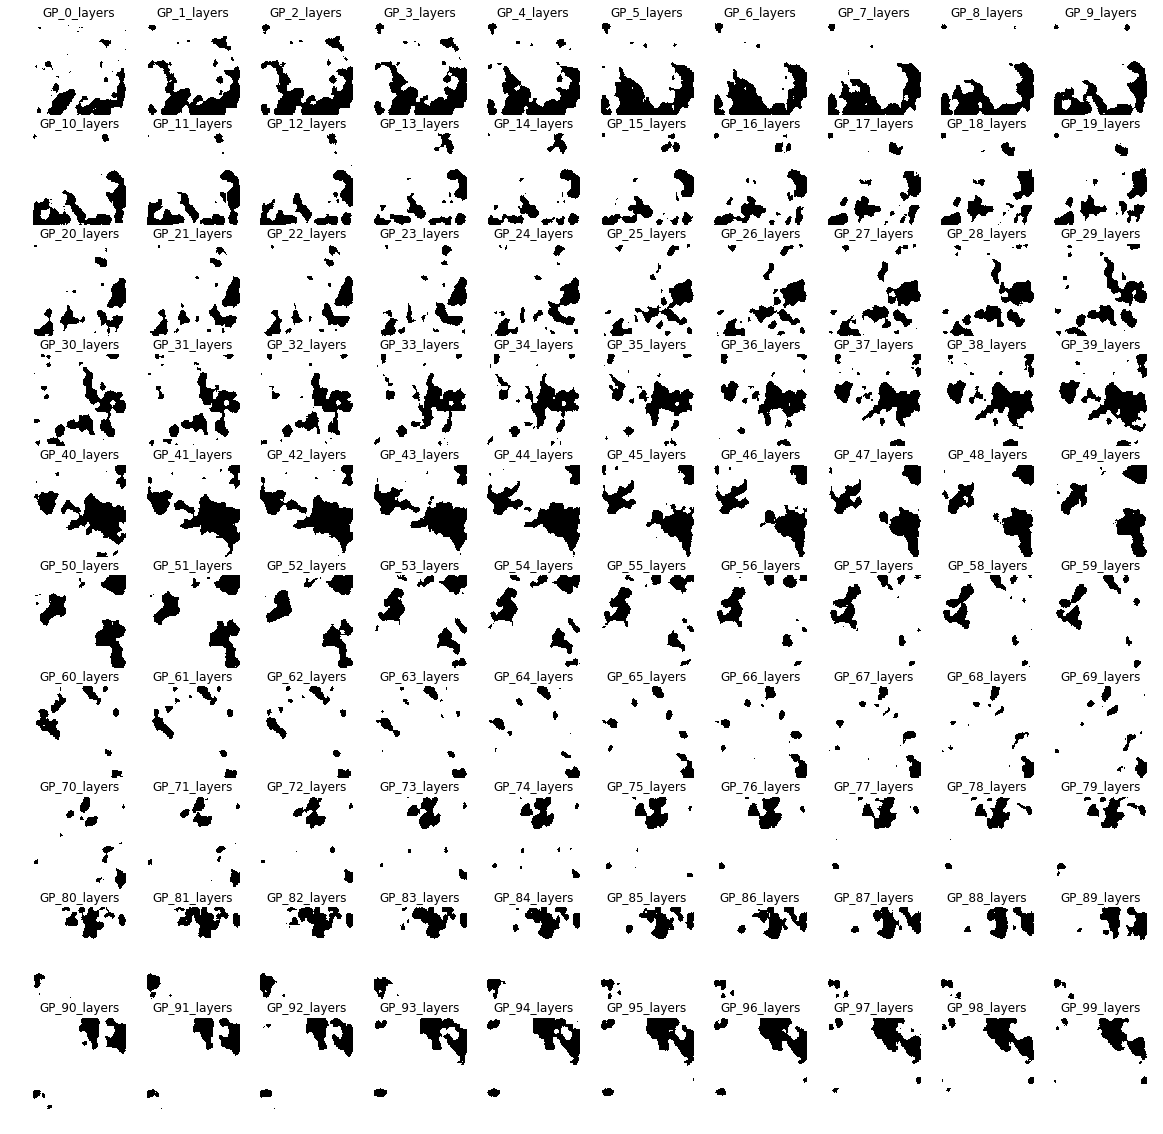

epoch:191  d_loss:[0.33674362 0.9       ]  g_loss:2.5600579
epoch:192  d_loss:[0.386714 0.75    ]  g_loss:3.9743793
epoch:193  d_loss:[0.58683443 0.65      ]  g_loss:1.3202784
epoch:194  d_loss:[1.5800483 0.5      ]  g_loss:6.1173096
epoch:195  d_loss:[1.0717655 0.55     ]  g_loss:0.5817452
epoch:196  d_loss:[0.4095443 0.75     ]  g_loss:3.5027542
epoch:197  d_loss:[0.24800809 0.85      ]  g_loss:2.3548589
epoch:198  d_loss:[0.4850561 0.75     ]  g_loss:4.4521265
epoch:199  d_loss:[0.49540484 0.75      ]  g_loss:1.8408455
epoch:200  d_loss:[0.38486552 0.85      ]  g_loss:2.9196048


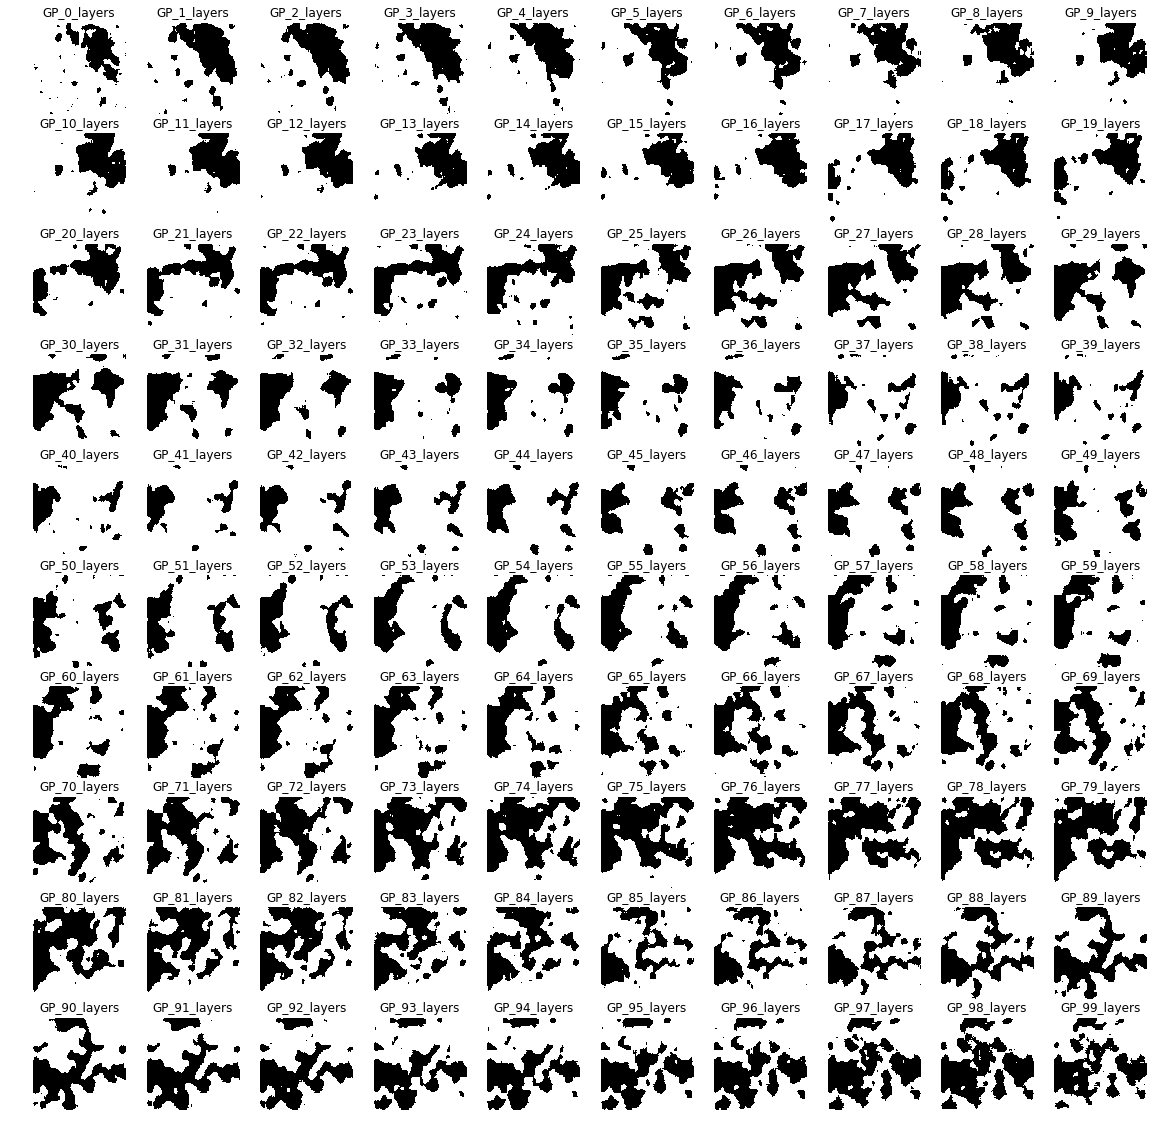

epoch:201  d_loss:[1.2157996 0.5      ]  g_loss:3.515815
epoch:202  d_loss:[0.9965155 0.5      ]  g_loss:3.1554885
epoch:203  d_loss:[0.400179 0.8     ]  g_loss:1.359376
epoch:204  d_loss:[0.35148636 0.9       ]  g_loss:1.993634
epoch:205  d_loss:[0.7210411 0.45     ]  g_loss:3.9862843
epoch:206  d_loss:[1.0407994 0.55     ]  g_loss:5.29125
epoch:207  d_loss:[0.8610767 0.55     ]  g_loss:1.3355476
epoch:208  d_loss:[0.59965605 0.8       ]  g_loss:5.0947027
epoch:209  d_loss:[0.6100761  0.70000005]  g_loss:3.7941158
epoch:210  d_loss:[0.15903553 0.9       ]  g_loss:3.5093064


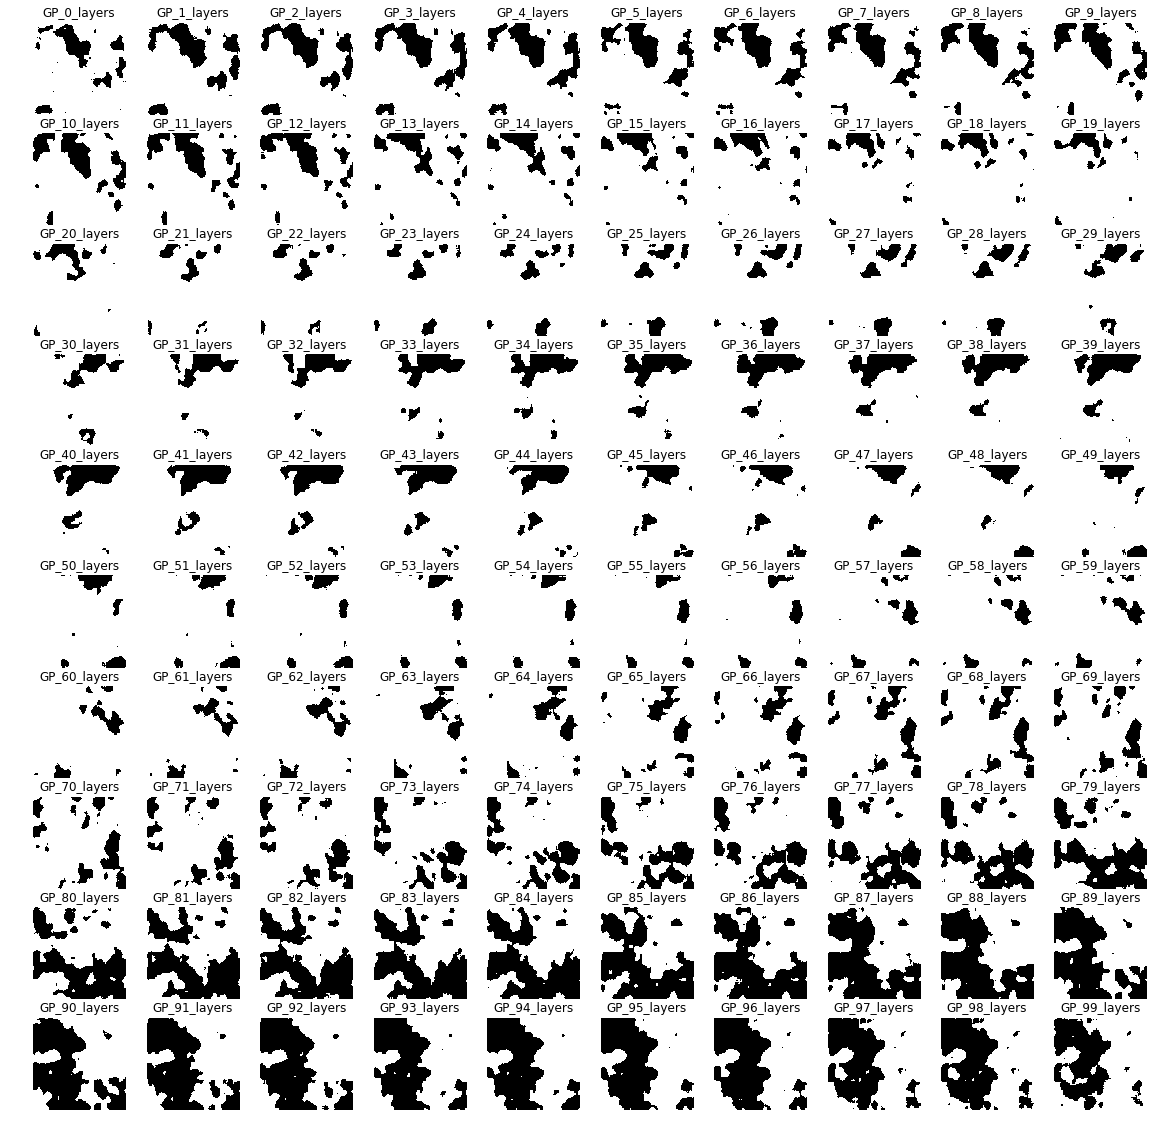

epoch:211  d_loss:[0.71860397 0.65      ]  g_loss:4.923926
epoch:212  d_loss:[0.5662715 0.75     ]  g_loss:2.2291732
epoch:213  d_loss:[0.21235979 0.95      ]  g_loss:4.739858
epoch:214  d_loss:[0.3040868 0.9      ]  g_loss:2.671302
epoch:215  d_loss:[0.10032617 1.        ]  g_loss:3.1551278
epoch:216  d_loss:[0.14800653 1.        ]  g_loss:3.5788815
epoch:217  d_loss:[0.14930335 0.9       ]  g_loss:2.8935854
epoch:218  d_loss:[0.18184368 0.9       ]  g_loss:4.677718
epoch:219  d_loss:[0.28982747 0.95      ]  g_loss:4.033202
epoch:220  d_loss:[0.1690598 0.95     ]  g_loss:4.5032797


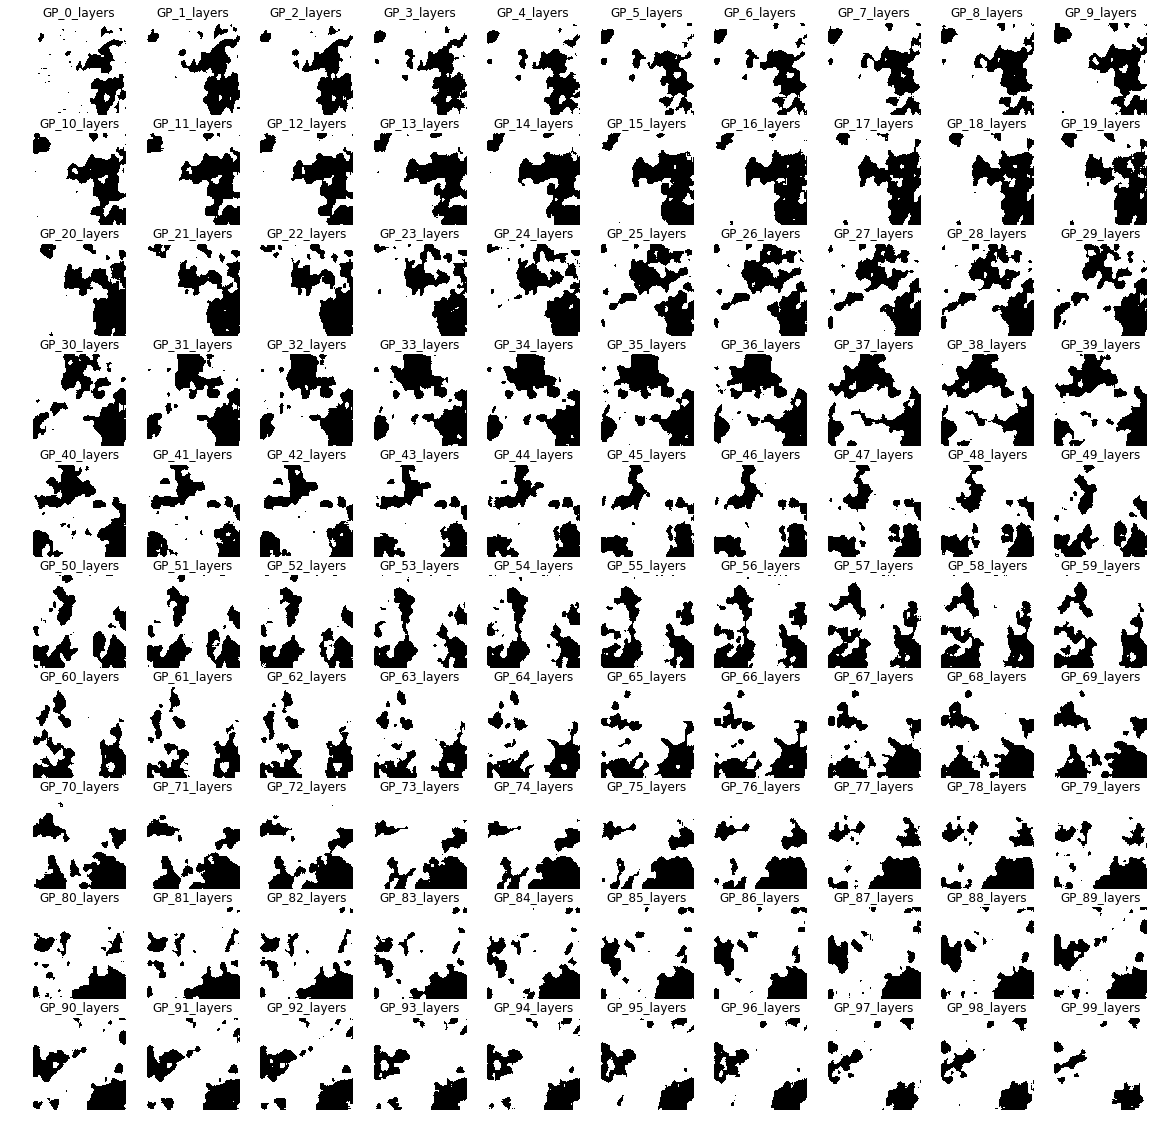

epoch:221  d_loss:[0.24515763 0.9       ]  g_loss:3.9316006
epoch:222  d_loss:[0.2060383 1.       ]  g_loss:2.7052011
epoch:223  d_loss:[0.08880769 1.        ]  g_loss:3.4479249
epoch:224  d_loss:[0.08688848 0.95      ]  g_loss:2.746887
epoch:225  d_loss:[0.34802186 0.85      ]  g_loss:2.9561965
epoch:226  d_loss:[0.0427082 1.       ]  g_loss:5.0779934
epoch:227  d_loss:[0.22941445 0.9       ]  g_loss:1.7599385
epoch:228  d_loss:[0.03677957 1.        ]  g_loss:2.1963367
epoch:229  d_loss:[0.16369182 0.95      ]  g_loss:4.607493
epoch:230  d_loss:[0.85432327 0.5       ]  g_loss:5.3573236


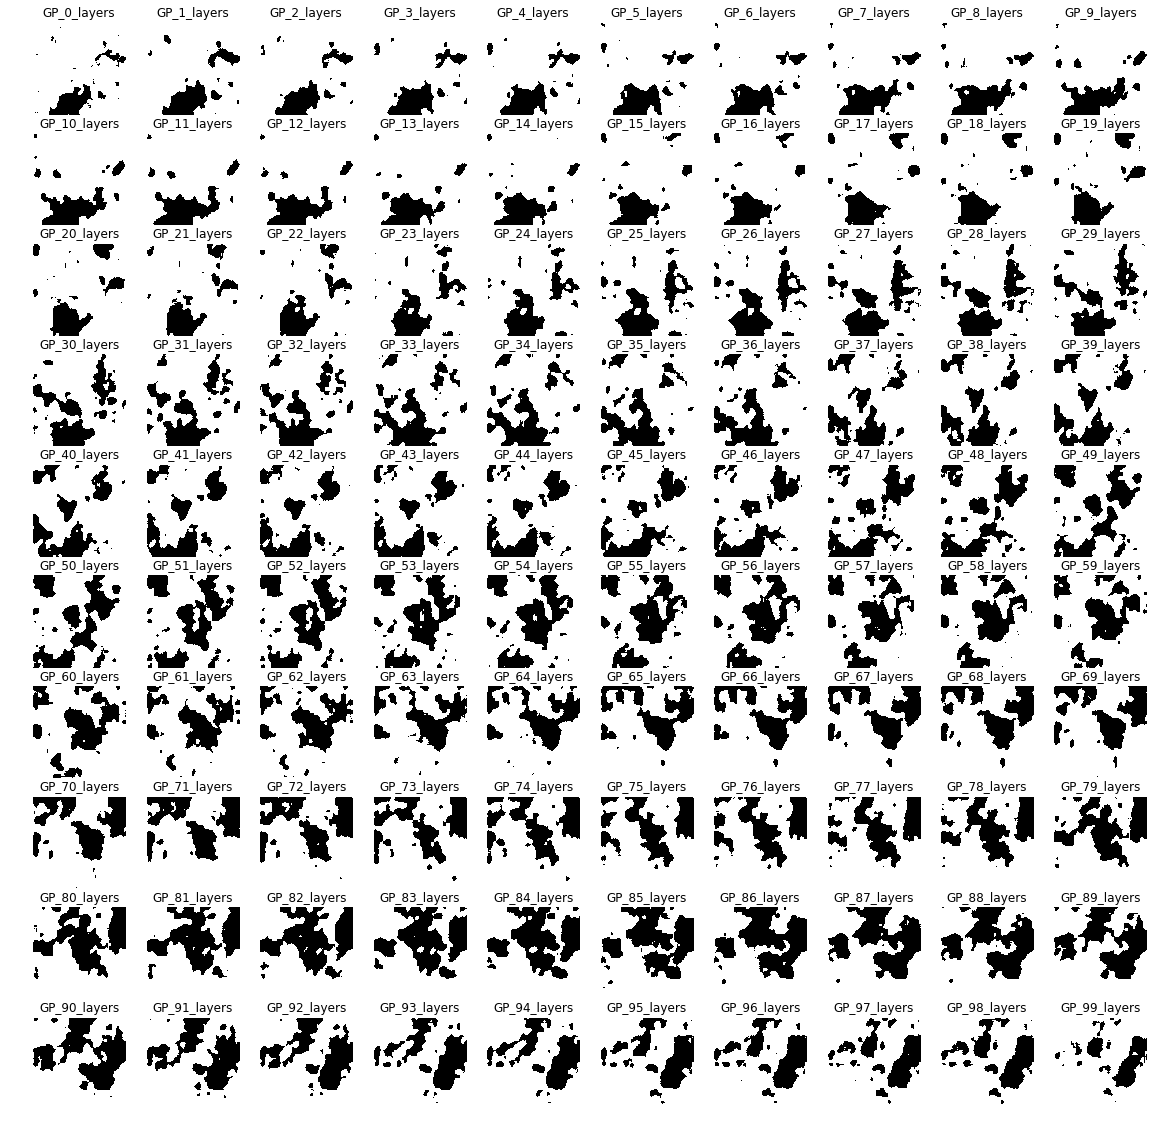

epoch:231  d_loss:[0.17346272 0.9       ]  g_loss:4.047099
epoch:232  d_loss:[0.5806194 0.8      ]  g_loss:6.6367073
epoch:233  d_loss:[1.2662895 0.35     ]  g_loss:4.6541324
epoch:234  d_loss:[0.06994025 0.95      ]  g_loss:3.5649571
epoch:235  d_loss:[3.8331296 0.1      ]  g_loss:2.988668
epoch:236  d_loss:[0.11146884 1.        ]  g_loss:6.2323837
epoch:237  d_loss:[1.5080662 0.25     ]  g_loss:2.2618804
epoch:238  d_loss:[0.18915254 0.95      ]  g_loss:2.527761
epoch:239  d_loss:[0.61122346 0.7       ]  g_loss:5.3866196
epoch:240  d_loss:[0.9112182 0.45     ]  g_loss:3.3365452


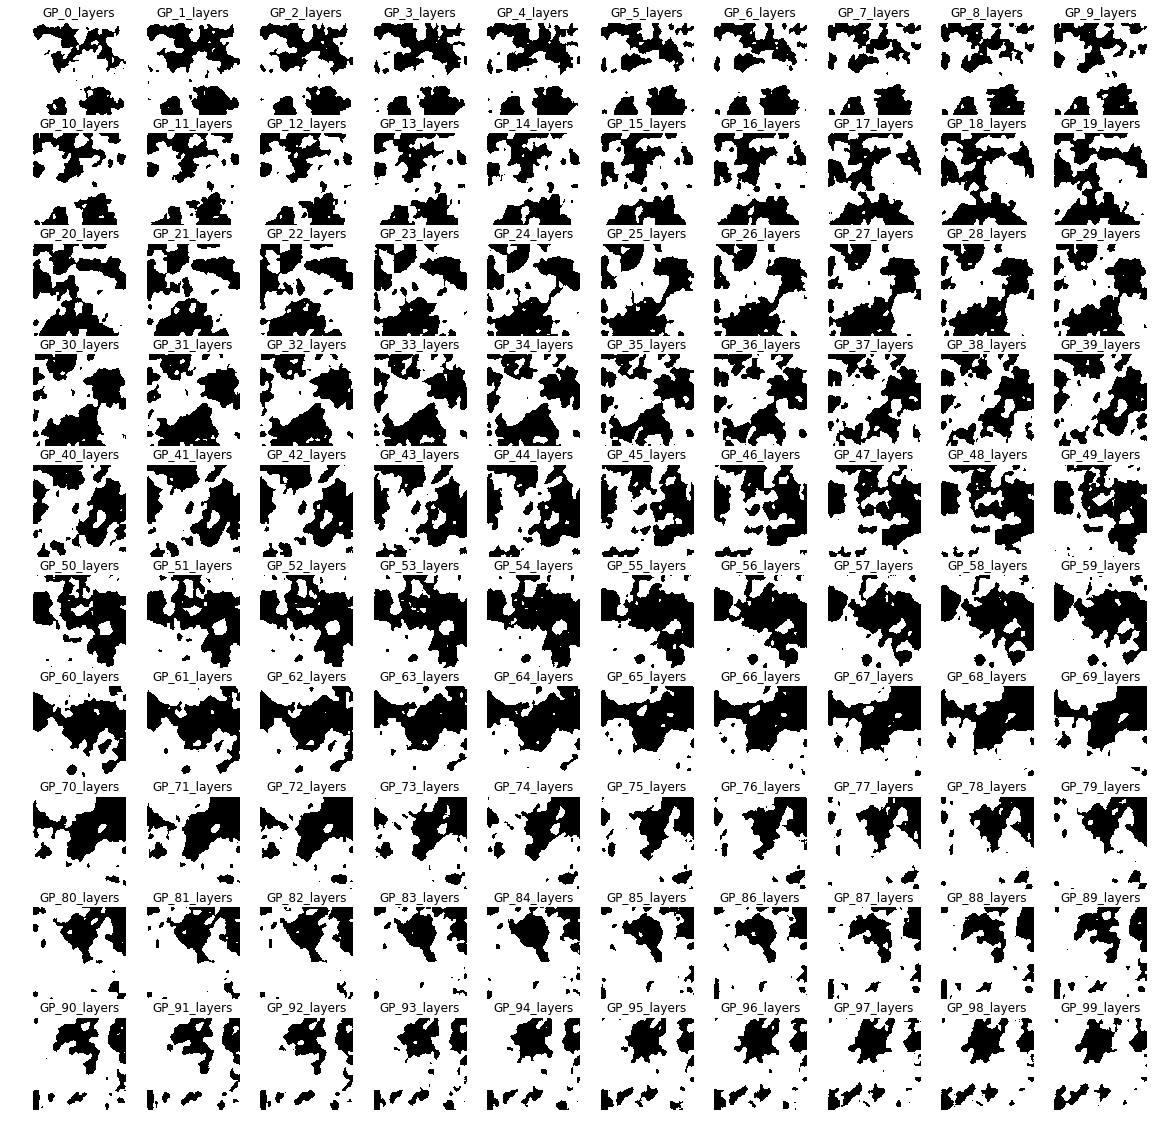

epoch:241  d_loss:[0.7697673 0.65     ]  g_loss:4.7769876
epoch:242  d_loss:[0.40293798 0.85      ]  g_loss:2.9917474
epoch:243  d_loss:[0.39358062 0.75      ]  g_loss:5.0911417
epoch:244  d_loss:[1.3607388 0.45     ]  g_loss:2.5018368
epoch:245  d_loss:[0.10923623 0.95      ]  g_loss:4.9828033
epoch:246  d_loss:[0.30060312 0.95      ]  g_loss:2.9950817
epoch:247  d_loss:[0.28670782 0.9       ]  g_loss:3.7621605
epoch:248  d_loss:[0.35243583 0.9       ]  g_loss:3.1956513
epoch:249  d_loss:[0.2625727 0.85     ]  g_loss:3.4672751
epoch:250  d_loss:[0.132574 1.      ]  g_loss:2.698842


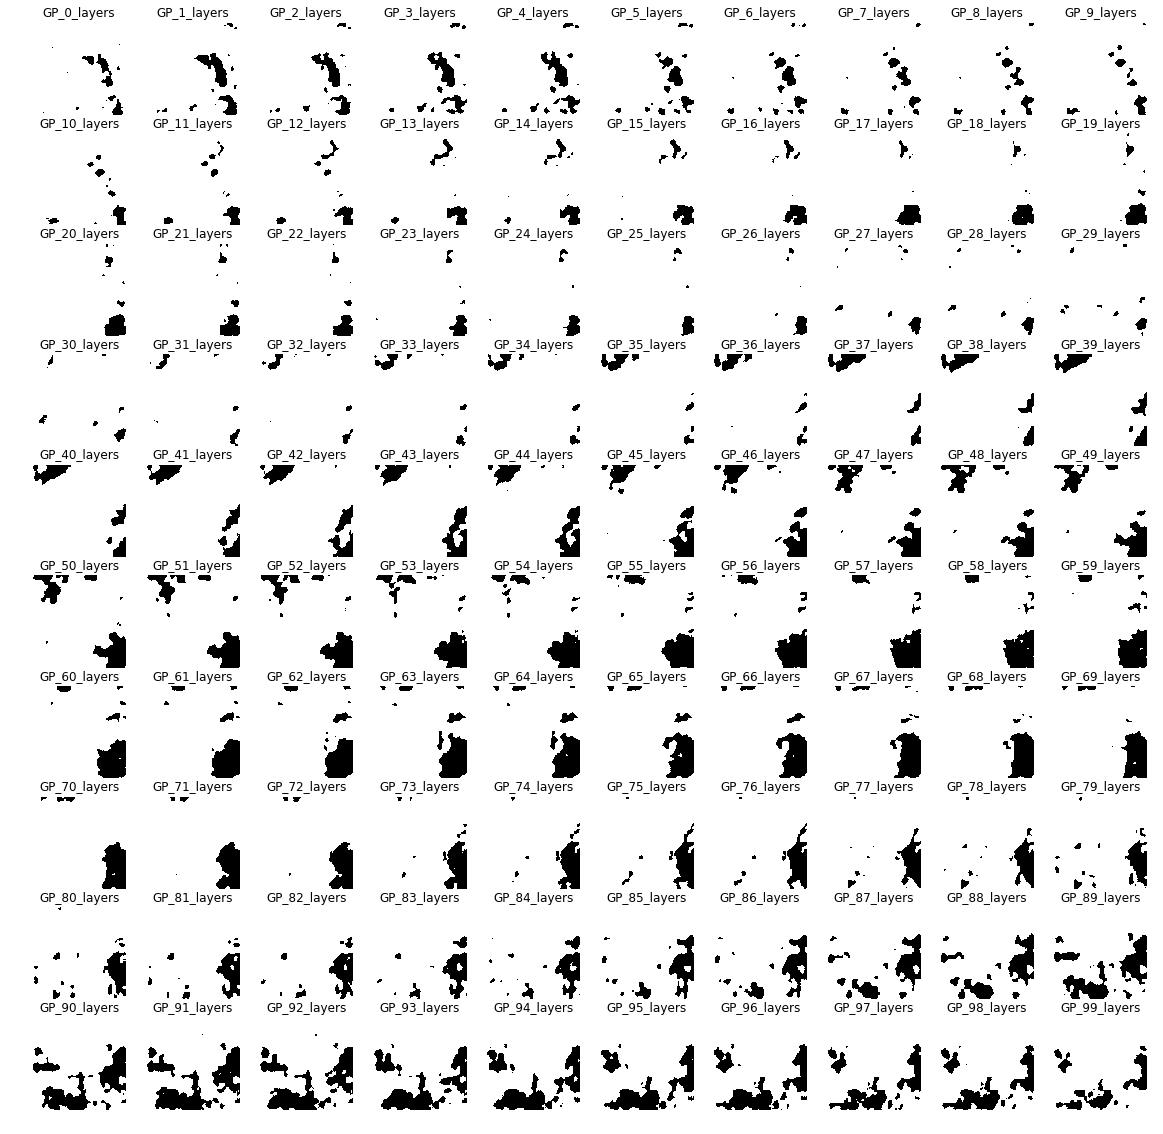

epoch:251  d_loss:[0.07531613 1.        ]  g_loss:3.2629828
epoch:252  d_loss:[0.6535112  0.70000005]  g_loss:4.538171
epoch:253  d_loss:[0.69415826 0.55      ]  g_loss:3.0338767
epoch:254  d_loss:[0.08192803 0.95      ]  g_loss:2.617271
epoch:255  d_loss:[0.40016085 0.8       ]  g_loss:0.6700242
epoch:256  d_loss:[0.5843904 0.75     ]  g_loss:5.6364694
epoch:257  d_loss:[0.76263297 0.75      ]  g_loss:2.9733615
epoch:258  d_loss:[0.36299092 0.75      ]  g_loss:2.7859647
epoch:259  d_loss:[0.17515746 1.        ]  g_loss:3.5516162
epoch:260  d_loss:[0.6110593 0.6      ]  g_loss:3.1302934


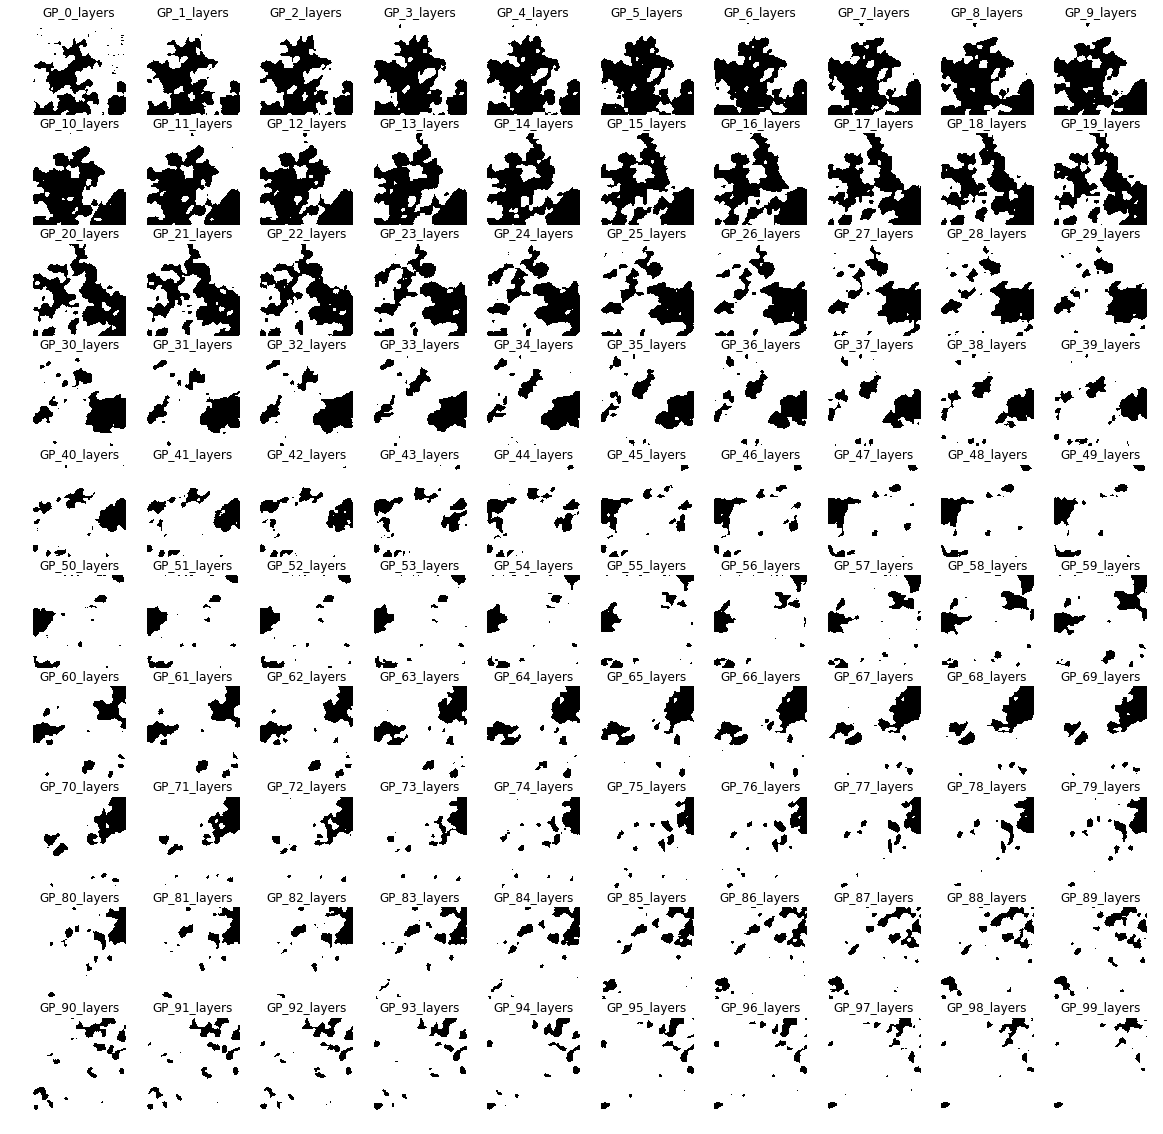

epoch:261  d_loss:[0.28743985 0.95      ]  g_loss:5.400168
epoch:262  d_loss:[1.2987018 0.4      ]  g_loss:1.6069813
epoch:263  d_loss:[0.3507398 0.9      ]  g_loss:5.223792
epoch:264  d_loss:[0.6157891 0.65     ]  g_loss:4.0934963
epoch:265  d_loss:[0.41499174 0.75      ]  g_loss:4.2600913
epoch:266  d_loss:[0.15516388 0.9       ]  g_loss:4.1981335
epoch:267  d_loss:[0.13919567 0.95      ]  g_loss:3.004467
epoch:268  d_loss:[0.18666862 0.95      ]  g_loss:3.471745
epoch:269  d_loss:[0.21039145 0.9       ]  g_loss:2.4245288
epoch:270  d_loss:[0.037917 1.      ]  g_loss:2.109522


epoch:271  d_loss:[0.31194177 0.85      ]  g_loss:6.1833906
epoch:272  d_loss:[1.1348104  0.45000002]  g_loss:4.2847033
epoch:273  d_loss:[0.2992047 0.9      ]  g_loss:3.1369448
epoch:274  d_loss:[0.3046534 0.85     ]  g_loss:5.329511
epoch:275  d_loss:[0.35601008 0.9       ]  g_loss:3.5258293
epoch:276  d_loss:[0.21935691 0.9       ]  g_loss:2.9559884
epoch:277  d_loss:[0.19274794 0.9       ]  g_loss:3.7174766
epoch:278  d_loss:[0.16508666 0.95      ]  g_loss:3.8621292
epoch:279  d_loss:[0.7688749 0.65     ]  g_loss:4.963109
epoch:280  d_loss:[0.55184615 0.7       ]  g_loss:0.96814716


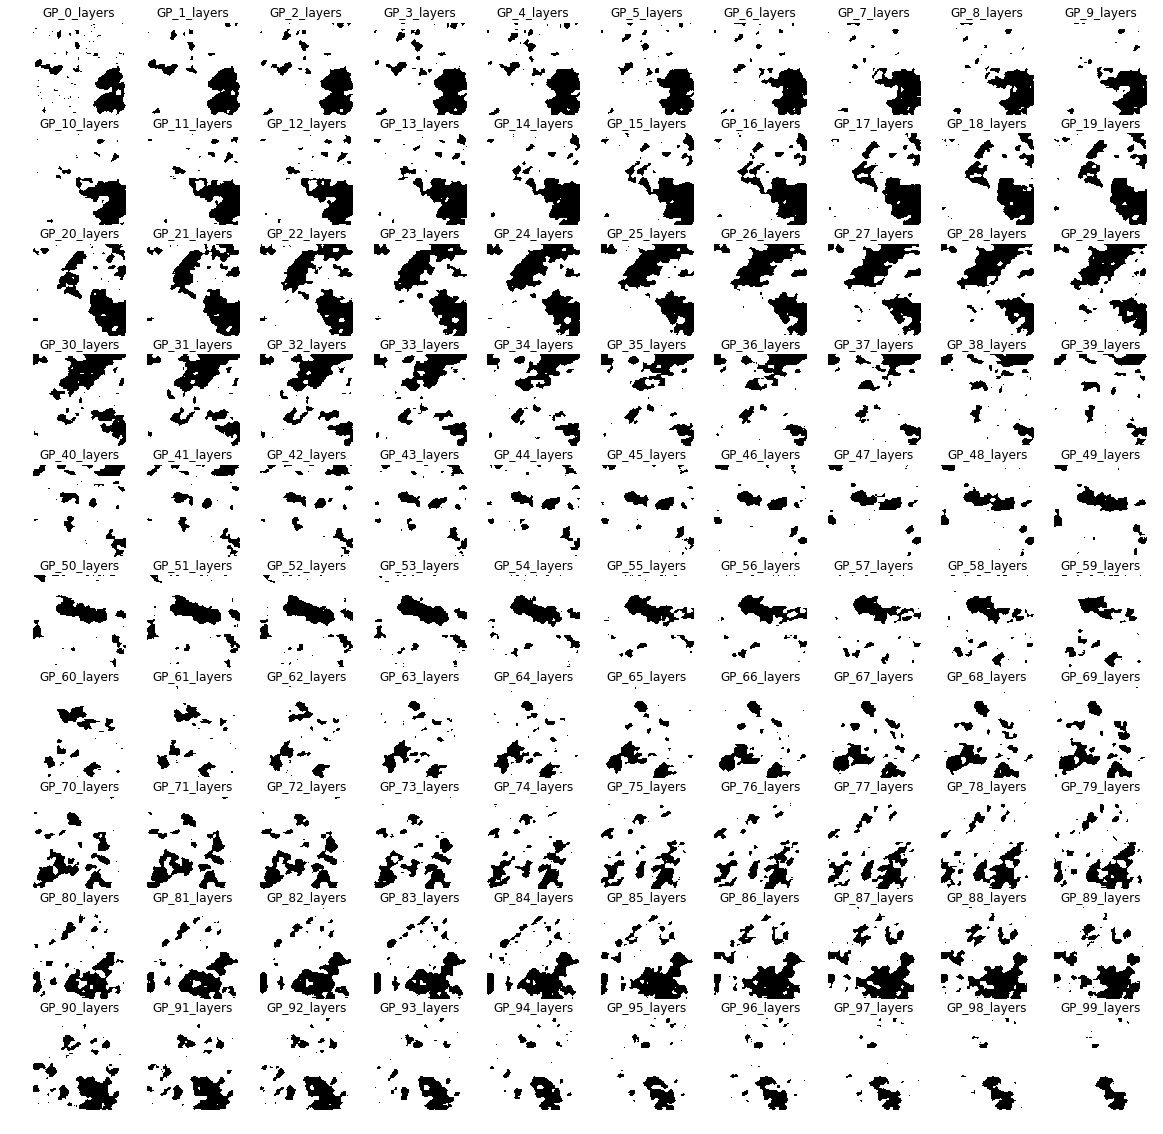

epoch:281  d_loss:[0.9203675 0.6      ]  g_loss:7.067659
epoch:282  d_loss:[1.2513257 0.5      ]  g_loss:3.472229
epoch:283  d_loss:[0.10261847 0.95      ]  g_loss:4.6843796
epoch:284  d_loss:[0.30533916 0.9       ]  g_loss:2.24356
epoch:285  d_loss:[1.1206173 0.4      ]  g_loss:8.943457
epoch:286  d_loss:[2.0632334 0.55     ]  g_loss:1.3650028
epoch:287  d_loss:[0.6589208 0.8      ]  g_loss:6.7449446
epoch:288  d_loss:[0.4960804 0.8      ]  g_loss:2.066317
epoch:289  d_loss:[0.1967445 0.9      ]  g_loss:3.7015324
epoch:290  d_loss:[0.11883333 0.9       ]  g_loss:3.295384


epoch:291  d_loss:[0.29310623 0.95      ]  g_loss:4.148156
epoch:292  d_loss:[0.8244515 0.6      ]  g_loss:3.2850945
epoch:293  d_loss:[0.31086424 0.85      ]  g_loss:3.9918003
epoch:294  d_loss:[0.31744856 0.9       ]  g_loss:3.420266
epoch:295  d_loss:[0.3082403 0.85     ]  g_loss:5.935345
epoch:296  d_loss:[0.6585355 0.65     ]  g_loss:2.953554
epoch:297  d_loss:[0.33934763 0.85      ]  g_loss:5.994012
epoch:298  d_loss:[1.035743 0.55    ]  g_loss:0.6043339
epoch:299  d_loss:[0.8939057 0.6      ]  g_loss:7.535917
epoch:300  d_loss:[0.8264017 0.65     ]  g_loss:3.2480521


epoch:301  d_loss:[0.8699274 0.45     ]  g_loss:2.1750166
epoch:302  d_loss:[0.13486657 0.9       ]  g_loss:5.1817255
epoch:303  d_loss:[0.30177784 0.85      ]  g_loss:4.091366
epoch:304  d_loss:[0.19991899 0.95      ]  g_loss:4.8250775
epoch:305  d_loss:[0.31163403 0.95      ]  g_loss:3.237159
epoch:306  d_loss:[1.0669937 0.5      ]  g_loss:5.7739553
epoch:307  d_loss:[0.42487133 0.75      ]  g_loss:2.2431102
epoch:308  d_loss:[0.20211603 0.95      ]  g_loss:2.039022
epoch:309  d_loss:[0.14164189 0.95      ]  g_loss:3.0063438
epoch:310  d_loss:[0.30190676 0.9       ]  g_loss:2.1797445


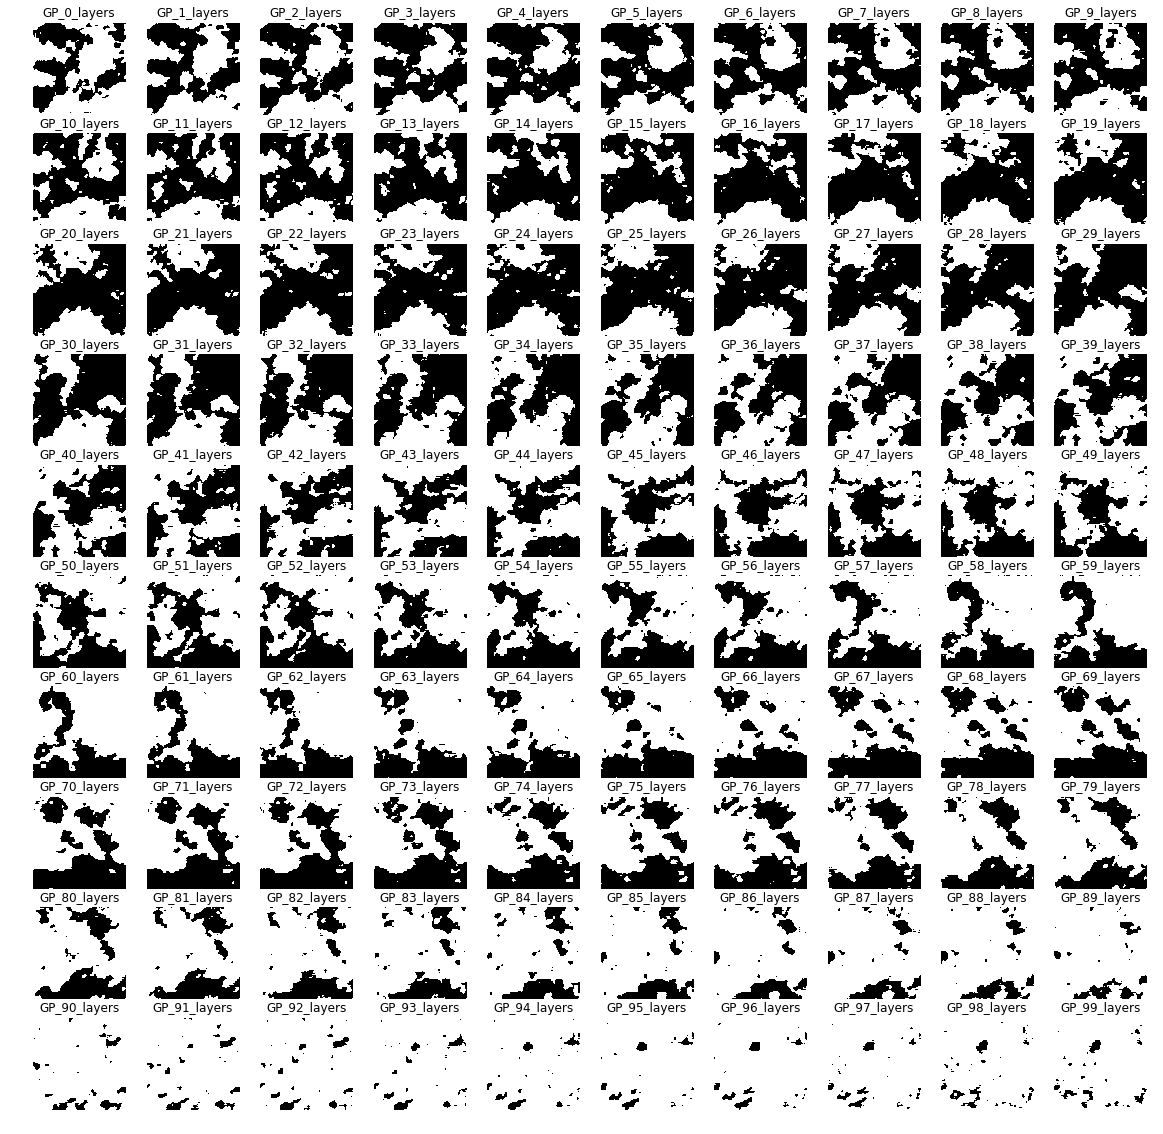

epoch:311  d_loss:[0.1243314 1.       ]  g_loss:3.458784
epoch:312  d_loss:[0.17097528 1.        ]  g_loss:2.9574084
epoch:313  d_loss:[0.7276907 0.6      ]  g_loss:4.9142256
epoch:314  d_loss:[0.6392131 0.6      ]  g_loss:1.6905441
epoch:315  d_loss:[0.09849063 1.        ]  g_loss:3.9499283
epoch:316  d_loss:[0.14687265 0.95      ]  g_loss:2.442511
epoch:317  d_loss:[0.235345 0.9     ]  g_loss:3.8355331
epoch:318  d_loss:[0.47713044 0.7       ]  g_loss:3.9633973
epoch:319  d_loss:[0.2815146 0.9      ]  g_loss:4.172514
epoch:320  d_loss:[0.19528043 0.95      ]  g_loss:5.670179


epoch:321  d_loss:[1.8888801 0.15     ]  g_loss:5.474524
epoch:322  d_loss:[1.2607548 0.5      ]  g_loss:6.6236315
epoch:323  d_loss:[1.3701576 0.55     ]  g_loss:1.0955238
epoch:324  d_loss:[1.0196748 0.5      ]  g_loss:9.497734
epoch:325  d_loss:[2.3288147 0.45     ]  g_loss:1.1103796
epoch:326  d_loss:[1.1047102 0.7      ]  g_loss:5.0607038
epoch:327  d_loss:[0.37498033 0.79999995]  g_loss:4.1489096
epoch:328  d_loss:[1.2045528  0.35000002]  g_loss:2.8319917
epoch:329  d_loss:[0.43121356 0.8       ]  g_loss:4.487073
epoch:330  d_loss:[0.78116584 0.75      ]  g_loss:3.7556317


epoch:331  d_loss:[0.24506551 0.85      ]  g_loss:2.7731357
epoch:332  d_loss:[0.67432165 0.6       ]  g_loss:5.135171
epoch:333  d_loss:[0.6809921 0.85     ]  g_loss:2.1507282
epoch:334  d_loss:[0.35018694 0.9       ]  g_loss:3.8544514
epoch:335  d_loss:[0.22992367 0.85      ]  g_loss:3.0282173
epoch:336  d_loss:[0.38835227 0.79999995]  g_loss:4.3392677
epoch:337  d_loss:[0.7541168 0.7      ]  g_loss:3.6794925
epoch:338  d_loss:[0.3474884 0.85     ]  g_loss:4.586844
epoch:339  d_loss:[0.24372065 0.9       ]  g_loss:3.2869039
epoch:340  d_loss:[0.34592116 0.85      ]  g_loss:4.219717


epoch:341  d_loss:[0.16839658 0.95      ]  g_loss:3.772426
epoch:342  d_loss:[0.36515513 0.79999995]  g_loss:3.8803735
epoch:343  d_loss:[0.1959258 0.95     ]  g_loss:3.6447723
epoch:344  d_loss:[0.29606614 0.9       ]  g_loss:3.8661067
epoch:345  d_loss:[0.2720576 0.95     ]  g_loss:4.3965
epoch:346  d_loss:[1.8253742 0.15     ]  g_loss:5.7440505
epoch:347  d_loss:[1.6871226  0.35000002]  g_loss:7.3262777
epoch:348  d_loss:[1.5184369 0.5      ]  g_loss:0.81189954
epoch:349  d_loss:[2.1613302 0.5      ]  g_loss:5.3367796
epoch:350  d_loss:[1.1795082 0.5      ]  g_loss:3.2043233


epoch:351  d_loss:[2.3691278 0.       ]  g_loss:2.1186752
epoch:352  d_loss:[0.3683592 0.9      ]  g_loss:2.4192898
epoch:353  d_loss:[0.9056444 0.5      ]  g_loss:3.4533253
epoch:354  d_loss:[0.61492646 0.6       ]  g_loss:1.881245
epoch:355  d_loss:[1.076525 0.6     ]  g_loss:4.1486435
epoch:356  d_loss:[1.7092186 0.3      ]  g_loss:3.9315689
epoch:357  d_loss:[0.8275677 0.65     ]  g_loss:4.0193024
epoch:358  d_loss:[2.0702512 0.25     ]  g_loss:3.3741028
epoch:359  d_loss:[1.2784445 0.35     ]  g_loss:1.9921364
epoch:360  d_loss:[0.73583925 0.5       ]  g_loss:3.9007843


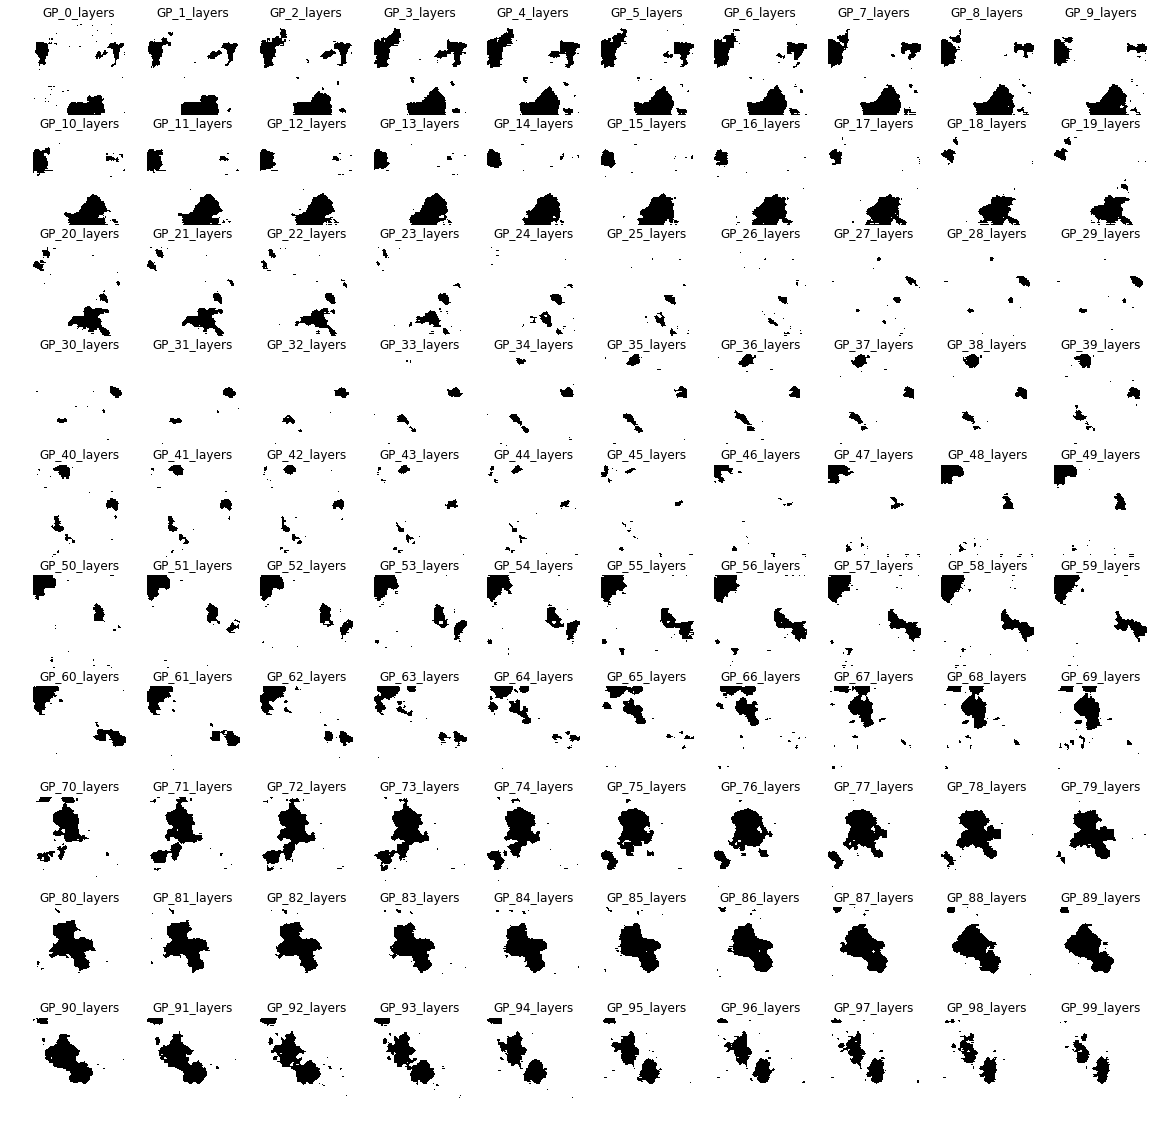

epoch:361  d_loss:[0.71823215 0.75      ]  g_loss:3.0098615
epoch:362  d_loss:[1.0492003  0.45000002]  g_loss:3.3676574
epoch:363  d_loss:[0.90876496 0.55      ]  g_loss:3.3112235
epoch:364  d_loss:[0.9655328 0.6      ]  g_loss:1.051924
epoch:365  d_loss:[0.41003165 0.85      ]  g_loss:4.229018
epoch:366  d_loss:[1.8326213 0.2      ]  g_loss:4.7289267
epoch:367  d_loss:[0.98164964 0.65      ]  g_loss:2.8869145
epoch:368  d_loss:[0.26694685 0.9       ]  g_loss:2.167995
epoch:369  d_loss:[0.23882224 0.9       ]  g_loss:3.113958
epoch:370  d_loss:[0.6799499 0.65     ]  g_loss:1.5777588


epoch:371  d_loss:[0.6773244 0.6      ]  g_loss:6.2810235
epoch:372  d_loss:[1.5830727 0.3      ]  g_loss:2.374228
epoch:373  d_loss:[0.51384795 0.8       ]  g_loss:5.7899427
epoch:374  d_loss:[2.6519194 0.05     ]  g_loss:4.7982736
epoch:375  d_loss:[1.0047648 0.65     ]  g_loss:4.1596437
epoch:376  d_loss:[1.4154856 0.3      ]  g_loss:1.9524025
epoch:377  d_loss:[0.09708901 0.95      ]  g_loss:2.7223575
epoch:378  d_loss:[0.47261596 0.75      ]  g_loss:5.0681314
epoch:379  d_loss:[0.97191507 0.55      ]  g_loss:2.5262399
epoch:380  d_loss:[0.20457 1.     ]  g_loss:1.8187516


epoch:381  d_loss:[0.7851637 0.5      ]  g_loss:2.5827527
epoch:382  d_loss:[0.06447825 1.        ]  g_loss:4.2496424
epoch:383  d_loss:[0.86740404 0.6       ]  g_loss:1.5264168
epoch:384  d_loss:[0.586954 0.8     ]  g_loss:3.6368127
epoch:385  d_loss:[1.9098786 0.2      ]  g_loss:4.060169
epoch:386  d_loss:[0.74156547 0.55      ]  g_loss:4.264873
epoch:387  d_loss:[1.1569569 0.25     ]  g_loss:1.492901
epoch:388  d_loss:[0.41792297 0.75      ]  g_loss:3.9196389
epoch:389  d_loss:[1.0632241 0.45     ]  g_loss:4.3958917
epoch:390  d_loss:[1.7303451 0.25     ]  g_loss:4.538987


epoch:391  d_loss:[0.6353127 0.6      ]  g_loss:2.6665592
epoch:392  d_loss:[0.571895 0.65    ]  g_loss:3.918607
epoch:393  d_loss:[0.8676195 0.5      ]  g_loss:3.8129475
epoch:394  d_loss:[0.75377655 0.5       ]  g_loss:3.476218
epoch:395  d_loss:[0.3759423 0.85     ]  g_loss:3.4547718
epoch:396  d_loss:[0.4599031 0.7      ]  g_loss:2.7144096
epoch:397  d_loss:[0.15853235 0.9       ]  g_loss:2.65861
epoch:398  d_loss:[0.32314545 0.85      ]  g_loss:3.8899186
epoch:399  d_loss:[0.9467602 0.5      ]  g_loss:3.9091606
epoch:400  d_loss:[1.1956801 0.3      ]  g_loss:5.247146


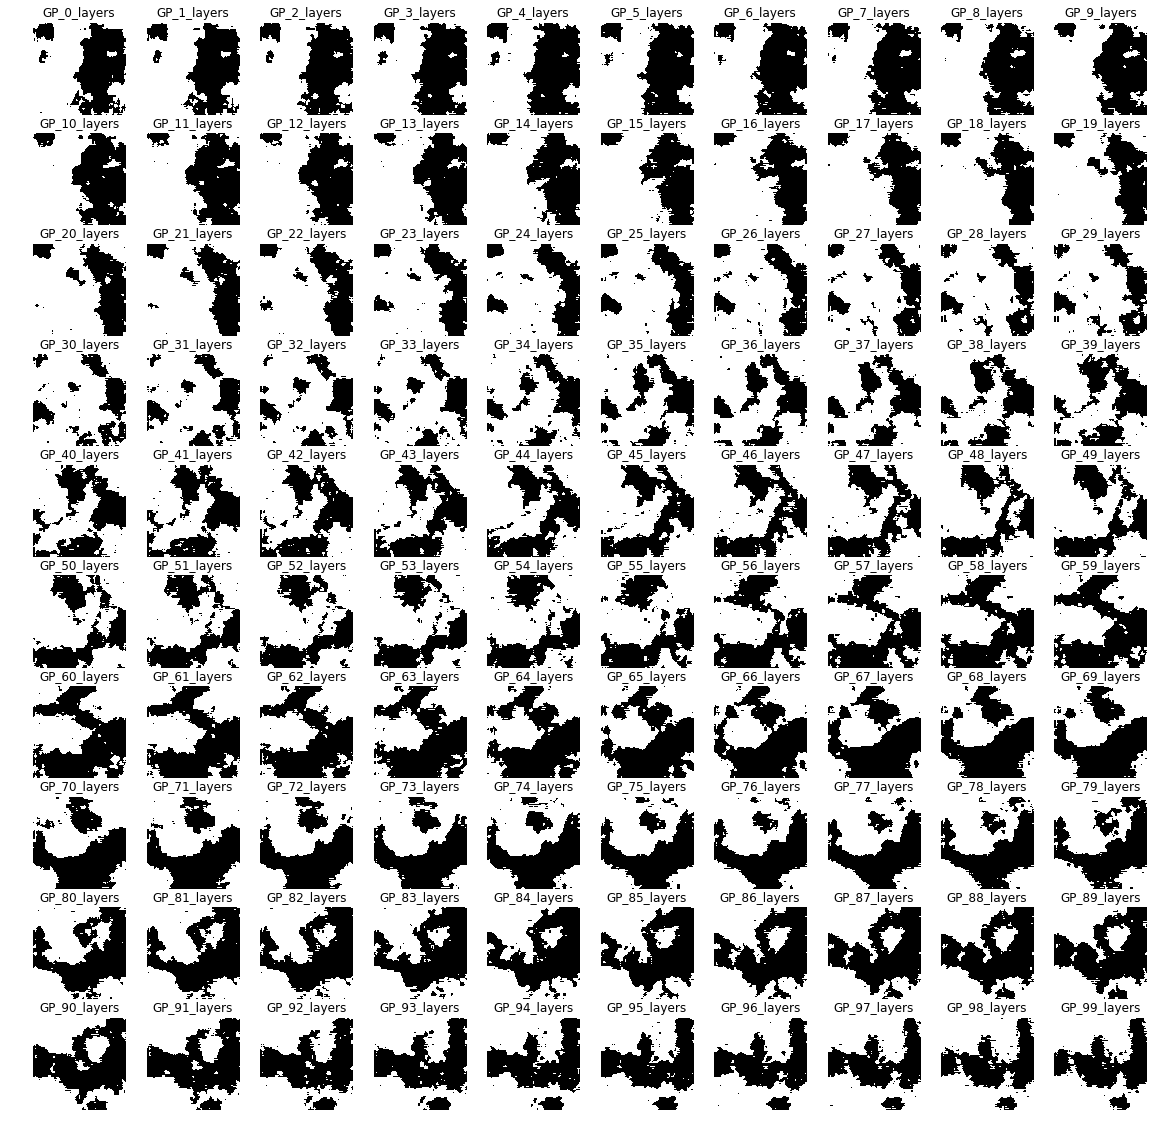

epoch:401  d_loss:[1.2849437 0.3      ]  g_loss:3.047863
epoch:402  d_loss:[0.47824505 0.75      ]  g_loss:3.2243717
epoch:403  d_loss:[0.7022095 0.6      ]  g_loss:3.6277947
epoch:404  d_loss:[0.46255606 0.85      ]  g_loss:2.7042682
epoch:405  d_loss:[0.80999005 0.65      ]  g_loss:5.5022674
epoch:406  d_loss:[1.7079365 0.1      ]  g_loss:3.2404106
epoch:407  d_loss:[0.1086906 0.95     ]  g_loss:5.5100794
epoch:408  d_loss:[2.6628752 0.15     ]  g_loss:3.2492676
epoch:409  d_loss:[0.27042538 0.9       ]  g_loss:3.532946
epoch:410  d_loss:[0.8068319 0.65     ]  g_loss:5.2152834


epoch:411  d_loss:[0.499555 0.8     ]  g_loss:2.169042
epoch:412  d_loss:[0.40734535 0.85      ]  g_loss:2.886816
epoch:413  d_loss:[0.19523719 0.95      ]  g_loss:3.7266774
epoch:414  d_loss:[0.9586638 0.5      ]  g_loss:2.654482
epoch:415  d_loss:[0.37239242 0.85      ]  g_loss:1.6333227
epoch:416  d_loss:[0.34418675 0.8       ]  g_loss:5.4645667
epoch:417  d_loss:[0.9299135 0.45     ]  g_loss:2.1556325
epoch:418  d_loss:[0.75201523 0.5       ]  g_loss:3.5195045
epoch:419  d_loss:[0.39071643 0.75      ]  g_loss:2.8501265
epoch:420  d_loss:[0.935403 0.65    ]  g_loss:3.5039706


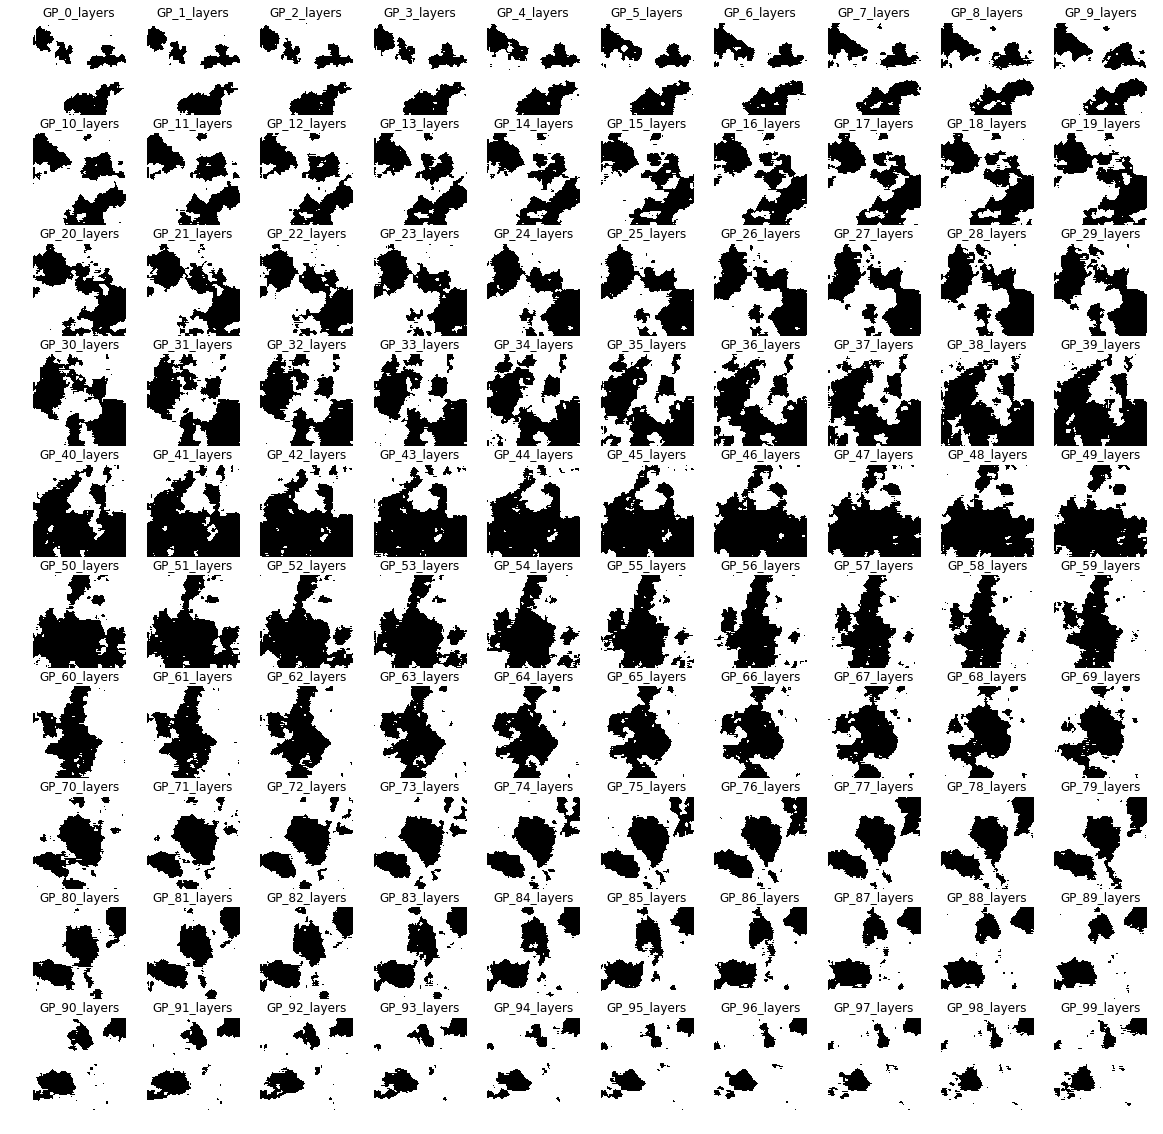

epoch:421  d_loss:[0.25253734 0.95      ]  g_loss:3.6669312
epoch:422  d_loss:[0.28919062 0.9       ]  g_loss:2.8892167
epoch:423  d_loss:[2.2504246 0.05     ]  g_loss:4.1810164
epoch:424  d_loss:[0.16837794 0.9       ]  g_loss:4.2171173
epoch:425  d_loss:[1.2254438 0.4      ]  g_loss:3.446257
epoch:426  d_loss:[0.737588 0.55    ]  g_loss:3.8432858
epoch:427  d_loss:[1.1275418 0.4      ]  g_loss:5.6824694
epoch:428  d_loss:[1.104227 0.65    ]  g_loss:0.5616387
epoch:429  d_loss:[0.04174315 1.        ]  g_loss:0.10993127
epoch:430  d_loss:[0.11451677 0.95      ]  g_loss:0.9023868


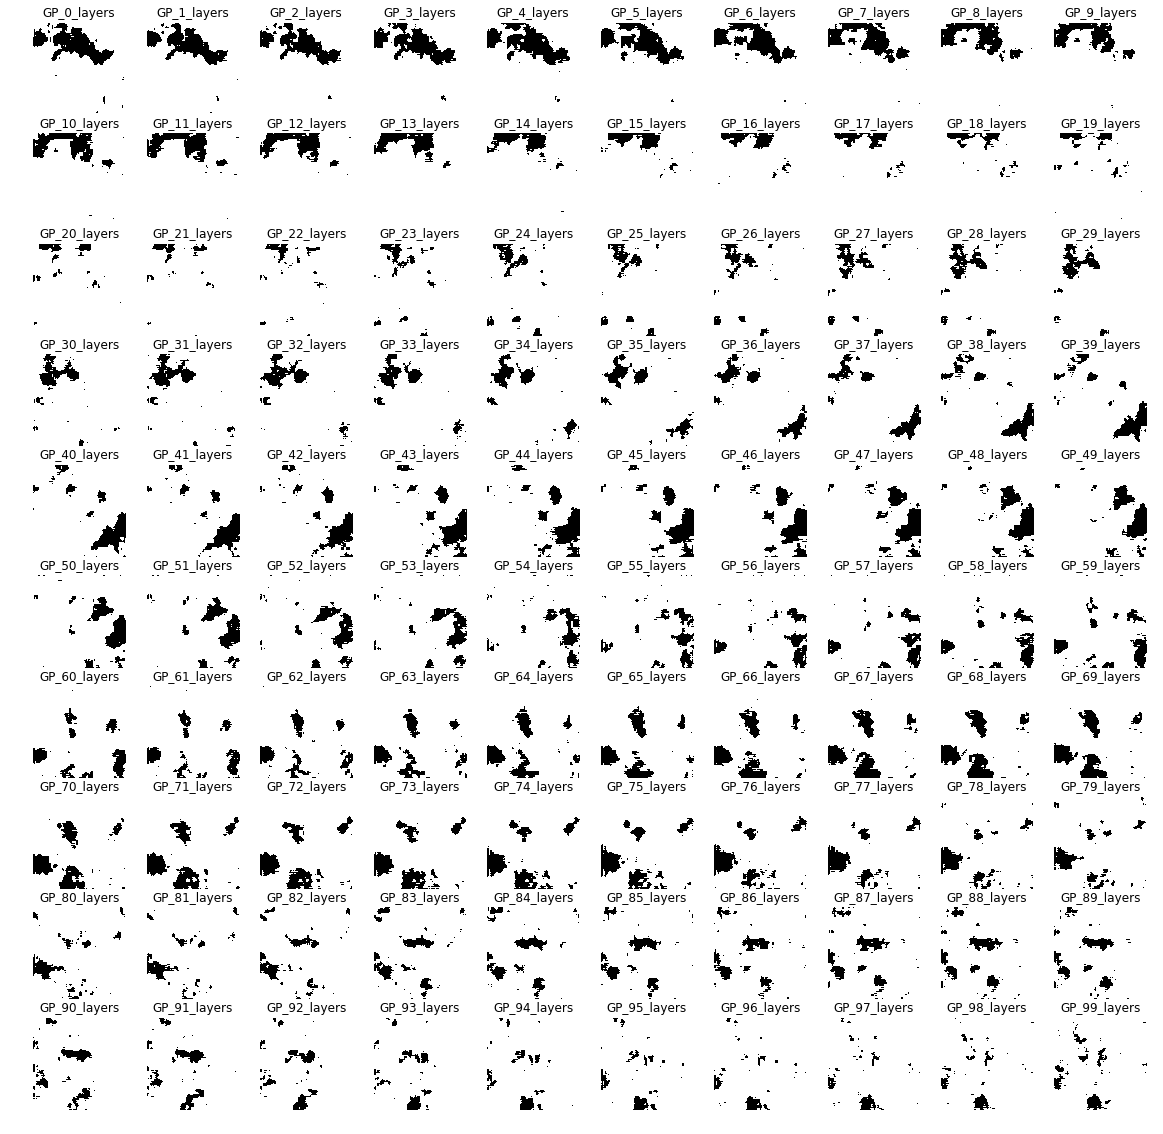

epoch:431  d_loss:[0.70974886 0.6       ]  g_loss:8.08838
epoch:432  d_loss:[1.008623 0.65    ]  g_loss:3.9466794
epoch:433  d_loss:[0.4679985 0.75     ]  g_loss:3.9960601
epoch:434  d_loss:[0.34225392 0.85      ]  g_loss:4.160569
epoch:435  d_loss:[2.475013 0.15    ]  g_loss:5.1479254
epoch:436  d_loss:[0.64895093 0.7       ]  g_loss:2.0313337
epoch:437  d_loss:[1.4774892 0.5      ]  g_loss:4.1695766
epoch:438  d_loss:[2.4362106 0.15     ]  g_loss:2.2853608
epoch:439  d_loss:[0.31053573 0.9       ]  g_loss:5.5809884
epoch:440  d_loss:[1.1561831 0.4      ]  g_loss:3.4749904


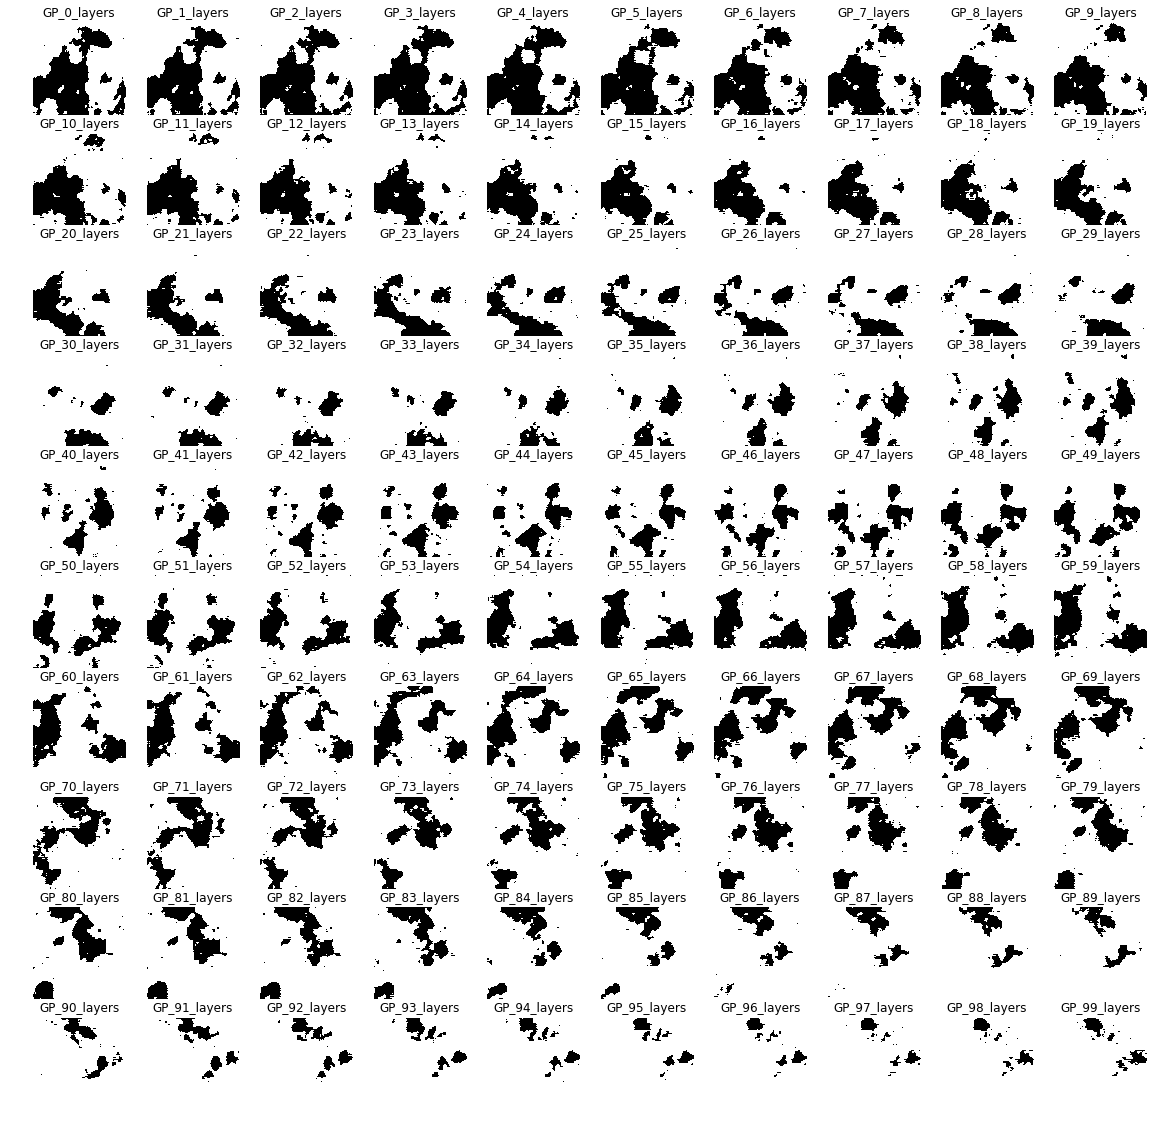

epoch:441  d_loss:[0.86282134 0.4       ]  g_loss:3.6804397
epoch:442  d_loss:[1.0418593 0.4      ]  g_loss:1.8255367
epoch:443  d_loss:[0.39665788 0.79999995]  g_loss:4.062972
epoch:444  d_loss:[0.64938945 0.85      ]  g_loss:1.9042559
epoch:445  d_loss:[0.26478285 0.95      ]  g_loss:2.5536664
epoch:446  d_loss:[0.29673427 0.95      ]  g_loss:3.0441444
epoch:447  d_loss:[0.31877616 0.85      ]  g_loss:2.516254
epoch:448  d_loss:[0.7720819 0.6      ]  g_loss:3.8218417
epoch:449  d_loss:[0.40340868 0.8       ]  g_loss:2.4121447
epoch:450  d_loss:[0.4500109  0.79999995]  g_loss:3.1472354


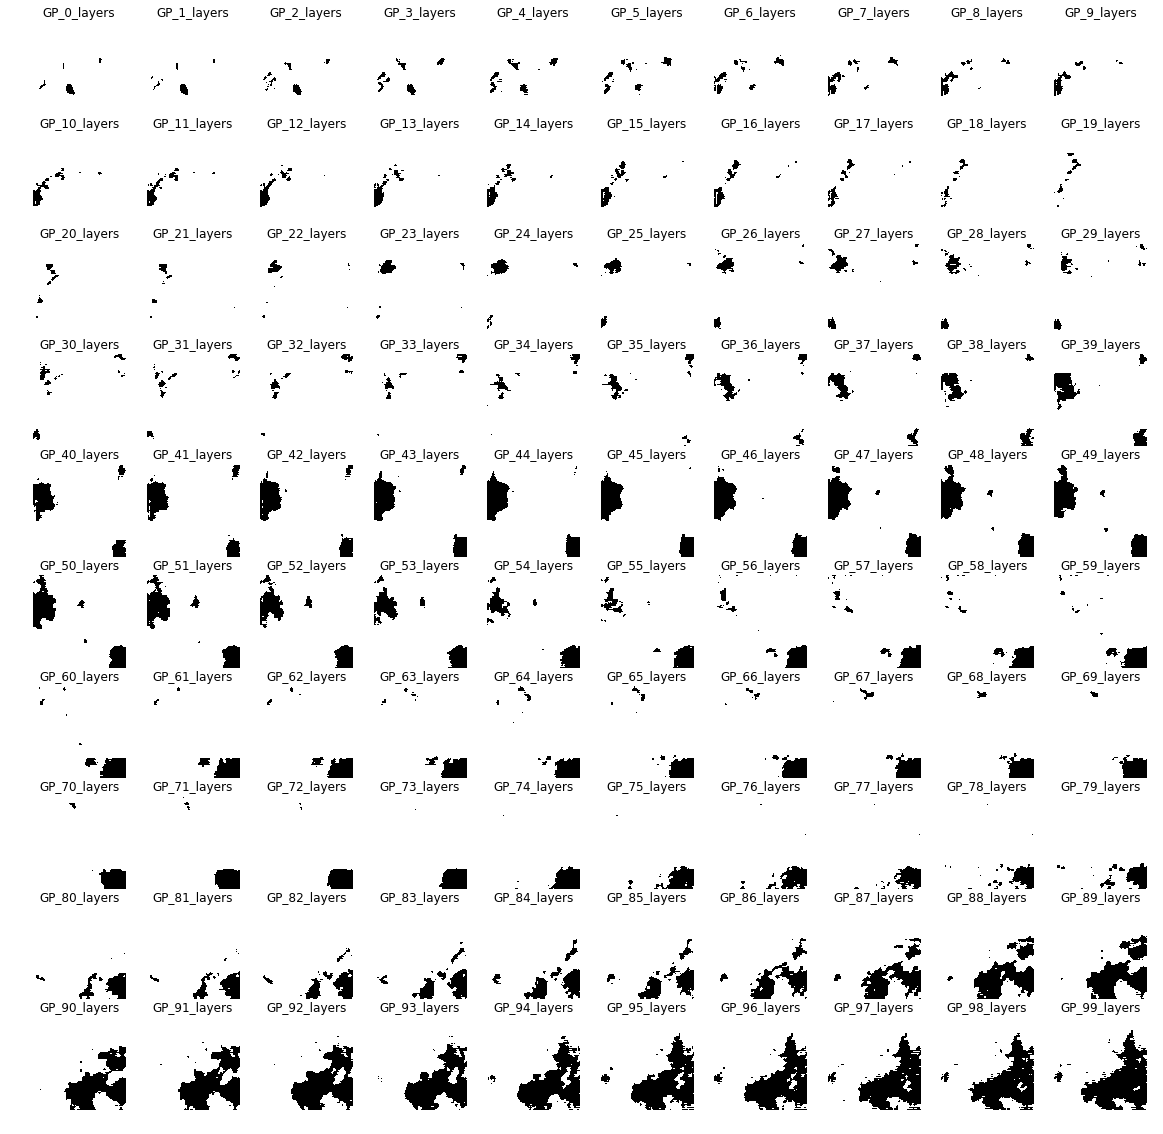

epoch:451  d_loss:[0.5088686 0.75     ]  g_loss:3.1614046
epoch:452  d_loss:[0.39056942 0.8       ]  g_loss:2.945068
epoch:453  d_loss:[0.63358456 0.70000005]  g_loss:4.320118
epoch:454  d_loss:[1.0072229 0.55     ]  g_loss:2.9860737
epoch:455  d_loss:[0.5921401 0.6      ]  g_loss:5.458078
epoch:456  d_loss:[0.52713984 0.85      ]  g_loss:1.9487741
epoch:457  d_loss:[0.14325175 1.        ]  g_loss:2.7078147
epoch:458  d_loss:[0.38159066 0.85      ]  g_loss:3.197314
epoch:459  d_loss:[0.22918704 0.9       ]  g_loss:4.8233595
epoch:460  d_loss:[0.5799446  0.70000005]  g_loss:1.9306196


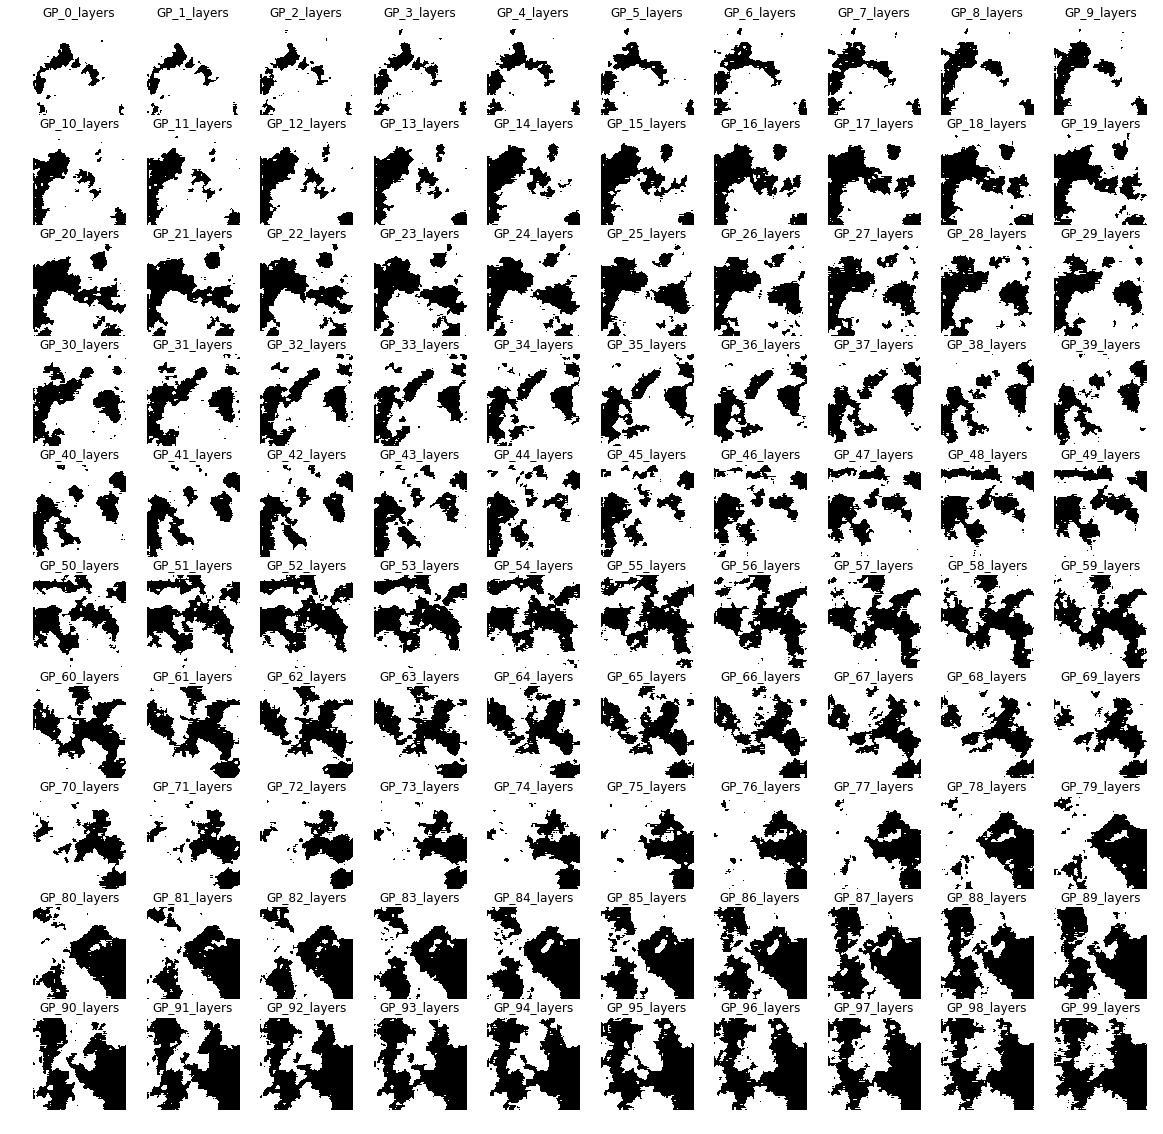

epoch:461  d_loss:[0.3687464  0.79999995]  g_loss:4.3878865
epoch:462  d_loss:[0.91164505 0.4       ]  g_loss:5.119989
epoch:463  d_loss:[0.6813054 0.6      ]  g_loss:0.85771644
epoch:464  d_loss:[0.19440435 0.9       ]  g_loss:6.869307
epoch:465  d_loss:[4.469851 0.05    ]  g_loss:5.305305
epoch:466  d_loss:[0.92884874 0.6       ]  g_loss:5.5654526
epoch:467  d_loss:[1.1792634  0.35000002]  g_loss:4.316496
epoch:468  d_loss:[1.5170939 0.1      ]  g_loss:4.27564
epoch:469  d_loss:[0.51447695 0.75      ]  g_loss:3.5405464
epoch:470  d_loss:[1.3925633 0.35     ]  g_loss:2.4628987


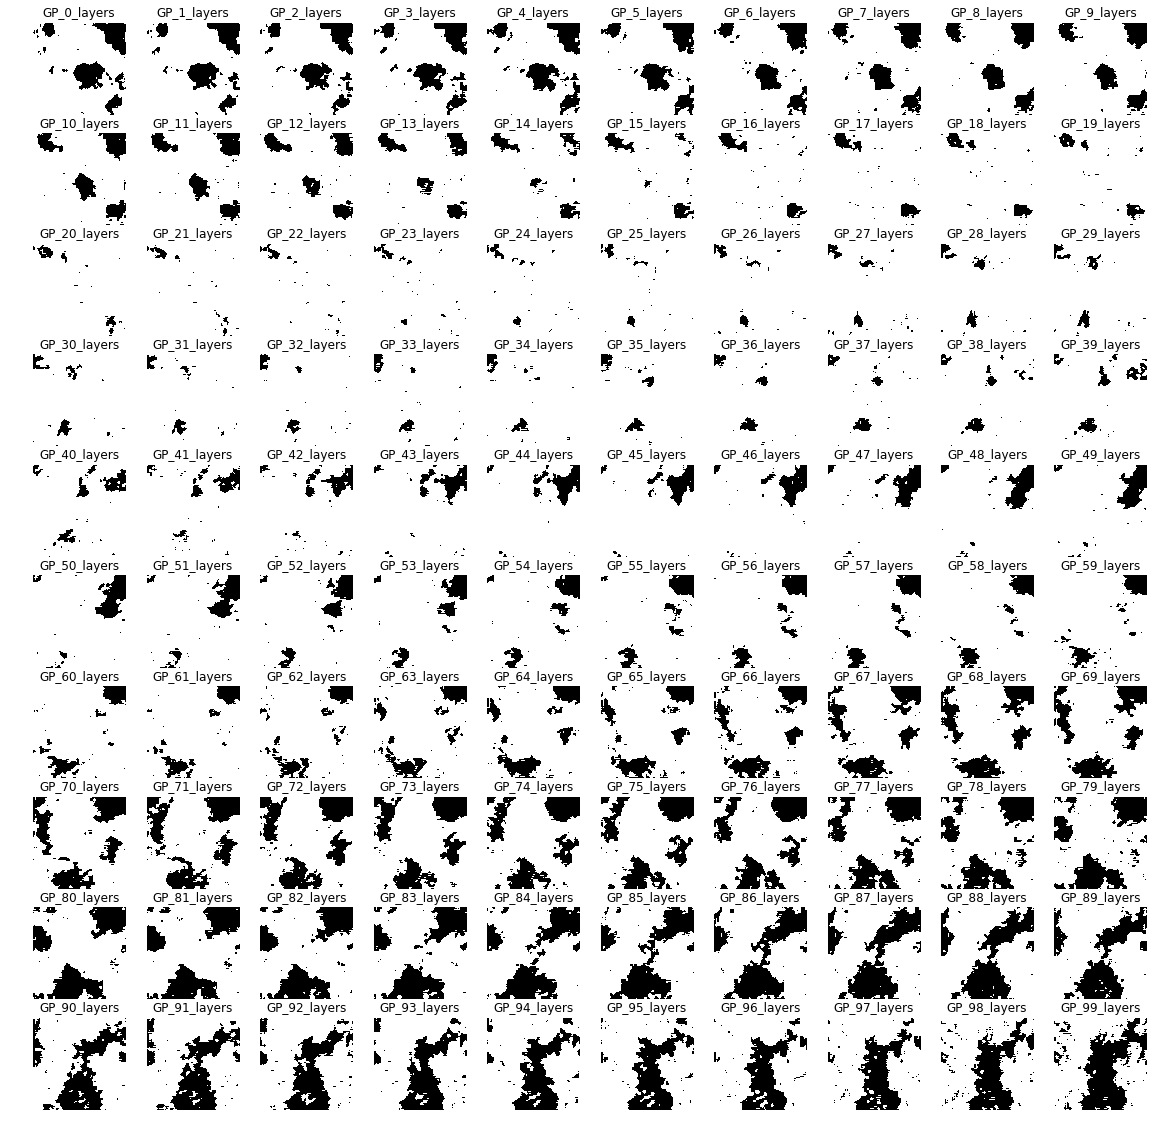

epoch:471  d_loss:[0.3591354 0.9      ]  g_loss:3.937378
epoch:472  d_loss:[2.1688585 0.1      ]  g_loss:1.6367241
epoch:473  d_loss:[0.4811105 0.85     ]  g_loss:4.1253266
epoch:474  d_loss:[0.40921465 0.85      ]  g_loss:3.061889
epoch:475  d_loss:[1.2783445  0.45000002]  g_loss:2.853002
epoch:476  d_loss:[1.1033895 0.4      ]  g_loss:2.6106462
epoch:477  d_loss:[0.8656513 0.5      ]  g_loss:2.7435865
epoch:478  d_loss:[0.8345044 0.55     ]  g_loss:1.7762305
epoch:479  d_loss:[0.5729924 0.8      ]  g_loss:5.047828
epoch:480  d_loss:[1.137538 0.4     ]  g_loss:1.8864841


epoch:481  d_loss:[0.5657278  0.70000005]  g_loss:3.4158623
epoch:482  d_loss:[1.2440681  0.35000002]  g_loss:3.0586853
epoch:483  d_loss:[0.74143034 0.7       ]  g_loss:2.4087505
epoch:484  d_loss:[0.384546 0.85    ]  g_loss:2.7252166
epoch:485  d_loss:[0.3961469 0.8      ]  g_loss:2.4713593
epoch:486  d_loss:[0.44859943 0.75      ]  g_loss:3.4306576
epoch:487  d_loss:[1.8410459 0.1      ]  g_loss:2.8685555
epoch:488  d_loss:[0.19878238 0.9       ]  g_loss:3.7942176
epoch:489  d_loss:[1.953271 0.1     ]  g_loss:2.6206915
epoch:490  d_loss:[0.3866855 0.8      ]  g_loss:3.2462182


epoch:491  d_loss:[0.9758927 0.4      ]  g_loss:2.6901333
epoch:492  d_loss:[0.7996559 0.65     ]  g_loss:2.6777532
epoch:493  d_loss:[0.37840414 0.85      ]  g_loss:2.1280217
epoch:494  d_loss:[0.3063421 0.9      ]  g_loss:2.898227
epoch:495  d_loss:[0.893747 0.45    ]  g_loss:2.870973
epoch:496  d_loss:[0.3208834 0.85     ]  g_loss:2.0143268
epoch:497  d_loss:[0.7160682 0.5      ]  g_loss:3.3720703
epoch:498  d_loss:[0.779017 0.45    ]  g_loss:1.8585556
epoch:499  d_loss:[0.3657432 0.85     ]  g_loss:3.507172
epoch:500  d_loss:[0.38341773 0.8       ]  g_loss:1.1366993


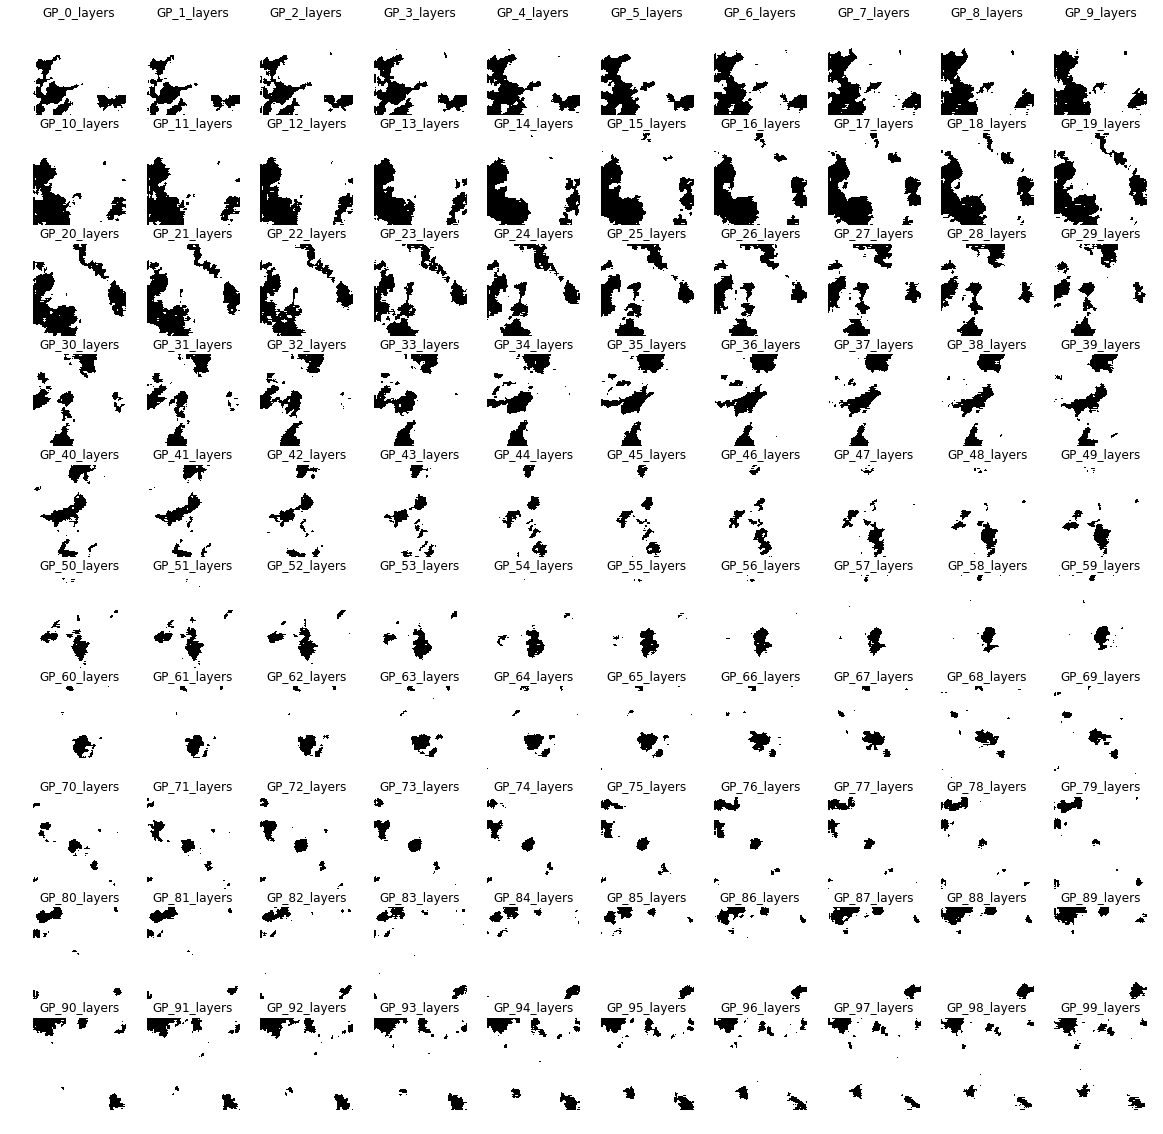

epoch:501  d_loss:[0.7428709 0.65     ]  g_loss:5.29136
epoch:502  d_loss:[1.401688 0.35    ]  g_loss:1.1261108
epoch:503  d_loss:[0.99644554 0.4       ]  g_loss:4.5382257
epoch:504  d_loss:[1.2063923 0.2      ]  g_loss:3.0726788
epoch:505  d_loss:[0.3173104  0.79999995]  g_loss:4.496842
epoch:506  d_loss:[1.2084312  0.45000002]  g_loss:0.7580906
epoch:507  d_loss:[1.036949 0.55    ]  g_loss:5.325261
epoch:508  d_loss:[1.5514045 0.25     ]  g_loss:4.29927
epoch:509  d_loss:[0.7615258 0.7      ]  g_loss:2.597057
epoch:510  d_loss:[0.84678674 0.55      ]  g_loss:5.013833


epoch:511  d_loss:[2.3601005 0.15     ]  g_loss:2.838759
epoch:512  d_loss:[0.39168626 0.9       ]  g_loss:2.829955
epoch:513  d_loss:[0.6287985 0.65     ]  g_loss:2.6911604
epoch:514  d_loss:[0.5079295 0.7      ]  g_loss:3.5551643
epoch:515  d_loss:[1.3165655 0.35     ]  g_loss:3.7312503
epoch:516  d_loss:[0.45742851 0.8       ]  g_loss:3.1747177
epoch:517  d_loss:[1.9119502 0.15     ]  g_loss:3.3250072
epoch:518  d_loss:[0.2583022 0.95     ]  g_loss:3.2832942
epoch:519  d_loss:[1.0565529 0.55     ]  g_loss:2.8607316
epoch:520  d_loss:[0.22169243 0.85      ]  g_loss:2.5003262


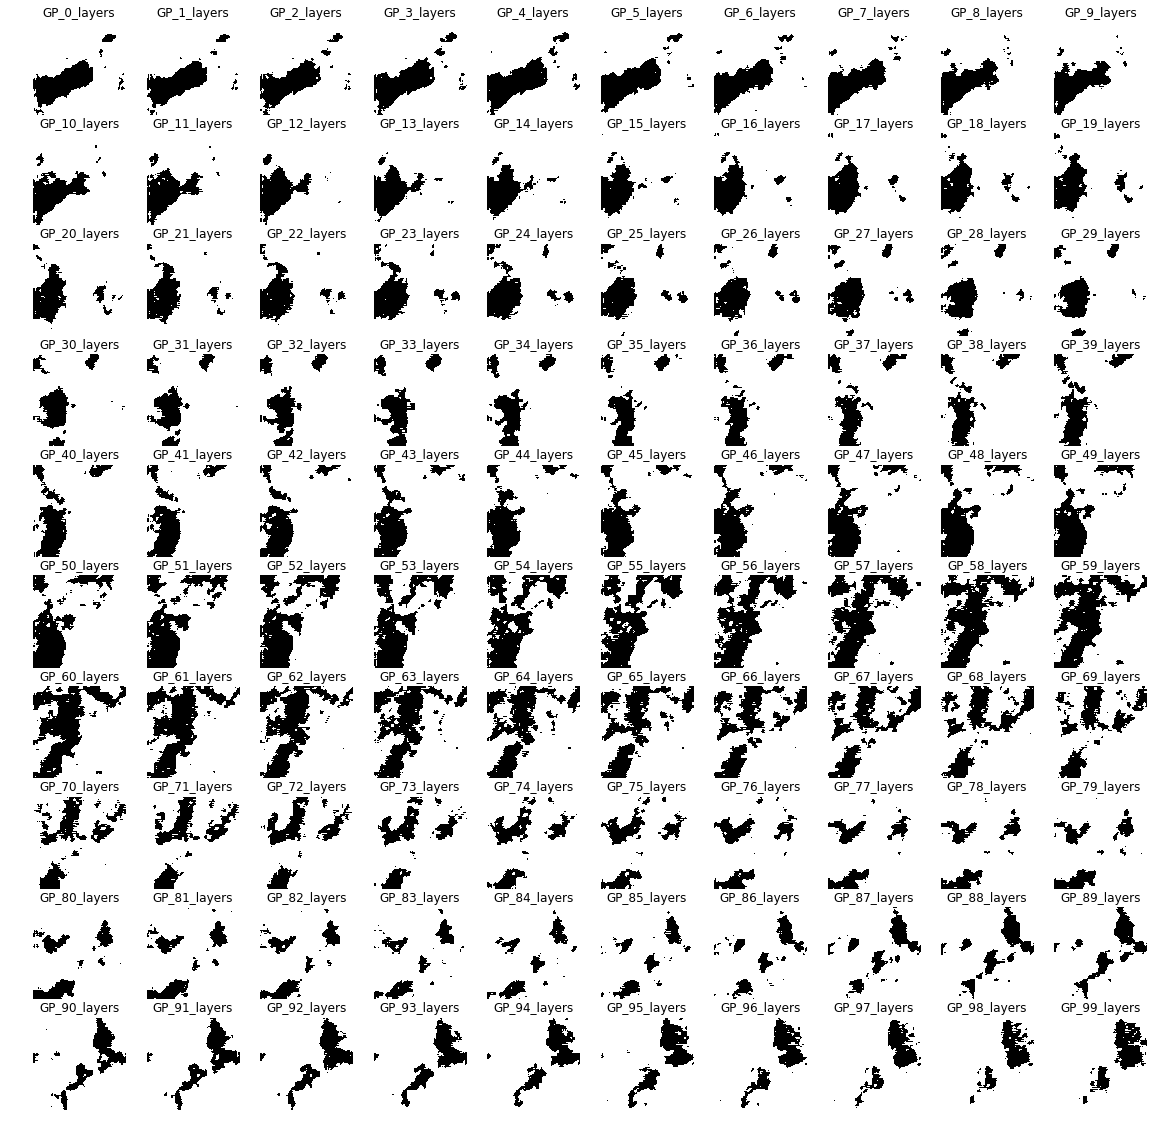

epoch:521  d_loss:[0.2842992 0.85     ]  g_loss:1.3883562
epoch:522  d_loss:[0.12359945 1.        ]  g_loss:2.7336254
epoch:523  d_loss:[0.57092816 0.7       ]  g_loss:3.185183
epoch:524  d_loss:[0.3207168 0.85     ]  g_loss:2.2736576
epoch:525  d_loss:[0.84295094 0.55      ]  g_loss:3.2082336
epoch:526  d_loss:[0.48144087 0.75      ]  g_loss:1.8017628
epoch:527  d_loss:[0.48152763 0.7       ]  g_loss:3.5788014
epoch:528  d_loss:[0.21201757 0.95      ]  g_loss:3.5623345
epoch:529  d_loss:[1.2977616 0.3      ]  g_loss:2.8304038
epoch:530  d_loss:[0.13782528 1.        ]  g_loss:3.847824


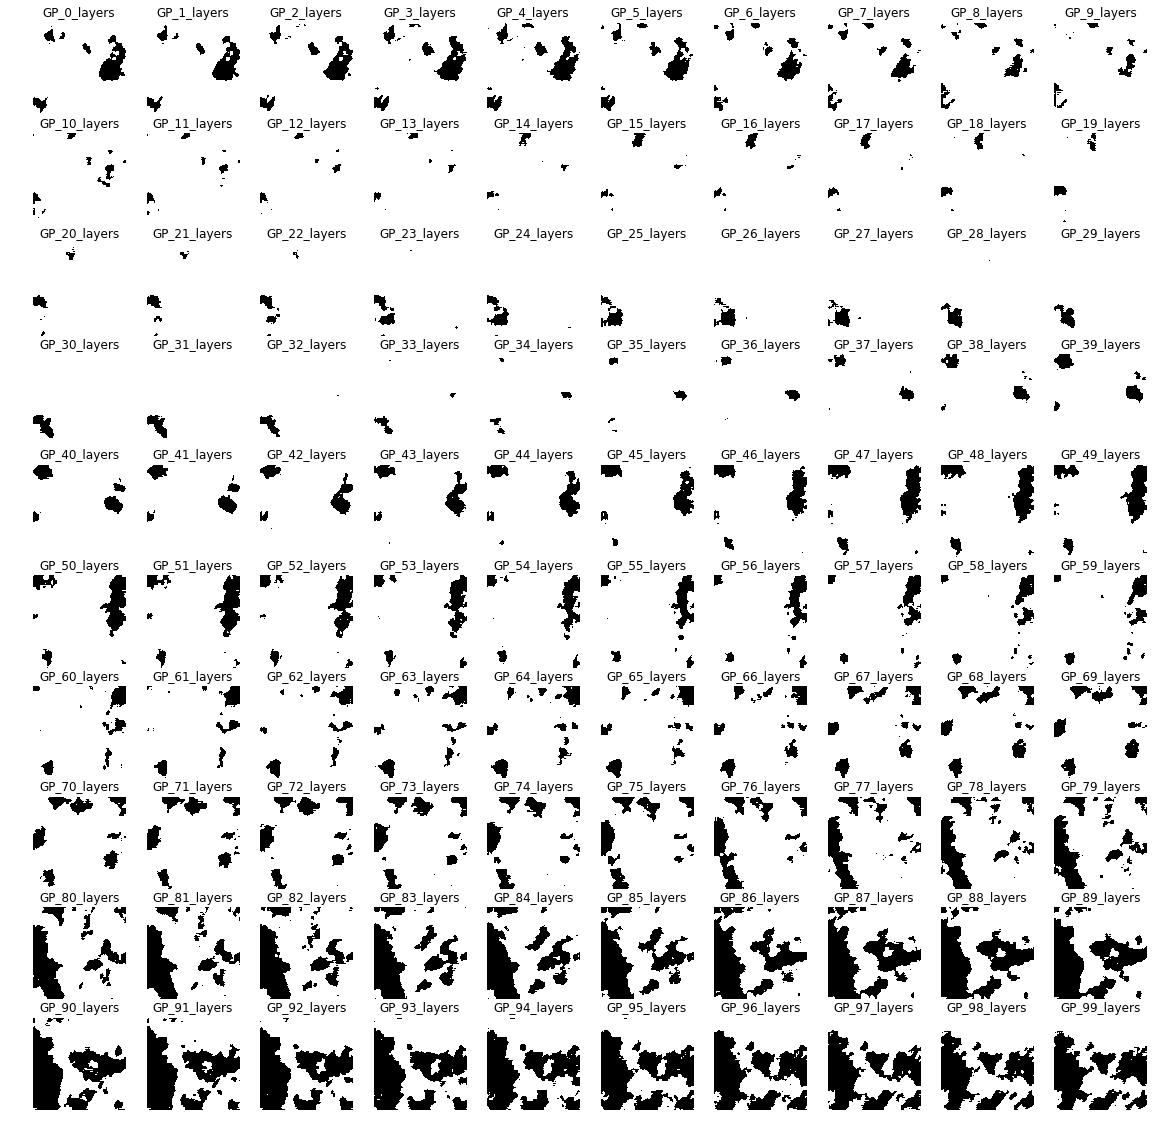

epoch:531  d_loss:[1.5527537 0.2      ]  g_loss:3.3327534
epoch:532  d_loss:[0.13099241 1.        ]  g_loss:5.124974
epoch:533  d_loss:[1.164828 0.4     ]  g_loss:2.4462907
epoch:534  d_loss:[0.73198247 0.6       ]  g_loss:3.2180374
epoch:535  d_loss:[0.3217307 0.85     ]  g_loss:3.7219822
epoch:536  d_loss:[0.17186439 0.95      ]  g_loss:4.40021
epoch:537  d_loss:[0.57082784 0.65      ]  g_loss:4.4596677
epoch:538  d_loss:[0.24447846 0.9       ]  g_loss:1.7717237
epoch:539  d_loss:[0.40735662 0.85      ]  g_loss:3.2812104
epoch:540  d_loss:[0.04172274 1.        ]  g_loss:4.0138845


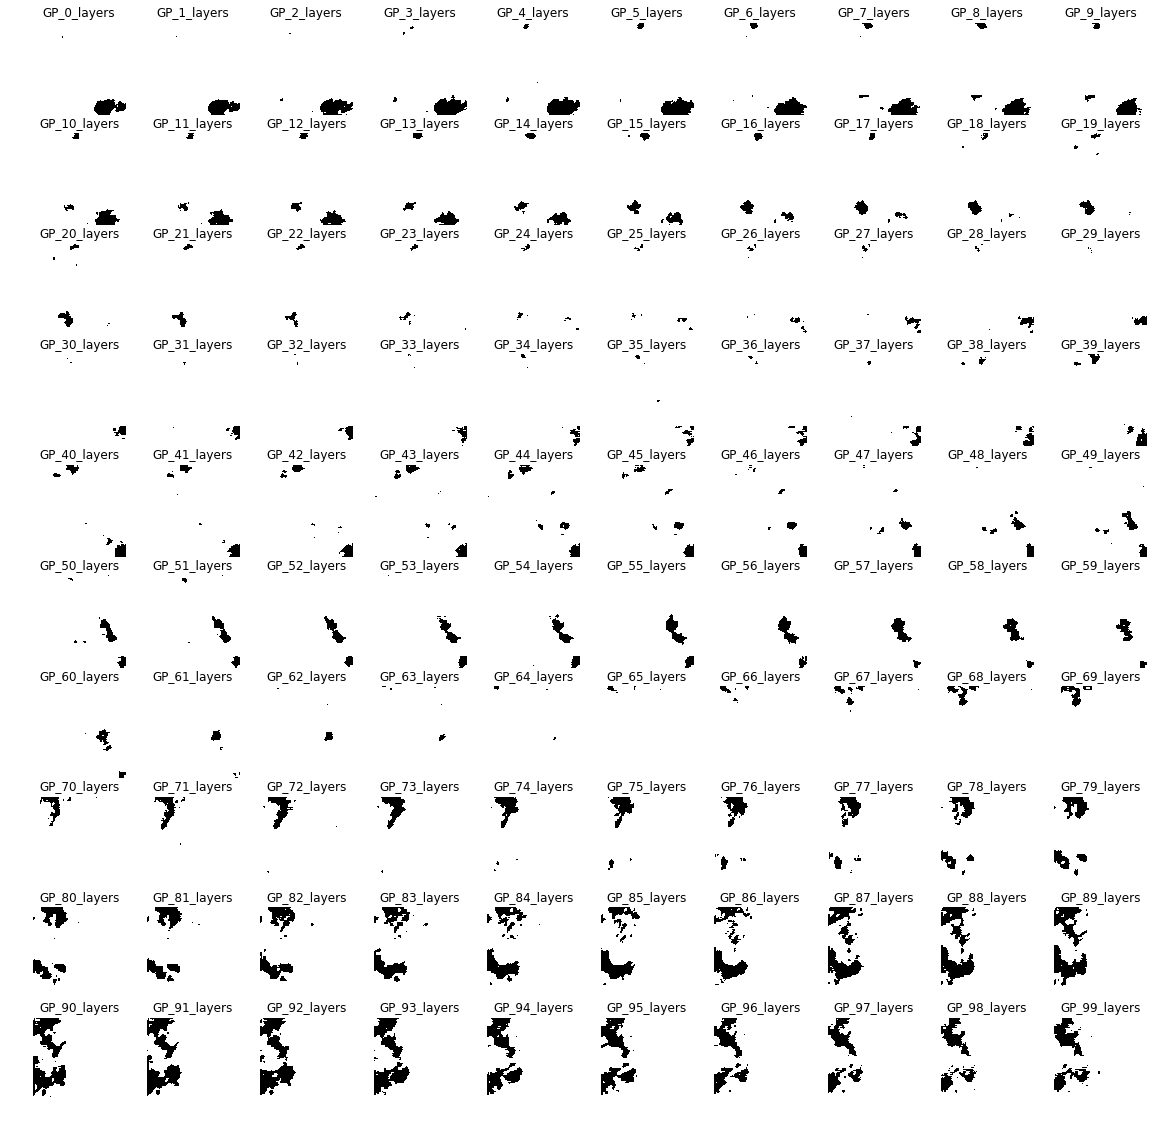

epoch:541  d_loss:[0.6439127  0.70000005]  g_loss:3.950339
epoch:542  d_loss:[0.27817297 0.9       ]  g_loss:3.0836236
epoch:543  d_loss:[0.28538412 0.79999995]  g_loss:3.112781
epoch:544  d_loss:[0.48237166 0.85      ]  g_loss:5.3743157
epoch:545  d_loss:[0.6642909 0.6      ]  g_loss:1.0462233
epoch:546  d_loss:[0.08517095 0.95      ]  g_loss:2.5036216
epoch:547  d_loss:[0.22126925 0.95      ]  g_loss:3.146189
epoch:548  d_loss:[1.5288937 0.2      ]  g_loss:4.804578
epoch:549  d_loss:[1.0803288 0.35     ]  g_loss:6.613959
epoch:550  d_loss:[1.238066 0.4     ]  g_loss:6.2939215


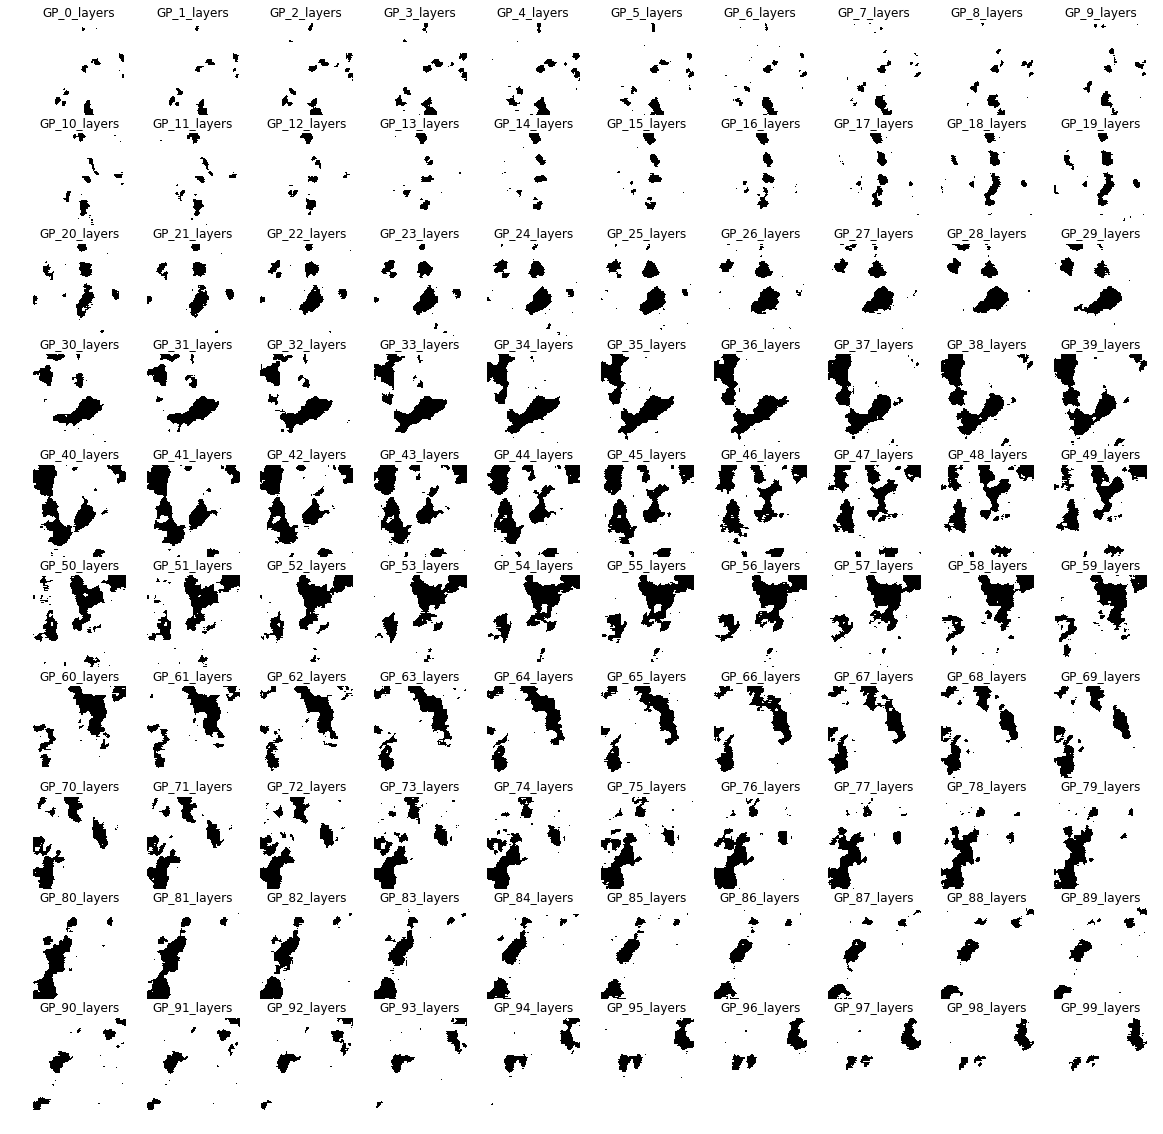

epoch:551  d_loss:[0.27784854 0.95      ]  g_loss:4.312777
epoch:552  d_loss:[0.73184276 0.65      ]  g_loss:6.392915
epoch:553  d_loss:[2.516348 0.05    ]  g_loss:3.337125
epoch:554  d_loss:[0.07204542 1.        ]  g_loss:5.2197657
epoch:555  d_loss:[0.8392254 0.55     ]  g_loss:4.2273417
epoch:556  d_loss:[0.876271 0.55    ]  g_loss:3.9783356
epoch:557  d_loss:[0.3512876  0.79999995]  g_loss:3.427333
epoch:558  d_loss:[0.5340648 0.6      ]  g_loss:1.8547394
epoch:559  d_loss:[0.2501614 0.85     ]  g_loss:5.6022744
epoch:560  d_loss:[0.46155643 0.79999995]  g_loss:1.7924595


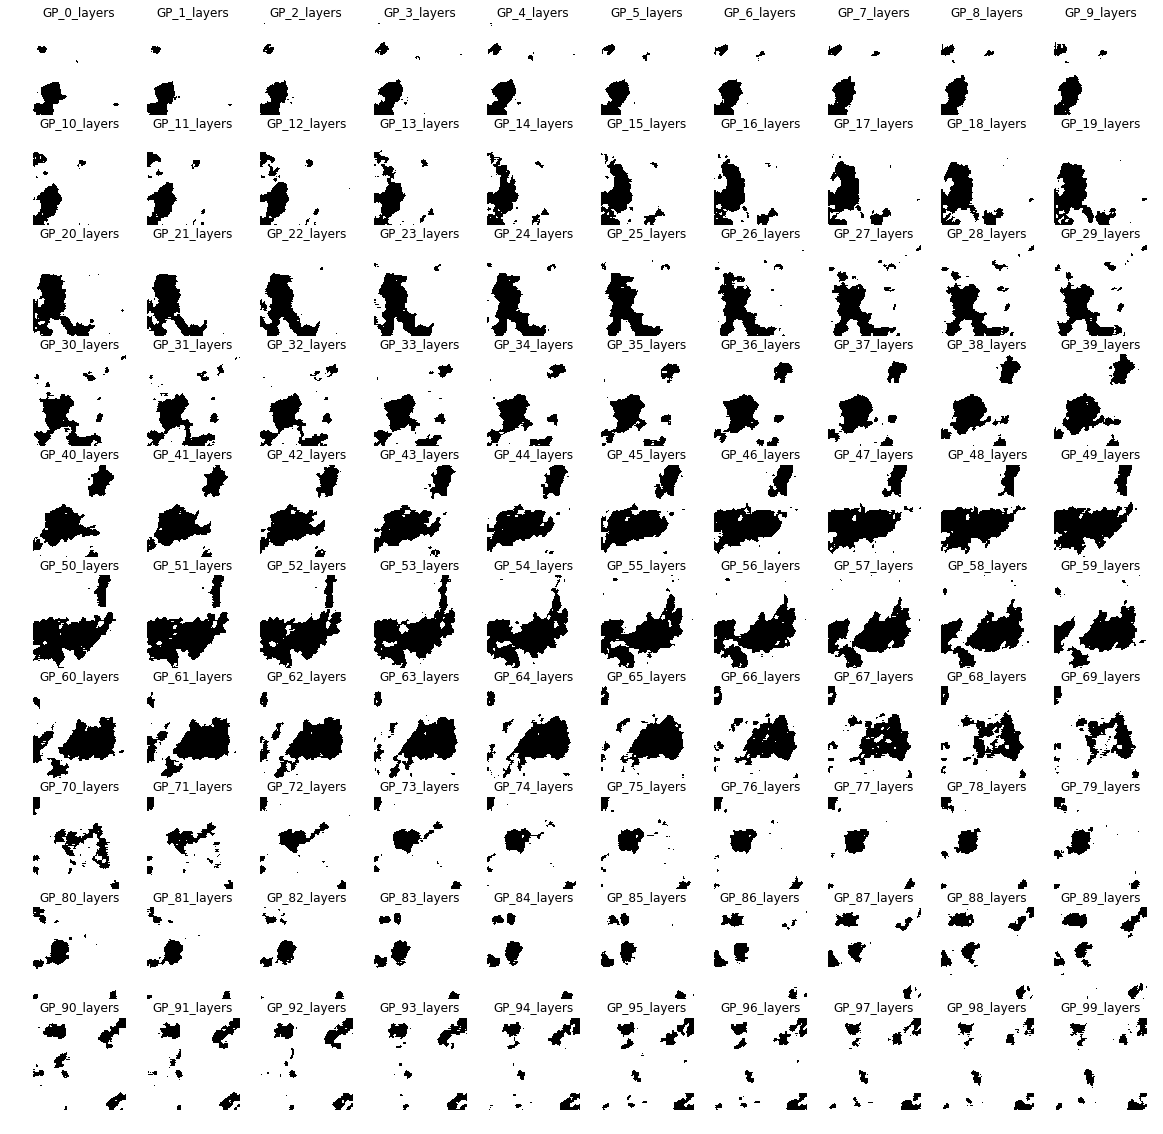

epoch:561  d_loss:[0.6747604 0.7      ]  g_loss:5.3735075
epoch:562  d_loss:[0.7614165 0.75     ]  g_loss:2.0041687
epoch:563  d_loss:[0.5560053 0.8      ]  g_loss:5.4040804
epoch:564  d_loss:[0.61553246 0.70000005]  g_loss:4.011792
epoch:565  d_loss:[0.240006 0.85    ]  g_loss:1.5848747
epoch:566  d_loss:[0.32158497 0.9       ]  g_loss:5.1417236
epoch:567  d_loss:[0.43902326 0.75      ]  g_loss:2.8469672
epoch:568  d_loss:[0.09794609 1.        ]  g_loss:2.8233957
epoch:569  d_loss:[0.1532217 1.       ]  g_loss:3.976663
epoch:570  d_loss:[3.1029372 0.05     ]  g_loss:6.1655283


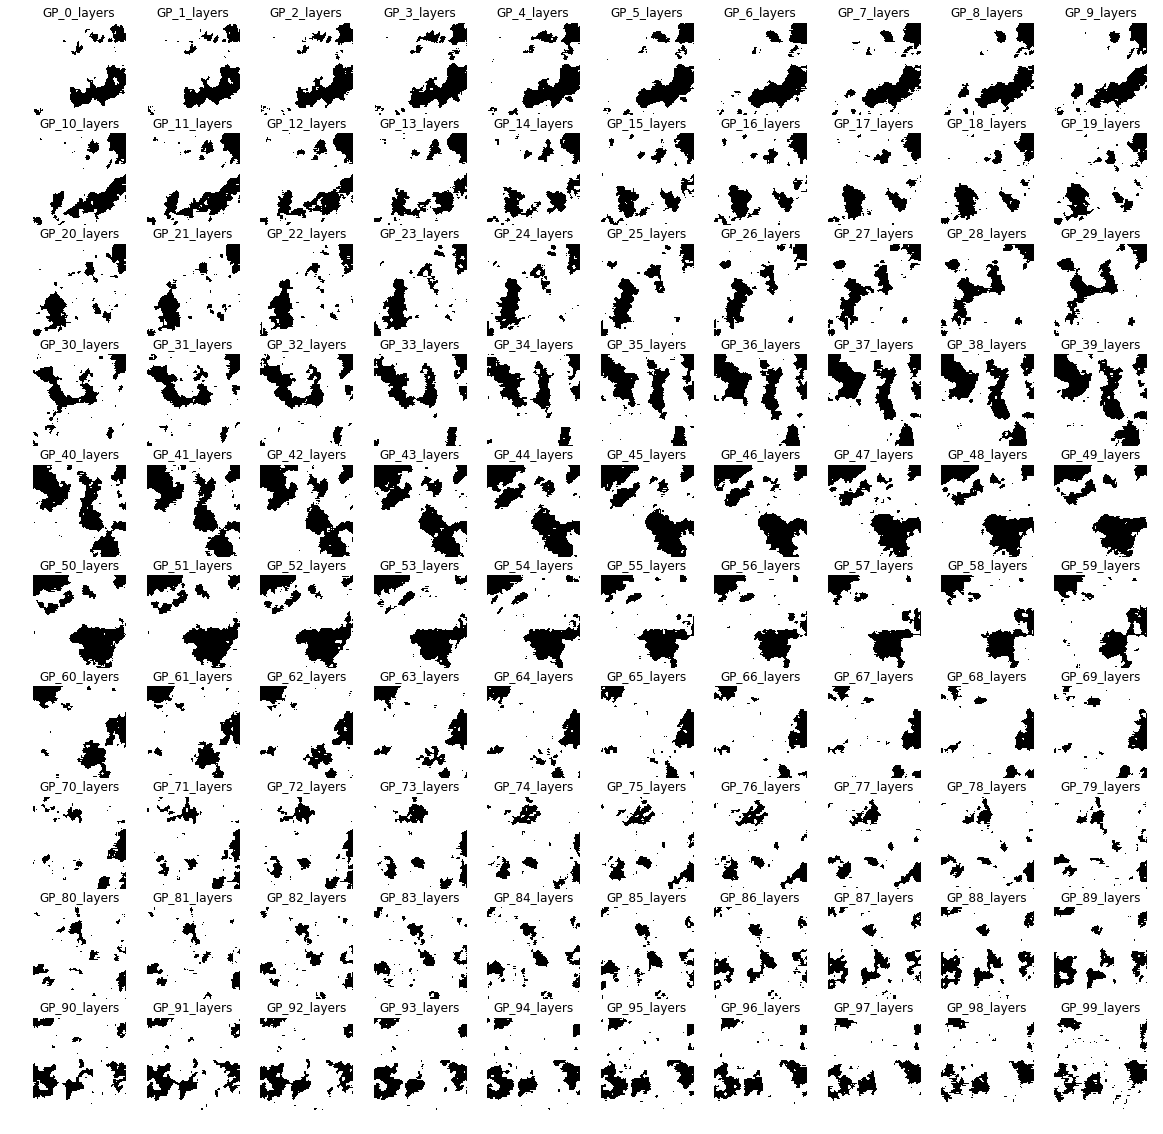

epoch:571  d_loss:[1.0624493 0.5      ]  g_loss:3.4965158
epoch:572  d_loss:[0.57275873 0.70000005]  g_loss:3.093764
epoch:573  d_loss:[0.28244084 0.79999995]  g_loss:2.9440207
epoch:574  d_loss:[0.5245234 0.7      ]  g_loss:4.768504
epoch:575  d_loss:[1.1379441 0.35     ]  g_loss:2.4645364
epoch:576  d_loss:[0.47799057 0.79999995]  g_loss:6.007512
epoch:577  d_loss:[2.0589838 0.2      ]  g_loss:5.129118
epoch:578  d_loss:[1.2028166 0.3      ]  g_loss:3.7406602
epoch:579  d_loss:[0.13766357 0.95      ]  g_loss:4.1248374
epoch:580  d_loss:[0.18203086 0.95      ]  g_loss:3.7497094


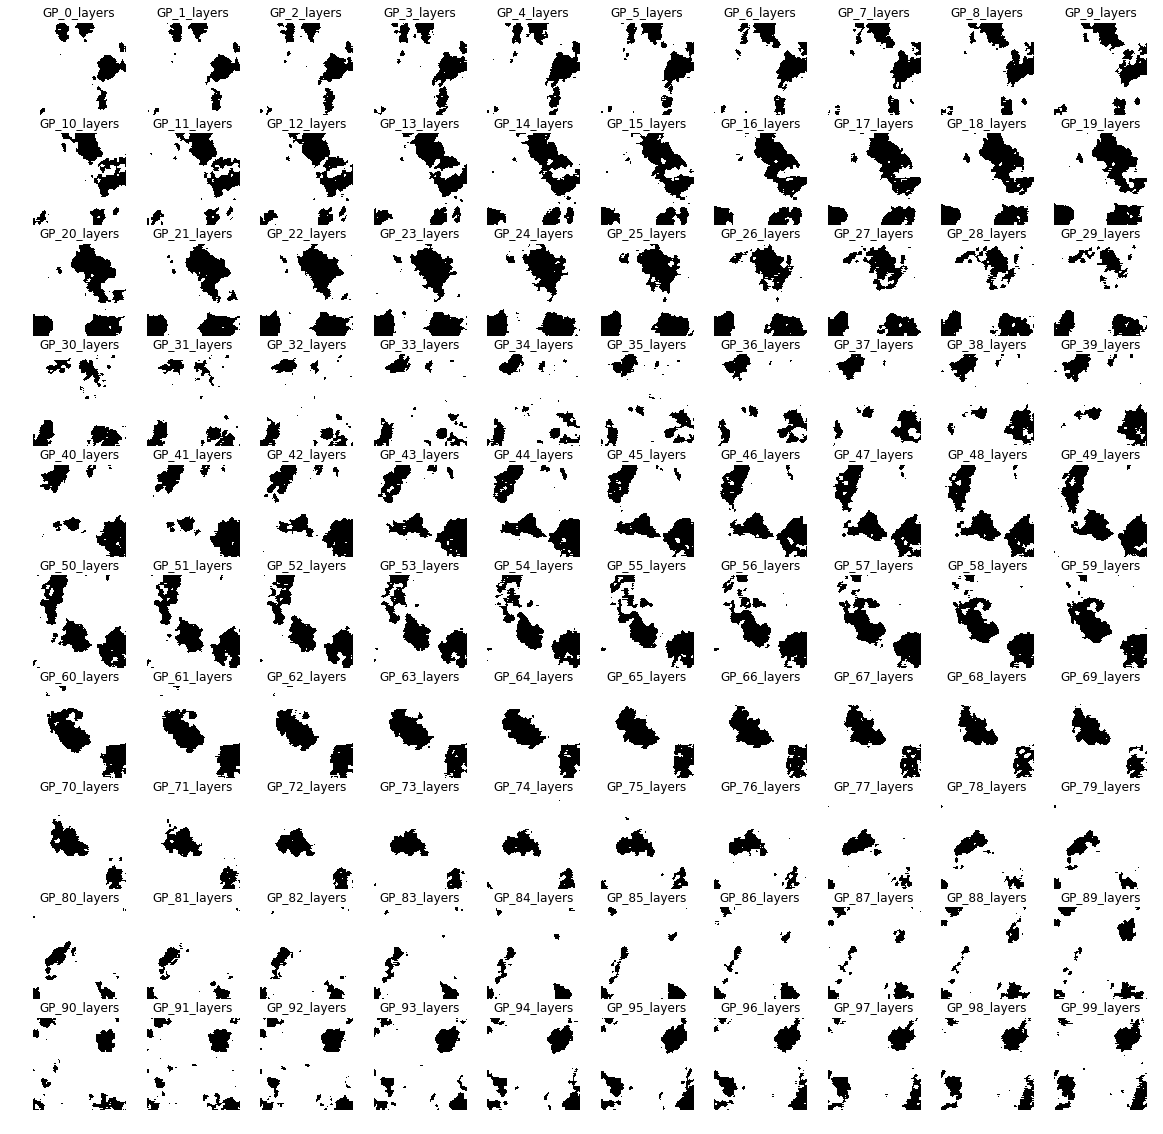

epoch:581  d_loss:[0.3757761 0.85     ]  g_loss:3.280257
epoch:582  d_loss:[0.1048027 1.       ]  g_loss:3.2654548
epoch:583  d_loss:[2.0196857 0.25     ]  g_loss:3.9518433
epoch:584  d_loss:[0.38110816 0.85      ]  g_loss:4.208758
epoch:585  d_loss:[0.2381687 0.9      ]  g_loss:3.0715804
epoch:586  d_loss:[0.28114453 0.9       ]  g_loss:5.0676713
epoch:587  d_loss:[0.8850438 0.55     ]  g_loss:3.5784192
epoch:588  d_loss:[0.51767457 0.70000005]  g_loss:2.971111
epoch:589  d_loss:[0.5399804 0.7      ]  g_loss:5.040706
epoch:590  d_loss:[0.5542036 0.7      ]  g_loss:1.581099


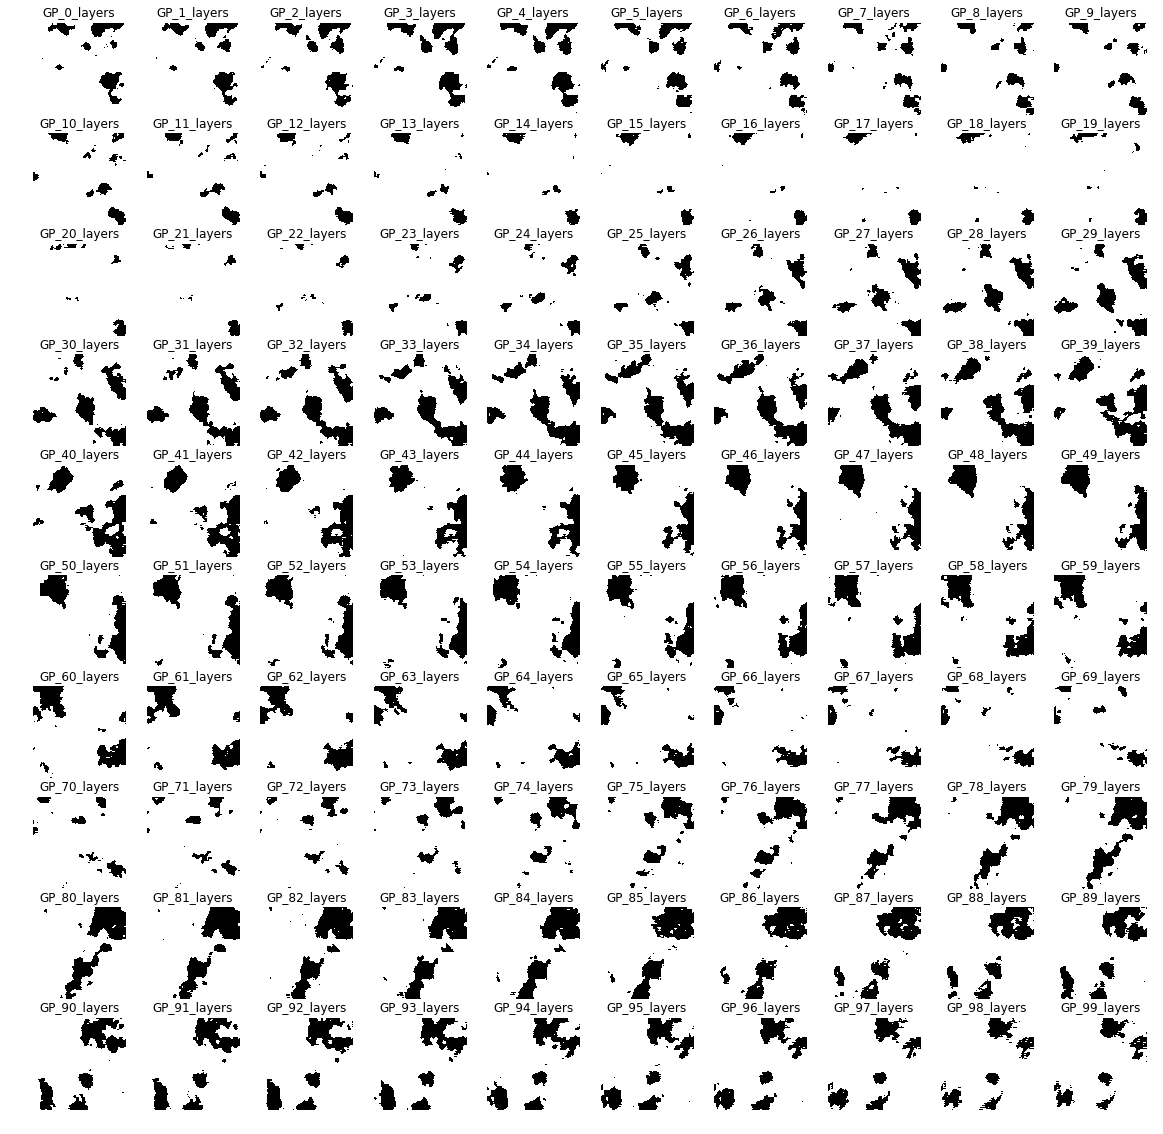

epoch:591  d_loss:[0.30920017 0.85      ]  g_loss:2.5449655
epoch:592  d_loss:[0.40023375 0.8       ]  g_loss:2.9146833
epoch:593  d_loss:[0.33111197 0.79999995]  g_loss:4.654907
epoch:594  d_loss:[0.9281298  0.35000002]  g_loss:4.356347
epoch:595  d_loss:[0.4704578 0.75     ]  g_loss:3.0943925
epoch:596  d_loss:[0.13762856 0.95      ]  g_loss:2.1033075
epoch:597  d_loss:[0.73522615 0.65      ]  g_loss:6.076374
epoch:598  d_loss:[0.89822155 0.45000002]  g_loss:2.7690883
epoch:599  d_loss:[0.16596487 0.9       ]  g_loss:2.6014926
epoch:600  d_loss:[0.22643618 0.95      ]  g_loss:4.468225


epoch:601  d_loss:[0.22907685 0.95      ]  g_loss:1.7530495
epoch:602  d_loss:[0.5346906 0.65     ]  g_loss:7.3523307
epoch:603  d_loss:[1.9261982 0.2      ]  g_loss:3.5098388
epoch:604  d_loss:[0.1949778 1.       ]  g_loss:1.4948052
epoch:605  d_loss:[0.22920313 0.8       ]  g_loss:5.275853
epoch:606  d_loss:[0.22809415 0.85      ]  g_loss:2.9460545
epoch:607  d_loss:[0.54065937 0.8       ]  g_loss:6.7803183
epoch:608  d_loss:[1.4093406 0.4      ]  g_loss:3.0304434
epoch:609  d_loss:[0.13934301 1.        ]  g_loss:4.2953296
epoch:610  d_loss:[0.3068352 0.85     ]  g_loss:3.5269883


epoch:611  d_loss:[0.2348972 0.9      ]  g_loss:2.5002708
epoch:612  d_loss:[0.05109569 1.        ]  g_loss:3.723598
epoch:613  d_loss:[0.25112236 0.9       ]  g_loss:3.6307476
epoch:614  d_loss:[0.5100995 0.8      ]  g_loss:3.559398
epoch:615  d_loss:[0.23434424 0.9       ]  g_loss:4.556728
epoch:616  d_loss:[0.6748008 0.6      ]  g_loss:4.370504
epoch:617  d_loss:[1.0451229 0.45     ]  g_loss:5.0478106
epoch:618  d_loss:[0.28909156 0.9       ]  g_loss:5.0479445
epoch:619  d_loss:[0.4367234 0.9      ]  g_loss:1.1321591
epoch:620  d_loss:[0.3172679 0.85     ]  g_loss:4.842976


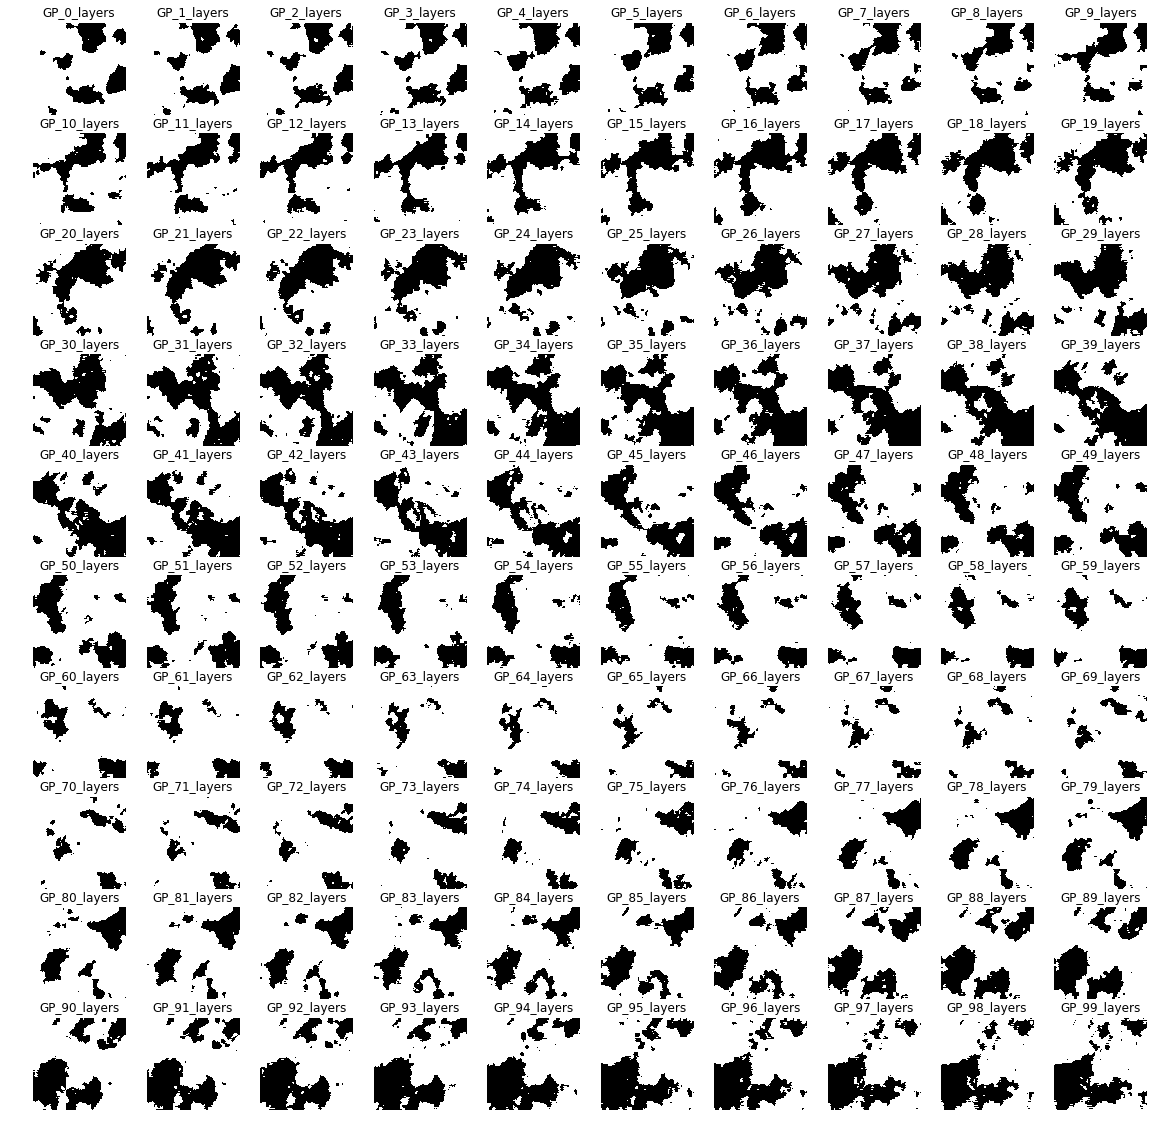

epoch:621  d_loss:[0.34539604 0.85      ]  g_loss:4.7047796
epoch:622  d_loss:[0.79807425 0.6       ]  g_loss:3.7960181
epoch:623  d_loss:[0.06122786 1.        ]  g_loss:4.344985
epoch:624  d_loss:[0.38523898 0.79999995]  g_loss:4.1776323
epoch:625  d_loss:[0.10393197 1.        ]  g_loss:3.8742805
epoch:626  d_loss:[0.5740397 0.7      ]  g_loss:4.212764
epoch:627  d_loss:[0.18419556 0.95      ]  g_loss:3.5459123
epoch:628  d_loss:[0.45733276 0.75      ]  g_loss:4.315833
epoch:629  d_loss:[0.06330437 1.        ]  g_loss:4.768272
epoch:630  d_loss:[2.0192297 0.35     ]  g_loss:8.342051


epoch:631  d_loss:[0.6251318 0.7      ]  g_loss:4.1367598
epoch:632  d_loss:[1.5363922 0.45     ]  g_loss:4.646628
epoch:633  d_loss:[0.34858418 0.8       ]  g_loss:2.416484
epoch:634  d_loss:[1.1607444 0.45     ]  g_loss:3.2855277
epoch:635  d_loss:[0.05554787 1.        ]  g_loss:4.9573846
epoch:636  d_loss:[2.0106978 0.25     ]  g_loss:6.727352
epoch:637  d_loss:[1.3613 0.45  ]  g_loss:2.5371299
epoch:638  d_loss:[0.06146866 1.        ]  g_loss:3.104419
epoch:639  d_loss:[0.24297032 0.9       ]  g_loss:2.5515335
epoch:640  d_loss:[0.19073375 0.9       ]  g_loss:3.0495286


epoch:641  d_loss:[0.44743943 0.70000005]  g_loss:4.487218
epoch:642  d_loss:[0.6227893 0.65     ]  g_loss:2.8321238
epoch:643  d_loss:[0.6153352  0.79999995]  g_loss:3.9818025
epoch:644  d_loss:[1.0114229 0.5      ]  g_loss:4.4005075
epoch:645  d_loss:[0.18591385 0.95      ]  g_loss:3.0267234
epoch:646  d_loss:[0.67495435 0.7       ]  g_loss:6.6340957
epoch:647  d_loss:[0.99522716 0.6       ]  g_loss:1.6633068
epoch:648  d_loss:[0.49423414 0.7       ]  g_loss:7.046145
epoch:649  d_loss:[0.50147414 0.85      ]  g_loss:2.6396527
epoch:650  d_loss:[0.74700034 0.7       ]  g_loss:6.9523573


epoch:651  d_loss:[1.6335471 0.3      ]  g_loss:5.236759
epoch:652  d_loss:[0.6226493  0.70000005]  g_loss:2.9259076
epoch:653  d_loss:[0.23146403 0.9       ]  g_loss:4.7071238
epoch:654  d_loss:[0.5867988  0.70000005]  g_loss:5.57463
epoch:655  d_loss:[1.0864415 0.45     ]  g_loss:6.9476686
epoch:656  d_loss:[1.0491865 0.55     ]  g_loss:0.95412445
epoch:657  d_loss:[0.37522244 0.75      ]  g_loss:7.6905646
epoch:658  d_loss:[4.142433 0.      ]  g_loss:3.362946
epoch:659  d_loss:[0.1945079 0.95     ]  g_loss:5.9070663
epoch:660  d_loss:[1.7308915 0.25     ]  g_loss:6.8399215


epoch:661  d_loss:[0.32991385 0.9       ]  g_loss:3.1967373
epoch:662  d_loss:[4.1888175 0.05     ]  g_loss:4.0712347
epoch:663  d_loss:[0.17749338 1.        ]  g_loss:5.2561235
epoch:664  d_loss:[1.5045947  0.35000002]  g_loss:6.301253
epoch:665  d_loss:[1.7525942 0.25     ]  g_loss:2.1420565
epoch:666  d_loss:[0.39491522 0.79999995]  g_loss:1.4623754
epoch:667  d_loss:[0.18837205 1.        ]  g_loss:3.03844
epoch:668  d_loss:[0.14708506 0.95      ]  g_loss:3.0652404
epoch:669  d_loss:[0.9776312  0.35000002]  g_loss:3.16756
epoch:670  d_loss:[0.47777683 0.75      ]  g_loss:3.4393573


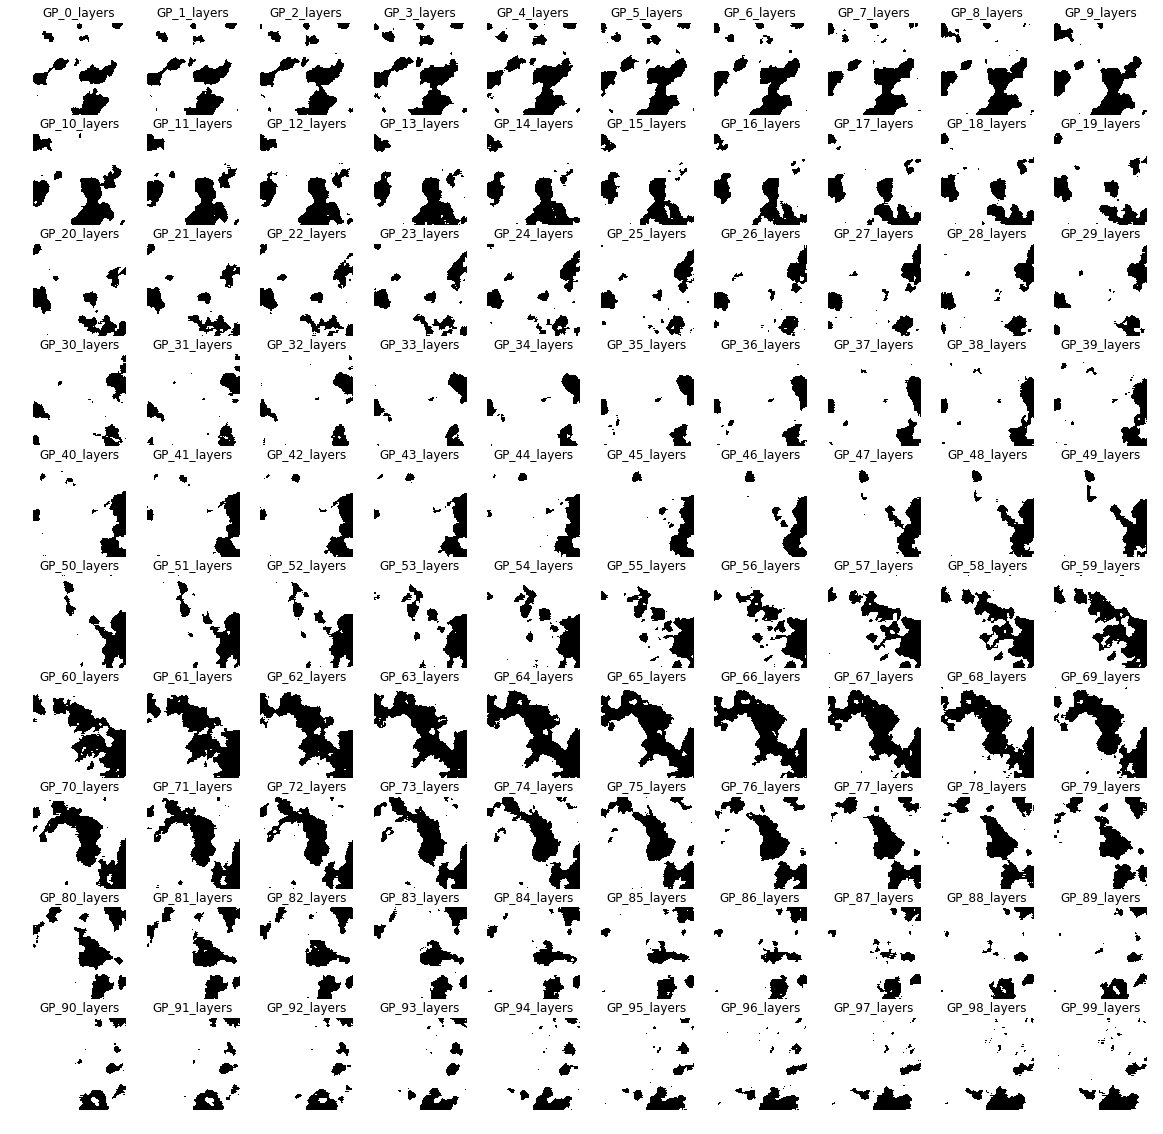

epoch:671  d_loss:[1.2783873 0.4      ]  g_loss:4.2278395
epoch:672  d_loss:[0.7171643 0.6      ]  g_loss:2.6682637
epoch:673  d_loss:[0.42038178 0.85      ]  g_loss:3.5027034
epoch:674  d_loss:[0.5436327  0.70000005]  g_loss:2.9576733
epoch:675  d_loss:[0.54802144 0.79999995]  g_loss:4.2806764
epoch:676  d_loss:[0.5314409 0.75     ]  g_loss:2.3223357
epoch:677  d_loss:[0.33527932 0.85      ]  g_loss:1.9079001
epoch:678  d_loss:[0.8352829 0.65     ]  g_loss:3.7654793
epoch:679  d_loss:[0.40049392 0.8       ]  g_loss:1.8212497
epoch:680  d_loss:[0.48857313 0.75      ]  g_loss:3.7256324


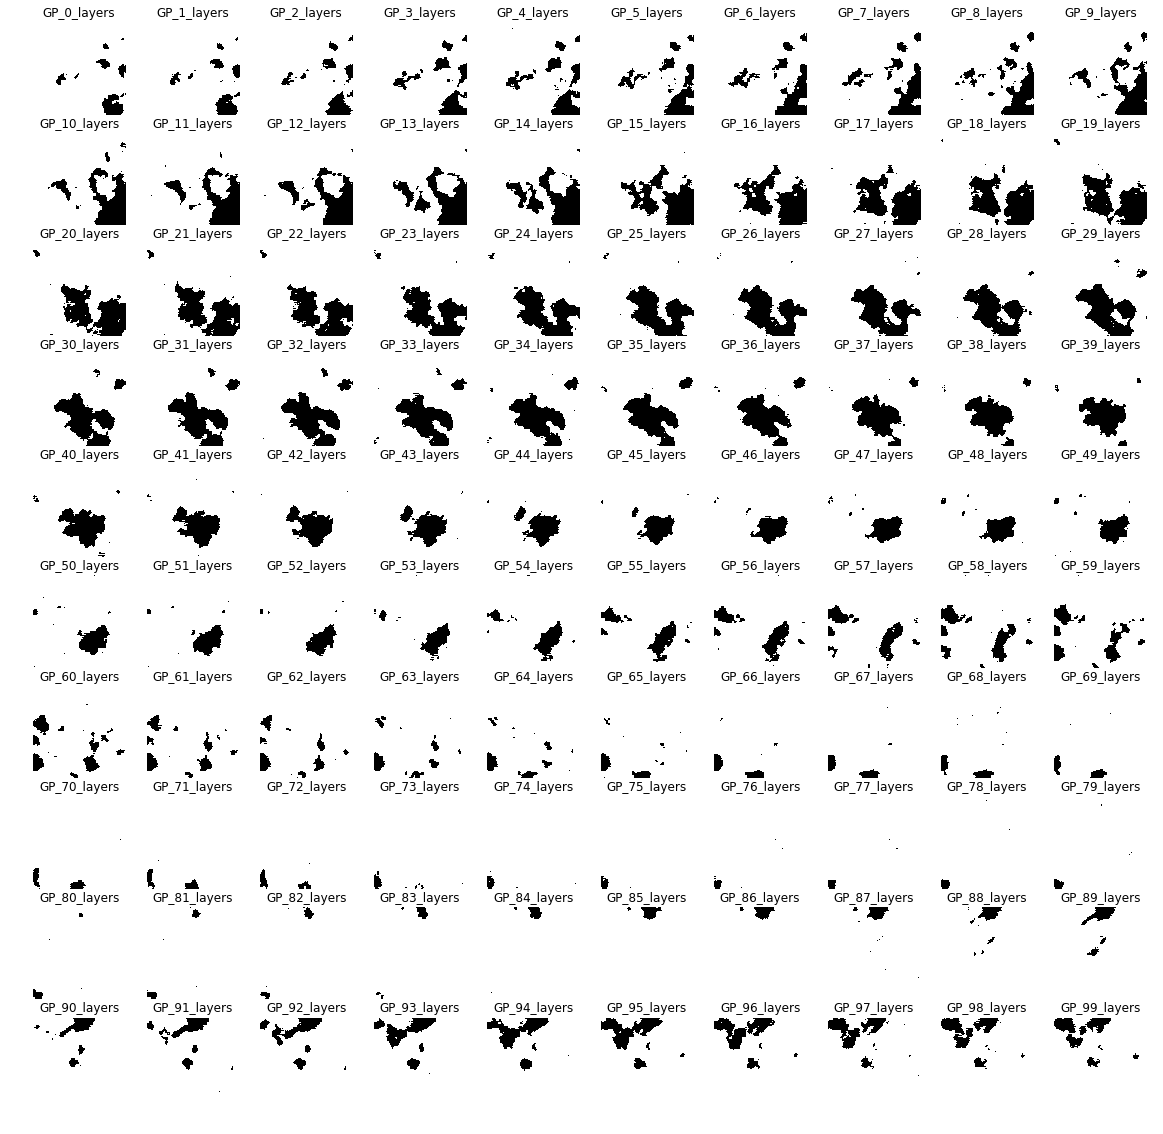

epoch:681  d_loss:[0.5701703 0.7      ]  g_loss:2.800241
epoch:682  d_loss:[0.78829145 0.6       ]  g_loss:3.7975712
epoch:683  d_loss:[0.25068888 0.9       ]  g_loss:3.0088716
epoch:684  d_loss:[0.23490468 0.9       ]  g_loss:1.6855171
epoch:685  d_loss:[0.8277829 0.6      ]  g_loss:4.5127573
epoch:686  d_loss:[0.7545177 0.6      ]  g_loss:2.832484
epoch:687  d_loss:[0.607026   0.70000005]  g_loss:5.3629966
epoch:688  d_loss:[0.9592666 0.35     ]  g_loss:2.4154584
epoch:689  d_loss:[0.17032635 0.95      ]  g_loss:3.2864013
epoch:690  d_loss:[0.06527979 1.        ]  g_loss:2.5204563


epoch:691  d_loss:[0.14189367 0.95      ]  g_loss:1.7371902
epoch:692  d_loss:[0.10490897 1.        ]  g_loss:1.7749441
epoch:693  d_loss:[0.05019417 1.        ]  g_loss:2.8145301
epoch:694  d_loss:[0.09774344 1.        ]  g_loss:1.7158378


In [0]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=1000, batch_size=10, sample_interval=10)